In [41]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

# Import the libraries

In [42]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, LeakyReLU, Flatten, SimpleRNN, BatchNormalization
import time
import datetime

from tensorflow.keras.layers import Lambda

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

In [43]:
def plot_dataframe(df):
  for column_name in df.columns:
    plt.figure()
    plt.title(column_name)
    plt.plot(df[column_name])

# Preprocessing

In [44]:
def add_Ma(df, window=5):
    for i in range(window, df.shape[0]):
        sum = 0.0
        for k in range(1, window+1):
            sum += df.iloc[i-k, 4]
        df.loc[df.index[i], 'Ma'] = np.round(sum/window, 6)
    return df[window:]

In [45]:
class Standarized_TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
  def __getitem__(self, index):
    samples, targets  = super(Standarized_TimeseriesGenerator, self).__getitem__(index)
    mean = samples.mean(axis=1)
    std = samples.std(axis=1)
    samples = (samples - mean[:,None,:])/std[:,None,:]
    targets = (targets - mean)/std
    return samples, targets

In [46]:
def get_gen_train_test(dataframe, n_sequence, n_batch):
    data = dataframe.drop(columns='Date').to_numpy()
    targets = data
    n_samples = data.shape[0]
    train_test_split=int(n_samples*0.8)

    data_gen_train = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = 0,
                                end_index = train_test_split,
                                shuffle = True)
    data_gen_test = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = train_test_split,
                                end_index = n_samples-1)

    return data_gen_train, data_gen_test

# Baseline

In [47]:
def mean_squared_error(X, lenght = 5):
    squared_error = 0
    for i in range(0, X.shape[0] - lenght):
        x = X[i:i+lenght]
        mean = x.mean()
        std = x.std()
        x = (x - mean)/std
        y = (X[i+lenght] - mean)/std
        squared_error += np.square(x[-1]-y)
    return squared_error/X.shape[0]

In [48]:
# For generated data
def mean_squared_error(dataset):
    mse=0
    for X_batch, y_batch in dataset:
        mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch[:, 3:4]))
    mse /= len(dataset)
    return mse

# Utilities

In [49]:
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3]))
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])))
    # ***The absolute is over the whole thing as y_true can be negative
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])/y_true[:,3]))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3])))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:,3] > y_true[:-1,3],tf.float32)
    return tf.reduce_mean((y_true[1:,3]-y_true[:-1,3])*mask)

# GAN

## Perdidas

In [50]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(x, y, fake_output):
    a1=0.01
    g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    g_mse = tf.keras.losses.MSE(x, y)
    return a1*g_mse + (1-a1)*g_loss, g_mse

## Generator

In [51]:
def make_generator_model(n_sequence, n_features):
    inputs = Input(shape=(n_sequence, n_features,))
    rnn_1 = SimpleRNN(units=10, return_sequences=True, activation=None, kernel_initializer='random_normal')(inputs)
    batch_norm1 = BatchNormalization()(rnn_1)
    rnn_1_LRelu = LeakyReLU(alpha=0.3)(batch_norm1) 
    rnn_1_droput = Dropout(0.3)(rnn_1_LRelu)
    rnn_2 = SimpleRNN(units=10, return_sequences=False, activation=None, kernel_initializer='random_normal')(rnn_1_droput)
    batch_norm2 = BatchNormalization()(rnn_2)
    rnn_2_LRelu = LeakyReLU(alpha=0.3)(batch_norm2) 
    rnn_2_droput = Dropout(0.3)(rnn_2_LRelu)
    output_dense = Dense(n_features, activation=None)(rnn_2_droput)
    output = LeakyReLU(alpha=0.3)(output_dense) 

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss=None, metrics=[mse, mae, mape, rmse, ar])
    model.summary()

    return model

## Discriminator

In [52]:
def make_discriminator_model(n_features):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(units=72, input_shape=((n_sequence+1) * n_features,), activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(tf.keras.layers.GaussianNoise(stddev=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(units=100, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(units=10, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(1 ,activation='sigmoid'))
    model.compile(loss=discriminator_loss)
    return model

# Training

In [53]:
def train_step_def(sequences, sequences_end):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_prediction = generator(sequences, training=True)

        sequences_true = tf.concat((sequences, sequences_end[:, None, :]), axis=1)
        sequences_fake = tf.concat((sequences, generated_prediction[:, None, :]), axis=1)

        real_output = discriminator(sequences_true, training=True)
        fake_output = discriminator(sequences_fake, training=True)

        gen_loss, gen_mse_loss = generator_loss(generated_prediction, 
                                                sequences_end, 
                                                fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

def test_step_def(sequences, sequences_end):
    generated_prediction = generator(sequences, training=False)

    sequences_true = tf.concat((sequences, sequences_end[:,None,:]), axis=1)
    sequences_fake = tf.concat((sequences, generated_prediction[:,None,:]), axis=1)

    real_output = discriminator(sequences_true, training=False)
    fake_output = discriminator(sequences_fake, training=False)

    gen_loss, gen_mse_loss = generator_loss(generated_prediction, sequences_end, fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

In [54]:
def train(dataset, dataset_val, epochs):
    history = np.empty(shape = (8, epochs))
    history_val = np.empty(shape = (8, epochs))
    len_dataset = len(dataset)
    len_dataset_val = len(dataset_val)
    for epoch in range(epochs):
        start = time.time()

        cur_dis_loss = 0
        cur_gen_loss = 0
        cur_gen_mse_loss = 0
        for sequence_batch, sequence_end_batch in dataset:
            aux_cur_losses = train_step(tf.cast(sequence_batch, tf.float32), 
                                      tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss += aux_cur_losses[0]/len_dataset
            cur_dis_loss += aux_cur_losses[1]/len_dataset
            cur_gen_mse_loss += aux_cur_losses[2]/len_dataset
        cur_gen_metrics = generator.evaluate(dataset,verbose=False)[1:]

        history[:, epoch] = cur_gen_loss, cur_dis_loss, cur_gen_mse_loss, *cur_gen_metrics

        cur_gen_metrics_val = generator.evaluate(dataset_val,verbose=False)[1: ]

        cur_gen_loss_val = 0
        cur_dis_loss_val = 0
        cur_gen_mse_loss_val = 0
        for sequence_batch, sequence_end_batch in dataset_val:
            aux_cur_losses_val = test_step(tf.cast(sequence_batch, tf.float32), 
                                         tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss_val += aux_cur_losses_val[0]/len_dataset_val
            cur_dis_loss_val += aux_cur_losses_val[1]/len_dataset_val
            cur_gen_mse_loss_val += aux_cur_losses_val[2]/len_dataset_val
    


        history_val[:, epoch] = cur_gen_loss_val, cur_dis_loss_val, cur_gen_mse_loss_val, *cur_gen_metrics_val

        print ('Time for epoch {} is {} sec Generator Loss: {},  Discriminator_loss: {}'
               .format(epoch + 1, time.time()-start, cur_gen_loss, cur_dis_loss))

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

    return history, history_val

## Visualization

In [55]:
def plot_history(history, history_val):
    metrics = ["gen_loss","dis_loss","gen_mse_loss", 'mse','mae','mape','rmse','ar']
    for i, metric_name in enumerate(metrics):  
        plt.figure()
        plt.title(metric_name)
        plt.plot(history[i], label='train')
        plt.plot(history_val[i], label='test')
        plt.legend()
    plt.show()

In [56]:
def plot_frame(sequence, target, model):
    y_pred = model.predict(sequence)[...,3]
    y_true = target[...,3]

    plt.figure()
    plt.title("closing price")
    plt.plot(y_true, label="true")
    plt.plot(y_pred, label="prediction")
    plt.legend()
    plt.show()

In [57]:
def get_best_results(history):
    min_index = np.argmin(history[3, :])
    return history[:, min_index]

## Variables

In [58]:
window = 5
n_sequence = window
n_features = 7
n_batch = 50

## Data loading

In [59]:
stock_code = "IBM"
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2020, 12, 31)
raw_data = pdr.get_data_yahoo(stock_code, start, end,threads=False, proxy="http://127.0.0.1:7890")
df = raw_data.dropna();
df = df.reset_index(level=0)
df = add_Ma(df, window)
df

[*********************100%***********************]  1 of 1 completed


Date        Open        High         Low       Close   Adj Close  \
5    2000-01-10  112.093689  114.125237  110.301147  112.810707   63.504860   
6    2000-01-11  112.691208  115.798279  111.496178  113.766731   64.043022   
7    2000-01-12  114.364243  116.634796  113.049713  114.244743   64.312164   
8    2000-01-13  114.663002  115.678780  110.659653  113.049713   63.639400   
9    2000-01-14  115.619026  117.889580  112.332695  114.364243   64.379395   
...         ...         ...         ...         ...         ...         ...   
5278 2020-12-23  118.432121  119.703636  118.298279  118.451241  104.716537   
5279 2020-12-24  119.502869  119.598473  118.747612  119.206497  105.384209   
5280 2020-12-28  119.598473  121.032501  118.986618  119.330788  105.494095   
5281 2020-12-29  119.837479  119.961761  117.820267  118.355644  104.632004   
5282 2020-12-30  118.355644  119.359467  118.193115  118.871895  105.088402   

        Volume          Ma  
5      8933363  109.285373  
6      8235472  109.667783  
7      7116775  110.994264  
8      8880226  111.663481  
9     11460604  112.476100  
...        ...         ...  
5278   2817819  119.302103  
5279   1842111  118.986615  
5280   3781499  118.822179  
5281   3647402  118.625238  
5282   3535794  118.703633  

[5278 rows x 8 columns]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 5, 10)             180       
                                                                 
 batch_normalization (BatchN  (None, 5, 10)            40        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5, 10)             0         
                                                                 
 dropout (Dropout)           (None, 5, 10)             0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10)                210       
                                                             

Time for epoch 53 is 0.7261698246002197 sec Generator Loss: 1.0240870714187622,  Discriminator_loss: 1.205265998840332
Time for epoch 54 is 0.7242453098297119 sec Generator Loss: 1.012535572052002,  Discriminator_loss: 1.207343578338623
Time for epoch 55 is 0.717644214630127 sec Generator Loss: 1.011589765548706,  Discriminator_loss: 1.213531494140625
Time for epoch 56 is 0.7282416820526123 sec Generator Loss: 1.0122714042663574,  Discriminator_loss: 1.213888168334961
Time for epoch 57 is 0.726346492767334 sec Generator Loss: 1.007582187652588,  Discriminator_loss: 1.2242459058761597
Time for epoch 58 is 0.7175664901733398 sec Generator Loss: 0.9812235832214355,  Discriminator_loss: 1.2124429941177368
Time for epoch 59 is 0.7208449840545654 sec Generator Loss: 0.9696910381317139,  Discriminator_loss: 1.2318711280822754
Time for epoch 60 is 0.7276878356933594 sec Generator Loss: 0.9789727330207825,  Discriminator_loss: 1.232420802116394
Time for epoch 61 is 0.7620823383331299 sec Genera

Time for epoch 122 is 0.7199883460998535 sec Generator Loss: 0.911495566368103,  Discriminator_loss: 1.2769368886947632
Time for epoch 123 is 0.7232716083526611 sec Generator Loss: 0.9034396409988403,  Discriminator_loss: 1.2806121110916138
Time for epoch 124 is 0.7185144424438477 sec Generator Loss: 0.8954979181289673,  Discriminator_loss: 1.2868479490280151
Time for epoch 125 is 0.7372992038726807 sec Generator Loss: 0.8942992091178894,  Discriminator_loss: 1.2851536273956299
Time for epoch 126 is 0.7698140144348145 sec Generator Loss: 0.903151273727417,  Discriminator_loss: 1.2914332151412964
Time for epoch 127 is 0.76481032371521 sec Generator Loss: 0.8863186836242676,  Discriminator_loss: 1.287988543510437
Time for epoch 128 is 0.7500026226043701 sec Generator Loss: 0.8850702047348022,  Discriminator_loss: 1.2848693132400513
Time for epoch 129 is 0.7599105834960938 sec Generator Loss: 0.8877187371253967,  Discriminator_loss: 1.2810510396957397
Time for epoch 130 is 0.7478816509246

Time for epoch 190 is 0.6991486549377441 sec Generator Loss: 0.8789404034614563,  Discriminator_loss: 1.2967652082443237
Time for epoch 191 is 0.6768078804016113 sec Generator Loss: 0.8761366009712219,  Discriminator_loss: 1.2937369346618652
Time for epoch 192 is 0.6987192630767822 sec Generator Loss: 0.8837506175041199,  Discriminator_loss: 1.295029878616333
Time for epoch 193 is 0.7238304615020752 sec Generator Loss: 0.883822500705719,  Discriminator_loss: 1.3030575513839722
Time for epoch 194 is 0.7045056819915771 sec Generator Loss: 0.8726086020469666,  Discriminator_loss: 1.3040341138839722
Time for epoch 195 is 0.673701286315918 sec Generator Loss: 0.8799999952316284,  Discriminator_loss: 1.296687126159668
Time for epoch 196 is 0.6551697254180908 sec Generator Loss: 0.8700897693634033,  Discriminator_loss: 1.3090384006500244
Time for epoch 197 is 0.6879162788391113 sec Generator Loss: 0.8730843663215637,  Discriminator_loss: 1.3034781217575073
Time for epoch 198 is 0.717755079269

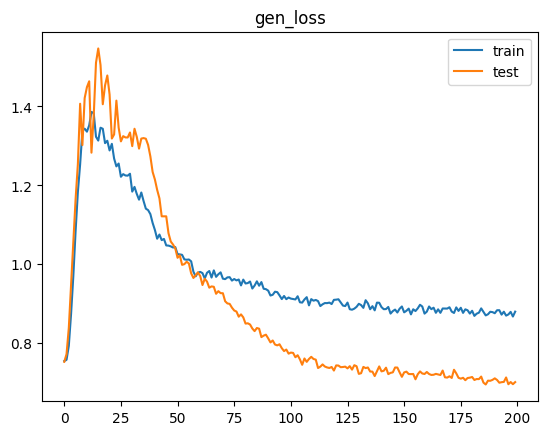

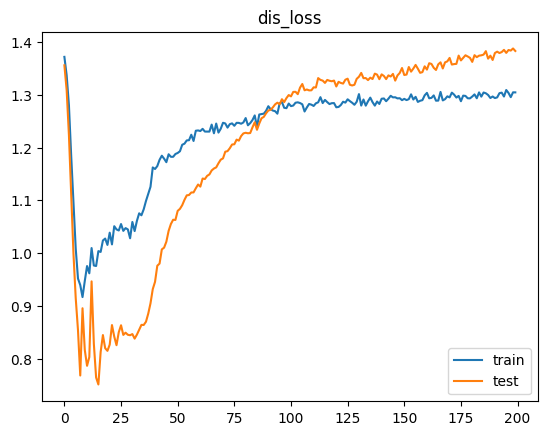

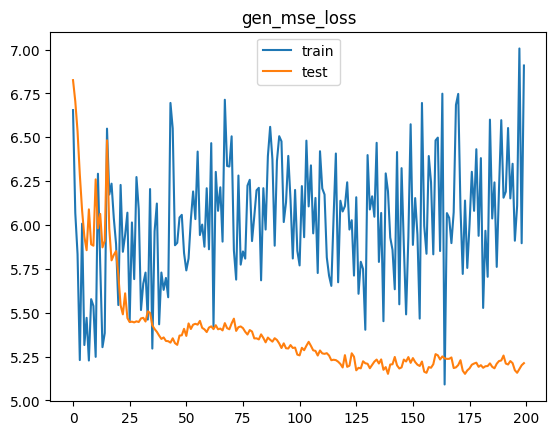

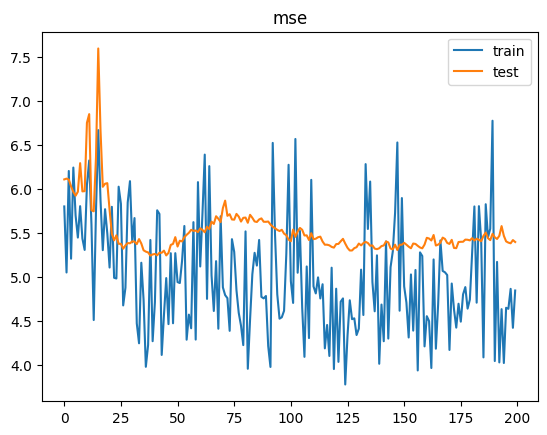

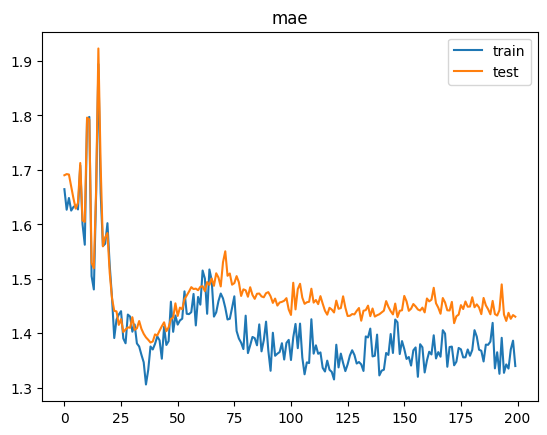

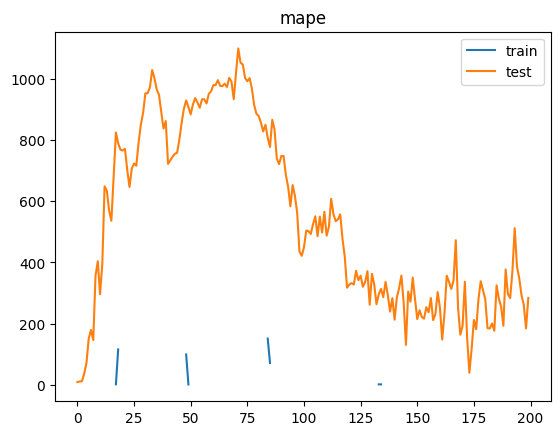

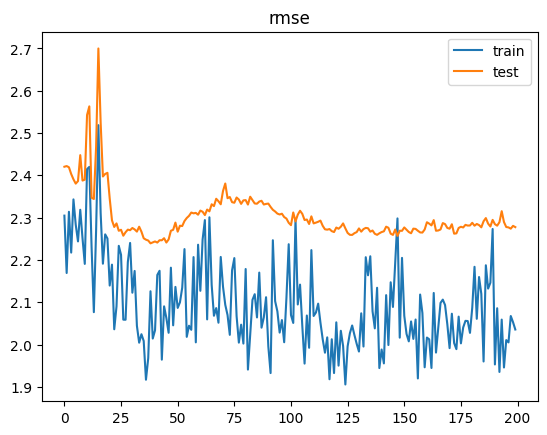

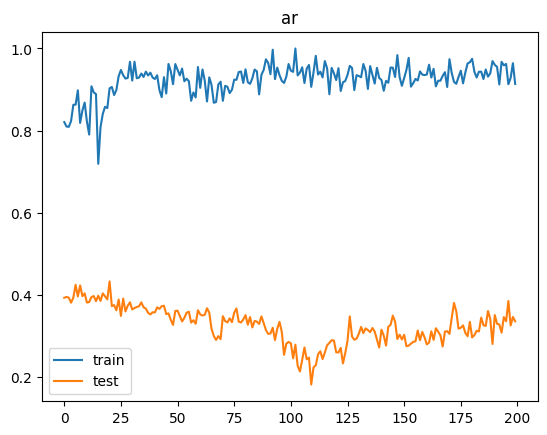

2/2 [==============================] - 0s 3ms/step


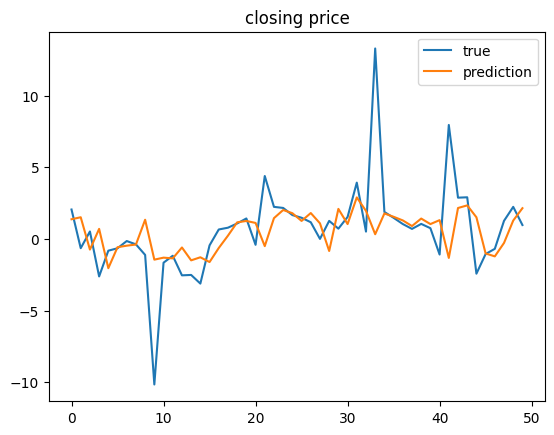

[MSE Baseline] train: 4.597040181619752  test: 4.988566607603537
Delta time with epochs = 200: 0:02:39.712537
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 5, 10)             180       
                                                                 
 batch_normalization_2 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 5, 10)             0         
                                                                 
 dropout_5 (Dropout)         (None, 5, 10)             0         
                                                                 
 simple_rnn_3 (

Time for epoch 53 is 0.6609020233154297 sec Generator Loss: 0.9870527386665344,  Discriminator_loss: 1.2242138385772705
Time for epoch 54 is 0.6674251556396484 sec Generator Loss: 0.9846628904342651,  Discriminator_loss: 1.227191686630249
Time for epoch 55 is 0.6829643249511719 sec Generator Loss: 0.9821076989173889,  Discriminator_loss: 1.222124457359314
Time for epoch 56 is 0.695542573928833 sec Generator Loss: 0.9691953063011169,  Discriminator_loss: 1.239060878753662
Time for epoch 57 is 0.6828262805938721 sec Generator Loss: 0.9682479500770569,  Discriminator_loss: 1.2222720384597778
Time for epoch 58 is 0.68648362159729 sec Generator Loss: 0.9686843156814575,  Discriminator_loss: 1.2261909246444702
Time for epoch 59 is 0.6695272922515869 sec Generator Loss: 0.962805449962616,  Discriminator_loss: 1.2423012256622314
Time for epoch 60 is 0.6949818134307861 sec Generator Loss: 0.9599975943565369,  Discriminator_loss: 1.2367193698883057
Time for epoch 61 is 0.6980249881744385 sec Gen

Time for epoch 122 is 0.6894786357879639 sec Generator Loss: 0.8665528297424316,  Discriminator_loss: 1.296415090560913
Time for epoch 123 is 0.6886661052703857 sec Generator Loss: 0.8780423998832703,  Discriminator_loss: 1.2890297174453735
Time for epoch 124 is 0.7710318565368652 sec Generator Loss: 0.8775091171264648,  Discriminator_loss: 1.297416090965271
Time for epoch 125 is 0.6862845420837402 sec Generator Loss: 0.8620246648788452,  Discriminator_loss: 1.3040275573730469
Time for epoch 126 is 0.6806902885437012 sec Generator Loss: 0.8761312365531921,  Discriminator_loss: 1.3051331043243408
Time for epoch 127 is 0.7239794731140137 sec Generator Loss: 0.864491879940033,  Discriminator_loss: 1.3014832735061646
Time for epoch 128 is 0.7727823257446289 sec Generator Loss: 0.8804461359977722,  Discriminator_loss: 1.2963968515396118
Time for epoch 129 is 0.7265844345092773 sec Generator Loss: 0.8690913915634155,  Discriminator_loss: 1.3011668920516968
Time for epoch 130 is 0.69025492668

Time for epoch 191 is 0.6915037631988525 sec Generator Loss: 0.8845186233520508,  Discriminator_loss: 1.2877153158187866
Time for epoch 192 is 0.7467384338378906 sec Generator Loss: 0.8820932507514954,  Discriminator_loss: 1.282250165939331
Time for epoch 193 is 0.723865270614624 sec Generator Loss: 0.8795914053916931,  Discriminator_loss: 1.2861759662628174
Time for epoch 194 is 0.6773271560668945 sec Generator Loss: 0.8686457872390747,  Discriminator_loss: 1.301882028579712
Time for epoch 195 is 0.7167925834655762 sec Generator Loss: 0.8809055685997009,  Discriminator_loss: 1.2841148376464844
Time for epoch 196 is 0.6765093803405762 sec Generator Loss: 0.8702835440635681,  Discriminator_loss: 1.2846269607543945
Time for epoch 197 is 0.7259907722473145 sec Generator Loss: 0.8722853660583496,  Discriminator_loss: 1.2982534170150757
Time for epoch 198 is 0.6745264530181885 sec Generator Loss: 0.8706141114234924,  Discriminator_loss: 1.2976276874542236
Time for epoch 199 is 0.70736169815

Time for epoch 259 is 0.6459190845489502 sec Generator Loss: 0.8653706312179565,  Discriminator_loss: 1.2896599769592285
Time for epoch 260 is 0.6683969497680664 sec Generator Loss: 0.8707061409950256,  Discriminator_loss: 1.293553352355957
Time for epoch 261 is 0.6514749526977539 sec Generator Loss: 0.8632968068122864,  Discriminator_loss: 1.3010671138763428
Time for epoch 262 is 0.6446704864501953 sec Generator Loss: 0.861455500125885,  Discriminator_loss: 1.3043993711471558
Time for epoch 263 is 0.6749234199523926 sec Generator Loss: 0.8733693361282349,  Discriminator_loss: 1.2857379913330078
Time for epoch 264 is 0.6751708984375 sec Generator Loss: 0.8740741610527039,  Discriminator_loss: 1.2928389310836792
Time for epoch 265 is 0.6826097965240479 sec Generator Loss: 0.8685036897659302,  Discriminator_loss: 1.2967324256896973
Time for epoch 266 is 0.6746680736541748 sec Generator Loss: 0.8651003837585449,  Discriminator_loss: 1.3040175437927246
Time for epoch 267 is 0.6656289100646

Time for epoch 327 is 0.7148551940917969 sec Generator Loss: 0.8662769794464111,  Discriminator_loss: 1.3021458387374878
Time for epoch 328 is 0.6864080429077148 sec Generator Loss: 0.8716195225715637,  Discriminator_loss: 1.2903088331222534
Time for epoch 329 is 0.68271803855896 sec Generator Loss: 0.8648503422737122,  Discriminator_loss: 1.302749752998352
Time for epoch 330 is 0.7065677642822266 sec Generator Loss: 0.86524897813797,  Discriminator_loss: 1.28983473777771
Time for epoch 331 is 0.6799168586730957 sec Generator Loss: 0.8634709715843201,  Discriminator_loss: 1.2992192506790161
Time for epoch 332 is 0.6739323139190674 sec Generator Loss: 0.871874213218689,  Discriminator_loss: 1.2952815294265747
Time for epoch 333 is 0.7116124629974365 sec Generator Loss: 0.8639619946479797,  Discriminator_loss: 1.2969762086868286
Time for epoch 334 is 0.690814733505249 sec Generator Loss: 0.8601992130279541,  Discriminator_loss: 1.30649733543396
Time for epoch 335 is 0.7239391803741455 se

Time for epoch 396 is 0.6503198146820068 sec Generator Loss: 0.867533802986145,  Discriminator_loss: 1.298068642616272
Time for epoch 397 is 0.6513574123382568 sec Generator Loss: 0.864311695098877,  Discriminator_loss: 1.2987489700317383
Time for epoch 398 is 0.6495764255523682 sec Generator Loss: 0.870214581489563,  Discriminator_loss: 1.293913722038269
Time for epoch 399 is 0.64652419090271 sec Generator Loss: 0.8736854195594788,  Discriminator_loss: 1.293813943862915
Time for epoch 400 is 0.650221586227417 sec Generator Loss: 0.8838534951210022,  Discriminator_loss: 1.2867637872695923
Time for epoch 401 is 0.653782844543457 sec Generator Loss: 0.8758805990219116,  Discriminator_loss: 1.2923110723495483
Time for epoch 402 is 0.6525826454162598 sec Generator Loss: 0.8736401796340942,  Discriminator_loss: 1.300170660018921
Time for epoch 403 is 0.6467547416687012 sec Generator Loss: 0.869728684425354,  Discriminator_loss: 1.2978235483169556
Time for epoch 404 is 0.6471171379089355 sec

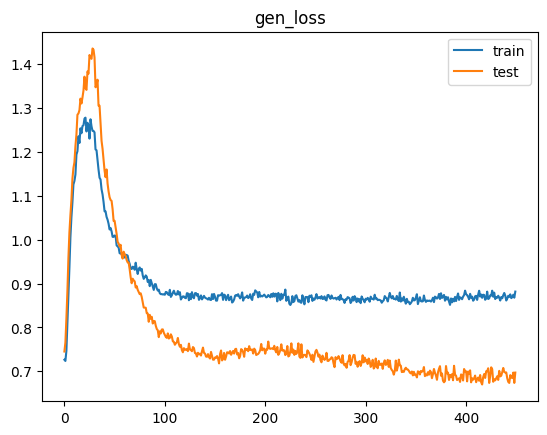

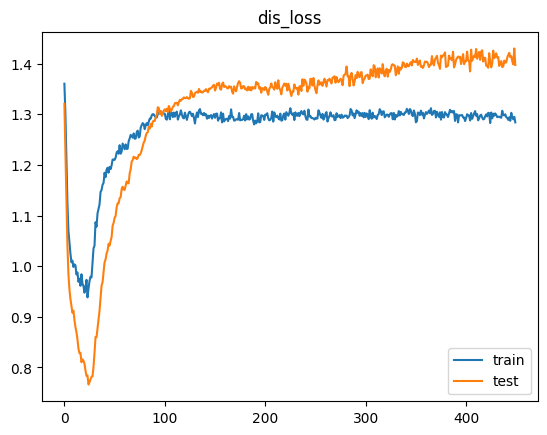

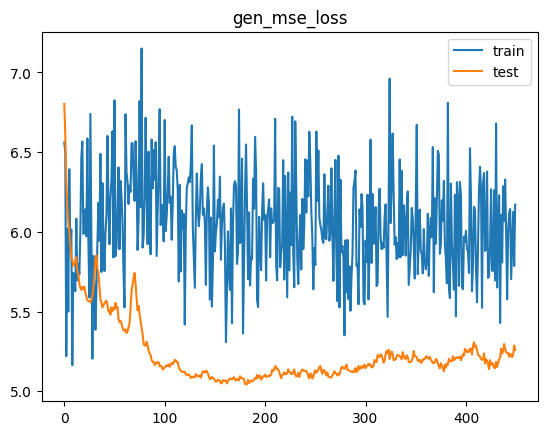

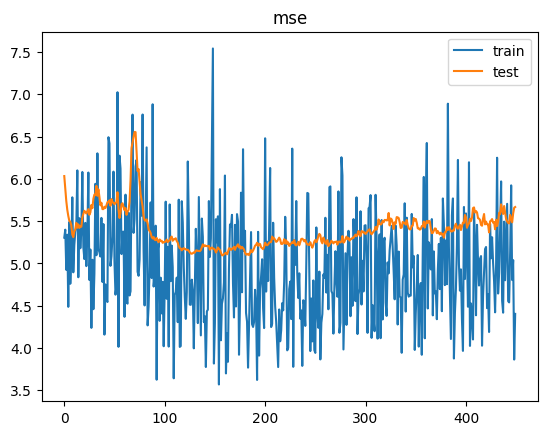

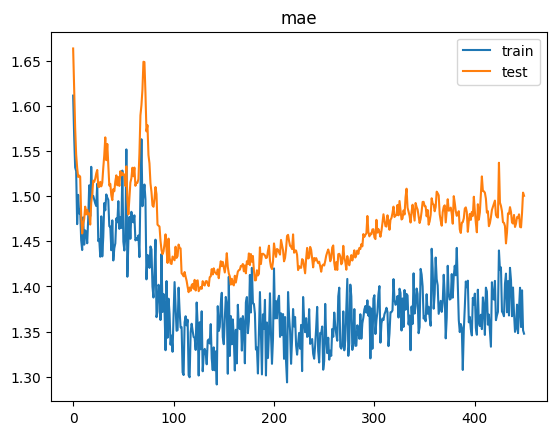

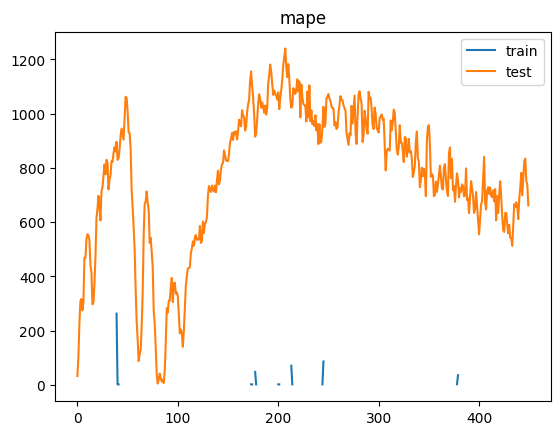

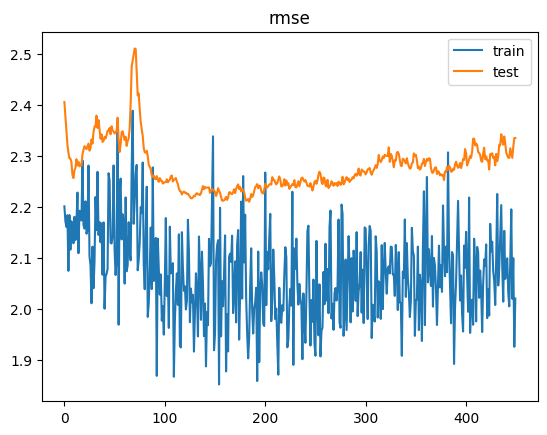

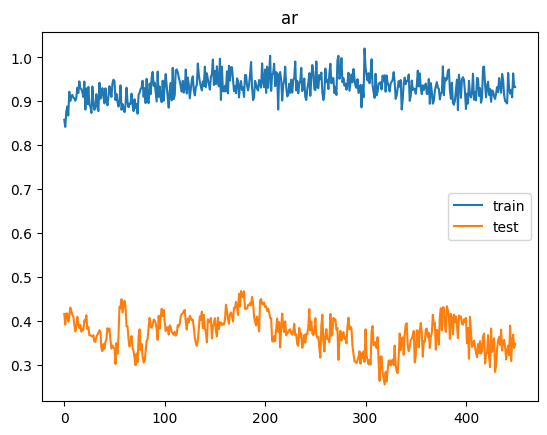

2/2 [==============================] - 0s 3ms/step


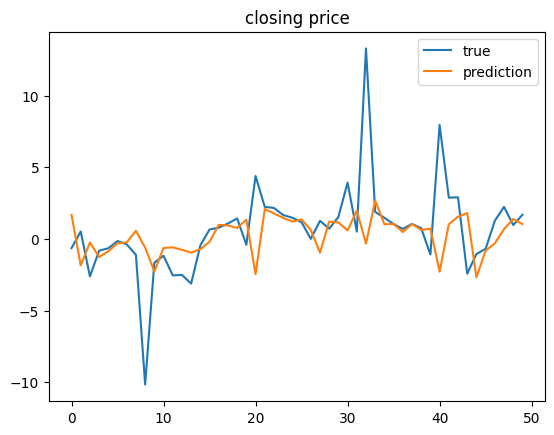

[MSE Baseline] train: 4.7065146886258615  test: 5.002352560408067
Delta time with epochs = 450: 0:05:24.263925
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 5, 10)             180       
                                                                 
 batch_normalization_4 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_10 (Dropout)        (None, 5, 10)             0         
                                                                 
 simple_rnn_5 

Time for epoch 53 is 0.6636350154876709 sec Generator Loss: 0.9953230619430542,  Discriminator_loss: 1.1863059997558594
Time for epoch 54 is 0.6719663143157959 sec Generator Loss: 0.9885209202766418,  Discriminator_loss: 1.2113456726074219
Time for epoch 55 is 1.0751380920410156 sec Generator Loss: 0.9899057745933533,  Discriminator_loss: 1.2002382278442383
Time for epoch 56 is 0.6770884990692139 sec Generator Loss: 0.9884190559387207,  Discriminator_loss: 1.2011860609054565
Time for epoch 57 is 0.678560733795166 sec Generator Loss: 0.9625542163848877,  Discriminator_loss: 1.2138147354125977
Time for epoch 58 is 0.6681044101715088 sec Generator Loss: 0.9791449904441833,  Discriminator_loss: 1.1924833059310913
Time for epoch 59 is 0.6777994632720947 sec Generator Loss: 0.9964337944984436,  Discriminator_loss: 1.1952800750732422
Time for epoch 60 is 0.6724963188171387 sec Generator Loss: 0.9806824326515198,  Discriminator_loss: 1.2035884857177734
Time for epoch 61 is 0.6700232028961182 s

Time for epoch 122 is 0.6625375747680664 sec Generator Loss: 0.9044346809387207,  Discriminator_loss: 1.2753623723983765
Time for epoch 123 is 0.6717512607574463 sec Generator Loss: 0.8998652100563049,  Discriminator_loss: 1.2968469858169556
Time for epoch 124 is 0.673701286315918 sec Generator Loss: 0.9089020490646362,  Discriminator_loss: 1.2779990434646606
Time for epoch 125 is 0.6614096164703369 sec Generator Loss: 0.9003958702087402,  Discriminator_loss: 1.277876853942871
Time for epoch 126 is 0.6742472648620605 sec Generator Loss: 0.8948155045509338,  Discriminator_loss: 1.3035212755203247
Time for epoch 127 is 0.6661503314971924 sec Generator Loss: 0.9004672765731812,  Discriminator_loss: 1.2822831869125366
Time for epoch 128 is 0.6715338230133057 sec Generator Loss: 0.8966628909111023,  Discriminator_loss: 1.2898609638214111
Time for epoch 129 is 0.7080972194671631 sec Generator Loss: 0.8989929556846619,  Discriminator_loss: 1.289957880973816
Time for epoch 130 is 0.66439175605

Time for epoch 190 is 0.6597700119018555 sec Generator Loss: 0.8591111898422241,  Discriminator_loss: 1.3052958250045776
Time for epoch 191 is 0.6667284965515137 sec Generator Loss: 0.8709344267845154,  Discriminator_loss: 1.302115797996521
Time for epoch 192 is 0.6724135875701904 sec Generator Loss: 0.8650256395339966,  Discriminator_loss: 1.2993685007095337
Time for epoch 193 is 0.6652379035949707 sec Generator Loss: 0.8697059154510498,  Discriminator_loss: 1.3029931783676147
Time for epoch 194 is 0.6734428405761719 sec Generator Loss: 0.8727105855941772,  Discriminator_loss: 1.299553394317627
Time for epoch 195 is 0.6732807159423828 sec Generator Loss: 0.8618184924125671,  Discriminator_loss: 1.3083691596984863
Time for epoch 196 is 0.667391300201416 sec Generator Loss: 0.8672714233398438,  Discriminator_loss: 1.2950676679611206
Time for epoch 197 is 0.7209687232971191 sec Generator Loss: 0.8644961714744568,  Discriminator_loss: 1.3030846118927002
Time for epoch 198 is 0.69936704635

Time for epoch 258 is 0.7441494464874268 sec Generator Loss: 0.8732232451438904,  Discriminator_loss: 1.2946350574493408
Time for epoch 259 is 0.7182536125183105 sec Generator Loss: 0.8721578121185303,  Discriminator_loss: 1.2960525751113892
Time for epoch 260 is 0.6683332920074463 sec Generator Loss: 0.8680216670036316,  Discriminator_loss: 1.2937114238739014
Time for epoch 261 is 0.6710474491119385 sec Generator Loss: 0.853725254535675,  Discriminator_loss: 1.3071985244750977
Time for epoch 262 is 0.7259993553161621 sec Generator Loss: 0.8720434308052063,  Discriminator_loss: 1.2998838424682617
Time for epoch 263 is 0.7010486125946045 sec Generator Loss: 0.8714458346366882,  Discriminator_loss: 1.2863068580627441
Time for epoch 264 is 0.7658007144927979 sec Generator Loss: 0.8709707856178284,  Discriminator_loss: 1.293953537940979
Time for epoch 265 is 0.7143585681915283 sec Generator Loss: 0.866269052028656,  Discriminator_loss: 1.301554799079895
Time for epoch 266 is 0.707514286041

Time for epoch 326 is 0.660595178604126 sec Generator Loss: 0.8700764179229736,  Discriminator_loss: 1.290650725364685
Time for epoch 327 is 0.6630096435546875 sec Generator Loss: 0.8635409474372864,  Discriminator_loss: 1.2999972105026245
Time for epoch 328 is 0.6646292209625244 sec Generator Loss: 0.8731746673583984,  Discriminator_loss: 1.2922155857086182
Time for epoch 329 is 0.6559906005859375 sec Generator Loss: 0.8702869415283203,  Discriminator_loss: 1.2833470106124878
Time for epoch 330 is 0.6651372909545898 sec Generator Loss: 0.8662934303283691,  Discriminator_loss: 1.3013083934783936
Time for epoch 331 is 0.7164592742919922 sec Generator Loss: 0.8684090971946716,  Discriminator_loss: 1.3007737398147583
Time for epoch 332 is 0.7283613681793213 sec Generator Loss: 0.8617127537727356,  Discriminator_loss: 1.289512038230896
Time for epoch 333 is 0.6808600425720215 sec Generator Loss: 0.8664239048957825,  Discriminator_loss: 1.3106465339660645
Time for epoch 334 is 0.67761659622

Time for epoch 395 is 0.6877422332763672 sec Generator Loss: 0.8660757541656494,  Discriminator_loss: 1.292126178741455
Time for epoch 396 is 0.6913752555847168 sec Generator Loss: 0.8609815239906311,  Discriminator_loss: 1.3102858066558838
Time for epoch 397 is 0.6940243244171143 sec Generator Loss: 0.8674497008323669,  Discriminator_loss: 1.290689468383789
Time for epoch 398 is 0.6872575283050537 sec Generator Loss: 0.8768315315246582,  Discriminator_loss: 1.2827370166778564
Time for epoch 399 is 0.7029640674591064 sec Generator Loss: 0.8730823397636414,  Discriminator_loss: 1.2916014194488525
Time for epoch 400 is 0.7003161907196045 sec Generator Loss: 0.8709874153137207,  Discriminator_loss: 1.2984333038330078
Time for epoch 401 is 0.6937577724456787 sec Generator Loss: 0.8686926364898682,  Discriminator_loss: 1.2990365028381348
Time for epoch 402 is 0.6960902214050293 sec Generator Loss: 0.8685859441757202,  Discriminator_loss: 1.2955650091171265
Time for epoch 403 is 0.6938624382

Time for epoch 463 is 0.6595540046691895 sec Generator Loss: 0.8783090114593506,  Discriminator_loss: 1.2755775451660156
Time for epoch 464 is 0.6658449172973633 sec Generator Loss: 0.8694297075271606,  Discriminator_loss: 1.2941275835037231
Time for epoch 465 is 0.6583659648895264 sec Generator Loss: 0.8703335523605347,  Discriminator_loss: 1.2983572483062744
Time for epoch 466 is 0.6598777770996094 sec Generator Loss: 0.8757236003875732,  Discriminator_loss: 1.2962672710418701
Time for epoch 467 is 0.695997953414917 sec Generator Loss: 0.876865804195404,  Discriminator_loss: 1.2888293266296387
Time for epoch 468 is 0.6704838275909424 sec Generator Loss: 0.8725379705429077,  Discriminator_loss: 1.3005000352859497
Time for epoch 469 is 0.6593132019042969 sec Generator Loss: 0.8781982660293579,  Discriminator_loss: 1.2839698791503906
Time for epoch 470 is 0.6566627025604248 sec Generator Loss: 0.8788783550262451,  Discriminator_loss: 1.2882192134857178
Time for epoch 471 is 0.6701247692

Time for epoch 532 is 0.6998612880706787 sec Generator Loss: 0.899099588394165,  Discriminator_loss: 1.285291075706482
Time for epoch 533 is 0.7077634334564209 sec Generator Loss: 0.8872687816619873,  Discriminator_loss: 1.280946135520935
Time for epoch 534 is 0.7345981597900391 sec Generator Loss: 0.8772547245025635,  Discriminator_loss: 1.287898302078247
Time for epoch 535 is 0.7365226745605469 sec Generator Loss: 0.8802548050880432,  Discriminator_loss: 1.289946436882019
Time for epoch 536 is 0.6999502182006836 sec Generator Loss: 0.8867235779762268,  Discriminator_loss: 1.2823141813278198
Time for epoch 537 is 0.6901648044586182 sec Generator Loss: 0.8844232559204102,  Discriminator_loss: 1.27680242061615
Time for epoch 538 is 0.6838901042938232 sec Generator Loss: 0.8881144523620605,  Discriminator_loss: 1.2775979042053223
Time for epoch 539 is 0.6993715763092041 sec Generator Loss: 0.8821579813957214,  Discriminator_loss: 1.2899024486541748
Time for epoch 540 is 0.682672977447509

Time for epoch 600 is 0.862109899520874 sec Generator Loss: 0.8896815776824951,  Discriminator_loss: 1.2758020162582397
Time for epoch 601 is 0.7779324054718018 sec Generator Loss: 0.8948104381561279,  Discriminator_loss: 1.2708016633987427
Time for epoch 602 is 0.7696521282196045 sec Generator Loss: 0.8969913125038147,  Discriminator_loss: 1.27715265750885
Time for epoch 603 is 0.7582108974456787 sec Generator Loss: 0.897137463092804,  Discriminator_loss: 1.2723857164382935
Time for epoch 604 is 0.8823761940002441 sec Generator Loss: 0.8910518288612366,  Discriminator_loss: 1.275124430656433
Time for epoch 605 is 0.7493605613708496 sec Generator Loss: 0.8935956954956055,  Discriminator_loss: 1.27157461643219
Time for epoch 606 is 0.7349131107330322 sec Generator Loss: 0.8943119645118713,  Discriminator_loss: 1.2813193798065186
Time for epoch 607 is 1.2681126594543457 sec Generator Loss: 0.8889943361282349,  Discriminator_loss: 1.2802084684371948
Time for epoch 608 is 0.719176530838012

Time for epoch 669 is 0.6949446201324463 sec Generator Loss: 0.8975033164024353,  Discriminator_loss: 1.266109585762024
Time for epoch 670 is 0.7020883560180664 sec Generator Loss: 0.9076485633850098,  Discriminator_loss: 1.269364595413208
Time for epoch 671 is 0.6933741569519043 sec Generator Loss: 0.8901874423027039,  Discriminator_loss: 1.275357961654663
Time for epoch 672 is 0.7031104564666748 sec Generator Loss: 0.9014526009559631,  Discriminator_loss: 1.2719804048538208
Time for epoch 673 is 0.6806230545043945 sec Generator Loss: 0.9061525464057922,  Discriminator_loss: 1.2705204486846924
Time for epoch 674 is 0.6938045024871826 sec Generator Loss: 0.9259508848190308,  Discriminator_loss: 1.2700424194335938
Time for epoch 675 is 0.6957931518554688 sec Generator Loss: 0.9043688774108887,  Discriminator_loss: 1.2774592638015747
Time for epoch 676 is 0.707261323928833 sec Generator Loss: 0.896742045879364,  Discriminator_loss: 1.2778316736221313
Time for epoch 677 is 0.7239432334899

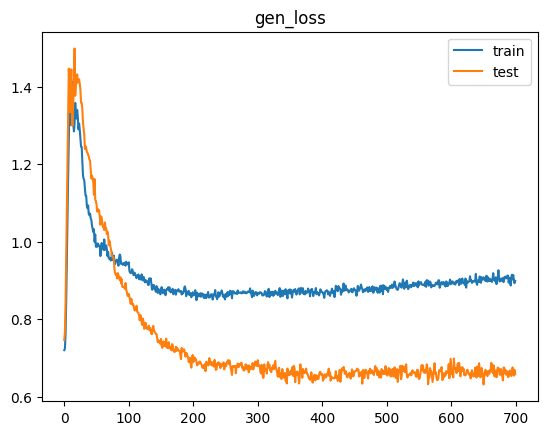

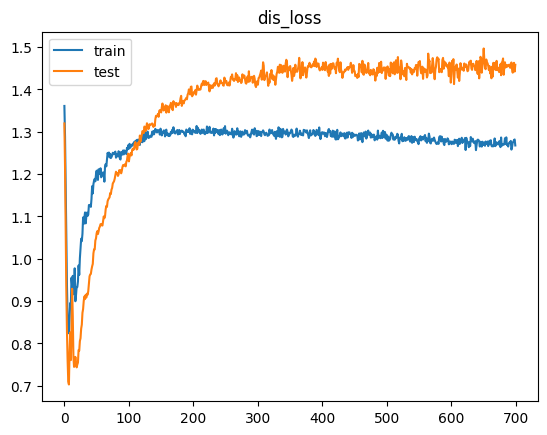

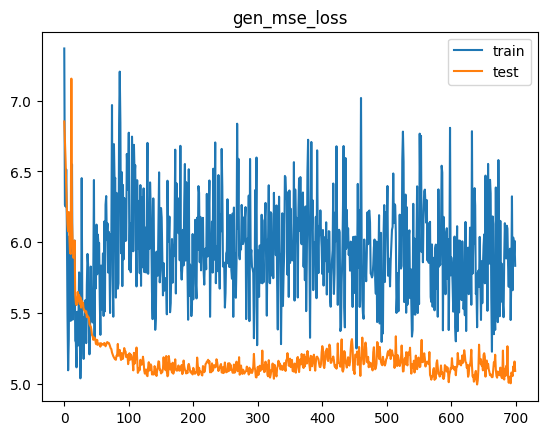

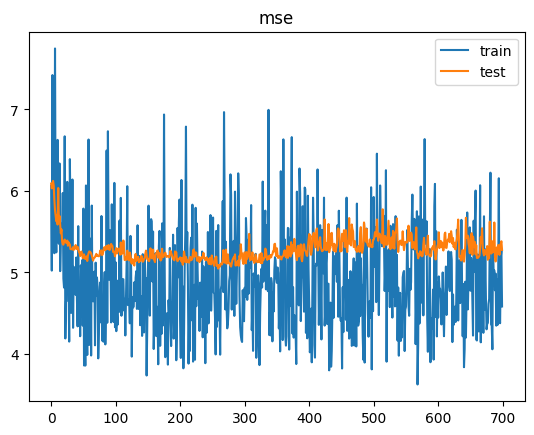

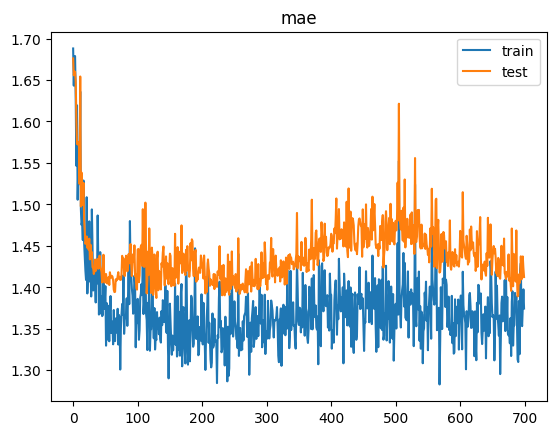

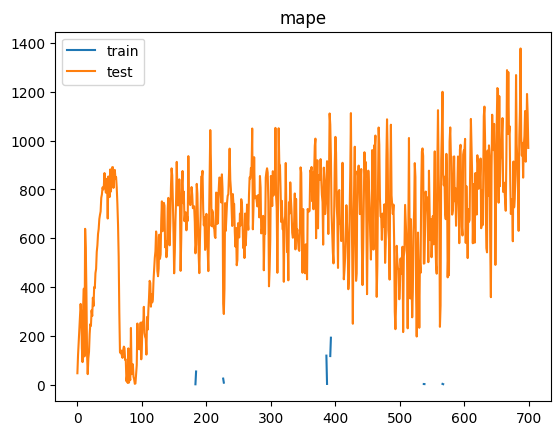

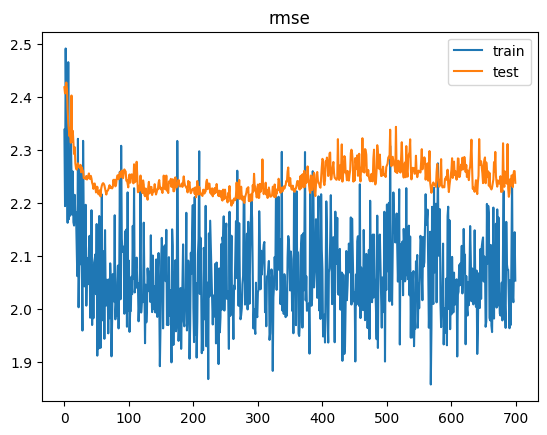

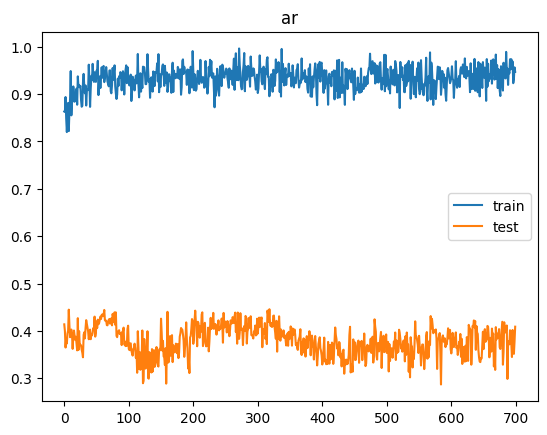

2/2 [==============================] - 0s 3ms/step


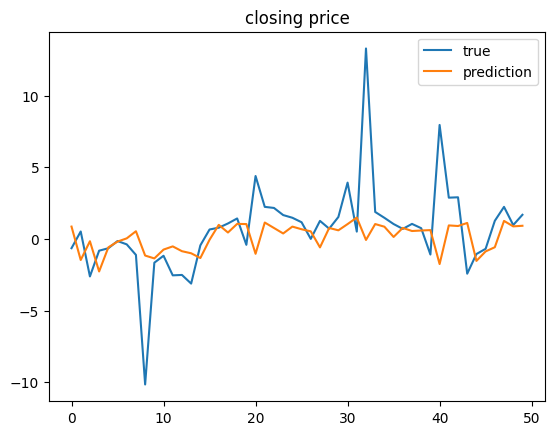

[MSE Baseline] train: 4.618232225036126  test: 5.002352560408067
Delta time with epochs = 700: 0:08:22.242098
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 5, 10)             180       
                                                                 
 batch_normalization_6 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_15 (Dropout)        (None, 5, 10)             0         
                                                                 
 simple_rnn_7 (

Time for epoch 53 is 0.7026150226593018 sec Generator Loss: 1.0563417673110962,  Discriminator_loss: 1.1645902395248413
Time for epoch 54 is 0.731513261795044 sec Generator Loss: 1.05825674533844,  Discriminator_loss: 1.1571869850158691
Time for epoch 55 is 0.706937313079834 sec Generator Loss: 1.0604900121688843,  Discriminator_loss: 1.174257755279541
Time for epoch 56 is 0.7191801071166992 sec Generator Loss: 1.0504341125488281,  Discriminator_loss: 1.1808991432189941
Time for epoch 57 is 0.743100643157959 sec Generator Loss: 1.0390900373458862,  Discriminator_loss: 1.1868956089019775
Time for epoch 58 is 0.6953403949737549 sec Generator Loss: 1.0359467267990112,  Discriminator_loss: 1.1671644449234009
Time for epoch 59 is 0.708094596862793 sec Generator Loss: 1.0379399061203003,  Discriminator_loss: 1.1913732290267944
Time for epoch 60 is 0.6936964988708496 sec Generator Loss: 1.0405845642089844,  Discriminator_loss: 1.1884735822677612
Time for epoch 61 is 0.7247099876403809 sec Gen

Time for epoch 122 is 0.6770744323730469 sec Generator Loss: 0.9085100293159485,  Discriminator_loss: 1.2722796201705933
Time for epoch 123 is 0.6815810203552246 sec Generator Loss: 0.9052116870880127,  Discriminator_loss: 1.2737088203430176
Time for epoch 124 is 0.7899825572967529 sec Generator Loss: 0.9107404351234436,  Discriminator_loss: 1.2705637216567993
Time for epoch 125 is 0.6937570571899414 sec Generator Loss: 0.9137478470802307,  Discriminator_loss: 1.2668095827102661
Time for epoch 126 is 0.6756281852722168 sec Generator Loss: 0.9030140042304993,  Discriminator_loss: 1.2772525548934937
Time for epoch 127 is 0.6654336452484131 sec Generator Loss: 0.9075043797492981,  Discriminator_loss: 1.2713879346847534
Time for epoch 128 is 0.6855037212371826 sec Generator Loss: 0.8999399542808533,  Discriminator_loss: 1.273690104484558
Time for epoch 129 is 0.6795980930328369 sec Generator Loss: 0.9079886674880981,  Discriminator_loss: 1.2722691297531128
Time for epoch 130 is 0.670630216

Time for epoch 190 is 0.6585736274719238 sec Generator Loss: 0.9142823219299316,  Discriminator_loss: 1.2702876329421997
Time for epoch 191 is 0.6719436645507812 sec Generator Loss: 0.9176613688468933,  Discriminator_loss: 1.271332859992981
Time for epoch 192 is 0.6615903377532959 sec Generator Loss: 0.9216692447662354,  Discriminator_loss: 1.2657310962677002
Time for epoch 193 is 0.6647727489471436 sec Generator Loss: 0.926099419593811,  Discriminator_loss: 1.2564777135849
Time for epoch 194 is 0.6972737312316895 sec Generator Loss: 0.9268102049827576,  Discriminator_loss: 1.2570233345031738
Time for epoch 195 is 0.6681697368621826 sec Generator Loss: 0.9149963855743408,  Discriminator_loss: 1.269639253616333
Time for epoch 196 is 0.6639838218688965 sec Generator Loss: 0.9185977578163147,  Discriminator_loss: 1.2596379518508911
Time for epoch 197 is 0.6730442047119141 sec Generator Loss: 0.9232203364372253,  Discriminator_loss: 1.2546827793121338
Time for epoch 198 is 0.65959095954895

Time for epoch 258 is 0.7349543571472168 sec Generator Loss: 0.911594808101654,  Discriminator_loss: 1.2771093845367432
Time for epoch 259 is 0.7342734336853027 sec Generator Loss: 0.9160142540931702,  Discriminator_loss: 1.2657318115234375
Time for epoch 260 is 0.6762690544128418 sec Generator Loss: 0.9119088649749756,  Discriminator_loss: 1.2608470916748047
Time for epoch 261 is 0.6672852039337158 sec Generator Loss: 0.9174757599830627,  Discriminator_loss: 1.2724605798721313
Time for epoch 262 is 0.6637380123138428 sec Generator Loss: 0.9167646169662476,  Discriminator_loss: 1.2643629312515259
Time for epoch 263 is 0.6755938529968262 sec Generator Loss: 0.9047508239746094,  Discriminator_loss: 1.2736636400222778
Time for epoch 264 is 0.6839957237243652 sec Generator Loss: 0.9095664620399475,  Discriminator_loss: 1.2776092290878296
Time for epoch 265 is 0.6493625640869141 sec Generator Loss: 0.9055219292640686,  Discriminator_loss: 1.2748324871063232
Time for epoch 266 is 0.691699028

Time for epoch 326 is 0.6712408065795898 sec Generator Loss: 0.9092839360237122,  Discriminator_loss: 1.2685449123382568
Time for epoch 327 is 0.6736288070678711 sec Generator Loss: 0.8993061184883118,  Discriminator_loss: 1.2771235704421997
Time for epoch 328 is 0.6817429065704346 sec Generator Loss: 0.9122469425201416,  Discriminator_loss: 1.2816028594970703
Time for epoch 329 is 0.6753489971160889 sec Generator Loss: 0.9057726263999939,  Discriminator_loss: 1.276047945022583
Time for epoch 330 is 0.6637759208679199 sec Generator Loss: 0.9014525413513184,  Discriminator_loss: 1.27410888671875
Time for epoch 331 is 0.6696743965148926 sec Generator Loss: 0.9074066281318665,  Discriminator_loss: 1.2718706130981445
Time for epoch 332 is 0.6957507133483887 sec Generator Loss: 0.9002463817596436,  Discriminator_loss: 1.2761813402175903
Time for epoch 333 is 0.6748332977294922 sec Generator Loss: 0.9084935188293457,  Discriminator_loss: 1.2658088207244873
Time for epoch 334 is 0.71275758743

Time for epoch 394 is 0.8037009239196777 sec Generator Loss: 0.9125900268554688,  Discriminator_loss: 1.262662410736084
Time for epoch 395 is 0.7304778099060059 sec Generator Loss: 0.904898464679718,  Discriminator_loss: 1.2756519317626953
Time for epoch 396 is 0.728600263595581 sec Generator Loss: 0.9090129137039185,  Discriminator_loss: 1.2750020027160645
Time for epoch 397 is 0.7035019397735596 sec Generator Loss: 0.9237843751907349,  Discriminator_loss: 1.2593982219696045
Time for epoch 398 is 0.7019290924072266 sec Generator Loss: 0.9151971936225891,  Discriminator_loss: 1.258834958076477
Time for epoch 399 is 0.7231945991516113 sec Generator Loss: 0.900426983833313,  Discriminator_loss: 1.2727397680282593
Time for epoch 400 is 0.6946570873260498 sec Generator Loss: 0.9181429743766785,  Discriminator_loss: 1.2585136890411377
Time for epoch 401 is 0.6726982593536377 sec Generator Loss: 0.90939861536026,  Discriminator_loss: 1.2535922527313232
Time for epoch 402 is 0.692151069641113

Time for epoch 462 is 0.6729240417480469 sec Generator Loss: 0.9129979610443115,  Discriminator_loss: 1.2606908082962036
Time for epoch 463 is 0.6913056373596191 sec Generator Loss: 0.9197803139686584,  Discriminator_loss: 1.2666115760803223
Time for epoch 464 is 0.6936578750610352 sec Generator Loss: 0.9176489114761353,  Discriminator_loss: 1.265498399734497
Time for epoch 465 is 0.6947085857391357 sec Generator Loss: 0.9089434146881104,  Discriminator_loss: 1.2722421884536743
Time for epoch 466 is 0.6729278564453125 sec Generator Loss: 0.8973957300186157,  Discriminator_loss: 1.2729700803756714
Time for epoch 467 is 0.7424914836883545 sec Generator Loss: 0.9129111766815186,  Discriminator_loss: 1.269676923751831
Time for epoch 468 is 0.6881856918334961 sec Generator Loss: 0.9088635444641113,  Discriminator_loss: 1.2696702480316162
Time for epoch 469 is 0.7654733657836914 sec Generator Loss: 0.9211017489433289,  Discriminator_loss: 1.2584131956100464
Time for epoch 470 is 0.8169825077

Time for epoch 530 is 0.6851930618286133 sec Generator Loss: 0.9106224179267883,  Discriminator_loss: 1.2811920642852783
Time for epoch 531 is 0.6801187992095947 sec Generator Loss: 0.9106641411781311,  Discriminator_loss: 1.2626397609710693
Time for epoch 532 is 0.6854045391082764 sec Generator Loss: 0.924229621887207,  Discriminator_loss: 1.258986473083496
Time for epoch 533 is 0.6871697902679443 sec Generator Loss: 0.9228546619415283,  Discriminator_loss: 1.2539504766464233
Time for epoch 534 is 0.6844711303710938 sec Generator Loss: 0.933312177658081,  Discriminator_loss: 1.2561031579971313
Time for epoch 535 is 0.6765537261962891 sec Generator Loss: 0.920295238494873,  Discriminator_loss: 1.264075517654419
Time for epoch 536 is 0.6762104034423828 sec Generator Loss: 0.9161902070045471,  Discriminator_loss: 1.2680535316467285
Time for epoch 537 is 0.694169282913208 sec Generator Loss: 0.9174010753631592,  Discriminator_loss: 1.2634702920913696
Time for epoch 538 is 0.67742919921875

Time for epoch 599 is 0.7145557403564453 sec Generator Loss: 0.9231955409049988,  Discriminator_loss: 1.265687346458435
Time for epoch 600 is 0.6833980083465576 sec Generator Loss: 0.9186404943466187,  Discriminator_loss: 1.2646009922027588
Time for epoch 601 is 0.6766536235809326 sec Generator Loss: 0.916531503200531,  Discriminator_loss: 1.2630964517593384
Time for epoch 602 is 0.6839830875396729 sec Generator Loss: 0.9187164306640625,  Discriminator_loss: 1.263818383216858
Time for epoch 603 is 0.788945198059082 sec Generator Loss: 0.9249480962753296,  Discriminator_loss: 1.2535755634307861
Time for epoch 604 is 0.7942190170288086 sec Generator Loss: 0.935645341873169,  Discriminator_loss: 1.2521017789840698
Time for epoch 605 is 0.6858654022216797 sec Generator Loss: 0.9285762906074524,  Discriminator_loss: 1.2694023847579956
Time for epoch 606 is 0.6784632205963135 sec Generator Loss: 0.913561999797821,  Discriminator_loss: 1.2620787620544434
Time for epoch 607 is 0.69060802459716

Time for epoch 667 is 0.6818773746490479 sec Generator Loss: 0.9275912046432495,  Discriminator_loss: 1.2637133598327637
Time for epoch 668 is 0.6847496032714844 sec Generator Loss: 0.930184006690979,  Discriminator_loss: 1.2430808544158936
Time for epoch 669 is 0.6848766803741455 sec Generator Loss: 0.9201002717018127,  Discriminator_loss: 1.2628891468048096
Time for epoch 670 is 0.7026045322418213 sec Generator Loss: 0.9377105832099915,  Discriminator_loss: 1.2573994398117065
Time for epoch 671 is 0.6708126068115234 sec Generator Loss: 0.9222890138626099,  Discriminator_loss: 1.267920970916748
Time for epoch 672 is 0.673046350479126 sec Generator Loss: 0.9243649840354919,  Discriminator_loss: 1.2628817558288574
Time for epoch 673 is 0.6789555549621582 sec Generator Loss: 0.9135299921035767,  Discriminator_loss: 1.2690973281860352
Time for epoch 674 is 0.6825692653656006 sec Generator Loss: 0.942347526550293,  Discriminator_loss: 1.2535134553909302
Time for epoch 675 is 0.678686141967

Time for epoch 736 is 0.7580604553222656 sec Generator Loss: 0.9337669014930725,  Discriminator_loss: 1.258387565612793
Time for epoch 737 is 0.8289480209350586 sec Generator Loss: 0.9170808792114258,  Discriminator_loss: 1.2547019720077515
Time for epoch 738 is 0.801048755645752 sec Generator Loss: 0.9230815172195435,  Discriminator_loss: 1.2569420337677002
Time for epoch 739 is 0.7944495677947998 sec Generator Loss: 0.9186352491378784,  Discriminator_loss: 1.2743325233459473
Time for epoch 740 is 0.7234423160552979 sec Generator Loss: 0.9346619248390198,  Discriminator_loss: 1.2570353746414185
Time for epoch 741 is 0.7307388782501221 sec Generator Loss: 0.9267414808273315,  Discriminator_loss: 1.2618008852005005
Time for epoch 742 is 0.714195966720581 sec Generator Loss: 0.9347099661827087,  Discriminator_loss: 1.2593884468078613
Time for epoch 743 is 0.7095847129821777 sec Generator Loss: 0.9042248725891113,  Discriminator_loss: 1.2795159816741943
Time for epoch 744 is 0.73440241813

Time for epoch 805 is 0.7467575073242188 sec Generator Loss: 0.9465481638908386,  Discriminator_loss: 1.24858558177948
Time for epoch 806 is 0.7466959953308105 sec Generator Loss: 0.9341140389442444,  Discriminator_loss: 1.2570134401321411
Time for epoch 807 is 0.7348511219024658 sec Generator Loss: 0.9308184385299683,  Discriminator_loss: 1.257407546043396
Time for epoch 808 is 0.7707693576812744 sec Generator Loss: 0.9384333491325378,  Discriminator_loss: 1.2562016248703003
Time for epoch 809 is 0.7607102394104004 sec Generator Loss: 0.9276668429374695,  Discriminator_loss: 1.2544502019882202
Time for epoch 810 is 0.7786438465118408 sec Generator Loss: 0.9273642301559448,  Discriminator_loss: 1.255133867263794
Time for epoch 811 is 0.9166932106018066 sec Generator Loss: 0.9371849298477173,  Discriminator_loss: 1.2597734928131104
Time for epoch 812 is 0.973261833190918 sec Generator Loss: 0.9326653480529785,  Discriminator_loss: 1.257954478263855
Time for epoch 813 is 1.02039694786071

Time for epoch 874 is 0.8667843341827393 sec Generator Loss: 0.9315698146820068,  Discriminator_loss: 1.2551167011260986
Time for epoch 875 is 0.7762119770050049 sec Generator Loss: 0.9531800150871277,  Discriminator_loss: 1.248571753501892
Time for epoch 876 is 0.784285306930542 sec Generator Loss: 0.9384894371032715,  Discriminator_loss: 1.258461594581604
Time for epoch 877 is 0.8234694004058838 sec Generator Loss: 0.9477020502090454,  Discriminator_loss: 1.25409734249115
Time for epoch 878 is 0.7961907386779785 sec Generator Loss: 0.9524043798446655,  Discriminator_loss: 1.2407116889953613
Time for epoch 879 is 0.7989437580108643 sec Generator Loss: 0.9433937668800354,  Discriminator_loss: 1.248719334602356
Time for epoch 880 is 0.8072059154510498 sec Generator Loss: 0.9358216524124146,  Discriminator_loss: 1.2593204975128174
Time for epoch 881 is 0.8307180404663086 sec Generator Loss: 0.935530960559845,  Discriminator_loss: 1.2520837783813477
Time for epoch 882 is 0.837294340133667

Time for epoch 943 is 0.8088672161102295 sec Generator Loss: 0.9461085796356201,  Discriminator_loss: 1.2442094087600708
Time for epoch 944 is 0.7835240364074707 sec Generator Loss: 0.958911657333374,  Discriminator_loss: 1.2357780933380127
Time for epoch 945 is 0.8342452049255371 sec Generator Loss: 0.9333400726318359,  Discriminator_loss: 1.2643167972564697
Time for epoch 946 is 0.8619141578674316 sec Generator Loss: 0.9327006936073303,  Discriminator_loss: 1.2567476034164429
Time for epoch 947 is 0.952202558517456 sec Generator Loss: 0.935356080532074,  Discriminator_loss: 1.2582017183303833
Time for epoch 948 is 0.7762422561645508 sec Generator Loss: 0.9382669925689697,  Discriminator_loss: 1.2530581951141357
Time for epoch 949 is 0.8413088321685791 sec Generator Loss: 0.9438032507896423,  Discriminator_loss: 1.2496174573898315
Time for epoch 950 is 0.8330309391021729 sec Generator Loss: 0.9404016733169556,  Discriminator_loss: 1.251305103302002


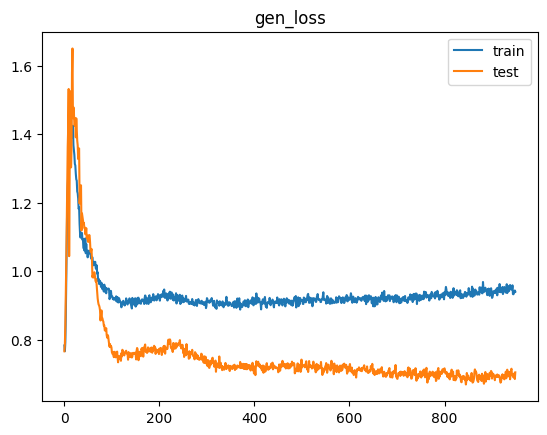

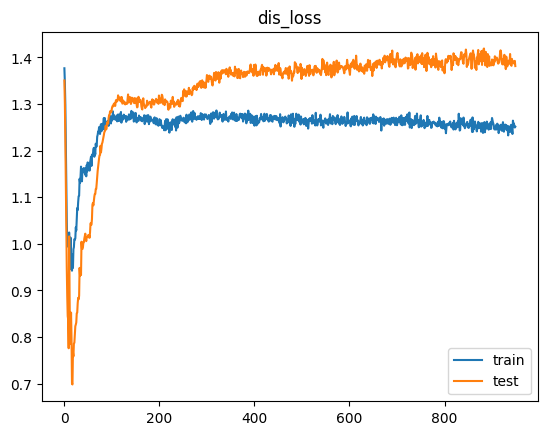

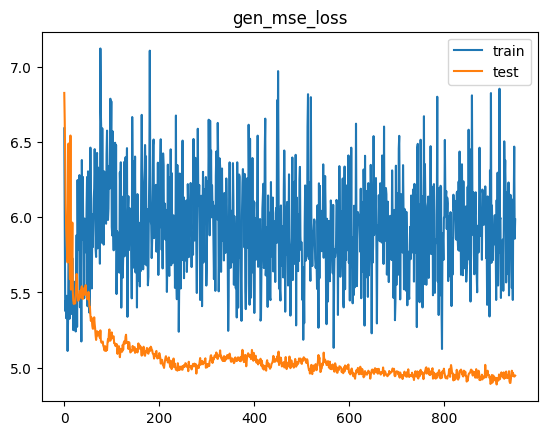

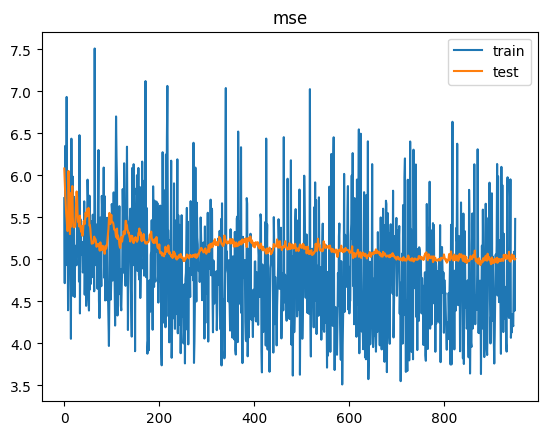

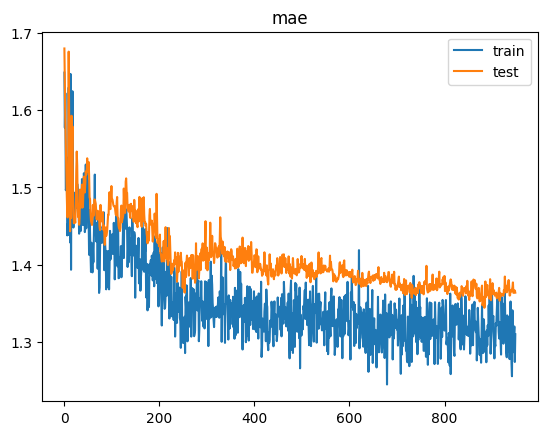

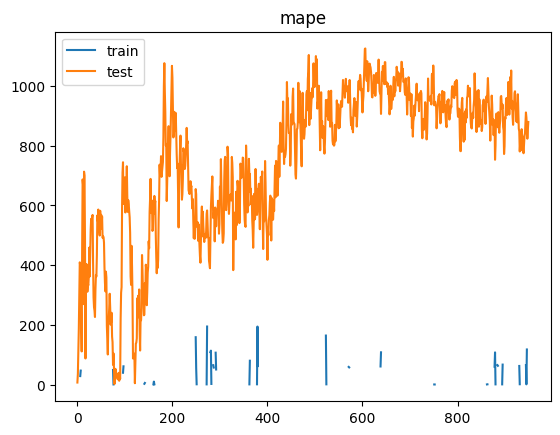

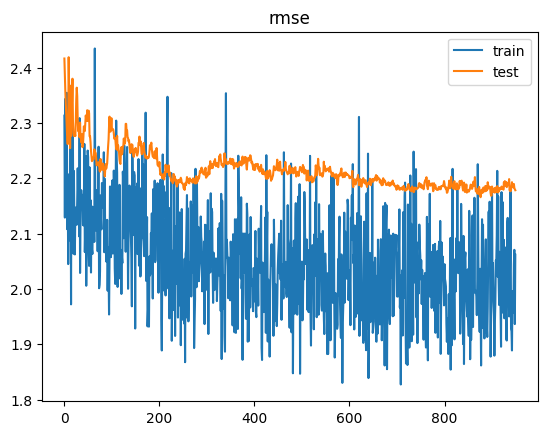

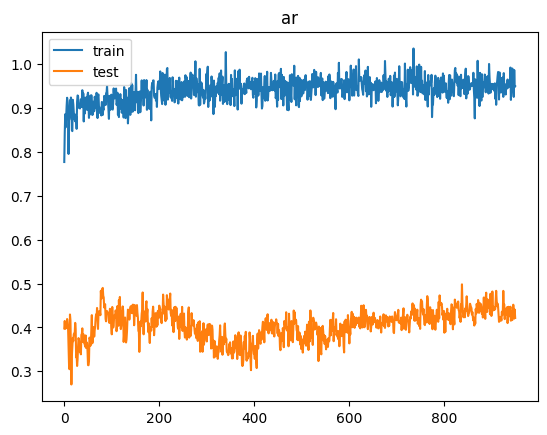

2/2 [==============================] - 0s 4ms/step


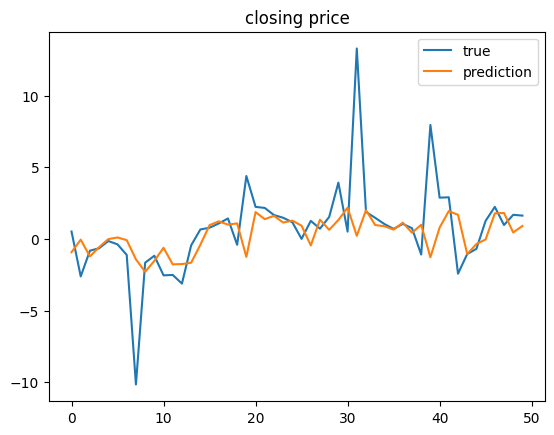

[MSE Baseline] train: 4.335876472759575  test: 5.010967196008289
Delta time with epochs = 950: 0:11:45.366357
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 5, 10)             180       
                                                                 
 batch_normalization_8 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_20 (Dropout)        (None, 5, 10)             0         
                                                                 
 simple_rnn_9 (

Time for epoch 53 is 0.8159568309783936 sec Generator Loss: 1.132003664970398,  Discriminator_loss: 1.1198930740356445
Time for epoch 54 is 0.741161584854126 sec Generator Loss: 1.1281436681747437,  Discriminator_loss: 1.1148682832717896
Time for epoch 55 is 0.7981820106506348 sec Generator Loss: 1.1007376909255981,  Discriminator_loss: 1.1456687450408936
Time for epoch 56 is 0.8667795658111572 sec Generator Loss: 1.119410753250122,  Discriminator_loss: 1.115867257118225
Time for epoch 57 is 0.7926552295684814 sec Generator Loss: 1.0925968885421753,  Discriminator_loss: 1.1390300989151
Time for epoch 58 is 0.703101396560669 sec Generator Loss: 1.090108036994934,  Discriminator_loss: 1.1492079496383667
Time for epoch 59 is 0.7488877773284912 sec Generator Loss: 1.062414288520813,  Discriminator_loss: 1.1737347841262817
Time for epoch 60 is 0.793020486831665 sec Generator Loss: 1.0597258806228638,  Discriminator_loss: 1.1836237907409668
Time for epoch 61 is 0.7663736343383789 sec Generat

Time for epoch 122 is 0.7746539115905762 sec Generator Loss: 0.9000229835510254,  Discriminator_loss: 1.286630392074585
Time for epoch 123 is 0.7642114162445068 sec Generator Loss: 0.9198259711265564,  Discriminator_loss: 1.2853182554244995
Time for epoch 124 is 0.7473940849304199 sec Generator Loss: 0.8894436955451965,  Discriminator_loss: 1.297518253326416
Time for epoch 125 is 0.7520966529846191 sec Generator Loss: 0.9111555814743042,  Discriminator_loss: 1.2828940153121948
Time for epoch 126 is 0.76621413230896 sec Generator Loss: 0.9060596227645874,  Discriminator_loss: 1.2796484231948853
Time for epoch 127 is 0.7372117042541504 sec Generator Loss: 0.9044570922851562,  Discriminator_loss: 1.2851399183273315
Time for epoch 128 is 0.7593252658843994 sec Generator Loss: 0.9098616242408752,  Discriminator_loss: 1.2835195064544678
Time for epoch 129 is 0.7368309497833252 sec Generator Loss: 0.9071794152259827,  Discriminator_loss: 1.2842823266983032
Time for epoch 130 is 0.749894618988

Time for epoch 190 is 0.88374924659729 sec Generator Loss: 0.8959441781044006,  Discriminator_loss: 1.2915672063827515
Time for epoch 191 is 0.8956663608551025 sec Generator Loss: 0.8786761164665222,  Discriminator_loss: 1.3003913164138794
Time for epoch 192 is 0.8792777061462402 sec Generator Loss: 0.8851706385612488,  Discriminator_loss: 1.2977776527404785
Time for epoch 193 is 0.885948896408081 sec Generator Loss: 0.8845101594924927,  Discriminator_loss: 1.3002755641937256
Time for epoch 194 is 0.864377498626709 sec Generator Loss: 0.8762401342391968,  Discriminator_loss: 1.3025765419006348
Time for epoch 195 is 0.8890862464904785 sec Generator Loss: 0.8795711994171143,  Discriminator_loss: 1.3058502674102783
Time for epoch 196 is 0.9145312309265137 sec Generator Loss: 0.8916244506835938,  Discriminator_loss: 1.2927104234695435
Time for epoch 197 is 0.9071793556213379 sec Generator Loss: 0.8813077211380005,  Discriminator_loss: 1.2983759641647339
Time for epoch 198 is 0.889832973480

Time for epoch 259 is 0.8292264938354492 sec Generator Loss: 0.8950806856155396,  Discriminator_loss: 1.2907421588897705
Time for epoch 260 is 0.8068602085113525 sec Generator Loss: 0.8861214518547058,  Discriminator_loss: 1.2930400371551514
Time for epoch 261 is 0.8135886192321777 sec Generator Loss: 0.8769391179084778,  Discriminator_loss: 1.296063780784607
Time for epoch 262 is 0.8043785095214844 sec Generator Loss: 0.8834531903266907,  Discriminator_loss: 1.2923226356506348
Time for epoch 263 is 0.793372392654419 sec Generator Loss: 0.8830295205116272,  Discriminator_loss: 1.2929176092147827
Time for epoch 264 is 0.8059751987457275 sec Generator Loss: 0.8799594044685364,  Discriminator_loss: 1.2930608987808228
Time for epoch 265 is 0.8090169429779053 sec Generator Loss: 0.8882947564125061,  Discriminator_loss: 1.2953640222549438
Time for epoch 266 is 0.8074634075164795 sec Generator Loss: 0.8769773840904236,  Discriminator_loss: 1.2958102226257324
Time for epoch 267 is 0.8097462654

Time for epoch 328 is 0.8754658699035645 sec Generator Loss: 0.8998390436172485,  Discriminator_loss: 1.2848081588745117
Time for epoch 329 is 1.0060679912567139 sec Generator Loss: 0.8901941180229187,  Discriminator_loss: 1.2881145477294922
Time for epoch 330 is 0.9984638690948486 sec Generator Loss: 0.8815063238143921,  Discriminator_loss: 1.3031320571899414
Time for epoch 331 is 0.980924129486084 sec Generator Loss: 0.902080774307251,  Discriminator_loss: 1.2702035903930664
Time for epoch 332 is 1.0098907947540283 sec Generator Loss: 0.897228479385376,  Discriminator_loss: 1.2764869928359985
Time for epoch 333 is 0.9082744121551514 sec Generator Loss: 0.8974990248680115,  Discriminator_loss: 1.2815667390823364
Time for epoch 334 is 0.9197983741760254 sec Generator Loss: 0.8929727077484131,  Discriminator_loss: 1.2697086334228516
Time for epoch 335 is 0.9706802368164062 sec Generator Loss: 0.8982928991317749,  Discriminator_loss: 1.2765865325927734
Time for epoch 336 is 0.93968367576

Time for epoch 396 is 0.9182302951812744 sec Generator Loss: 0.9138062000274658,  Discriminator_loss: 1.2797906398773193
Time for epoch 397 is 0.9023170471191406 sec Generator Loss: 0.9045899510383606,  Discriminator_loss: 1.2762274742126465
Time for epoch 398 is 0.872356653213501 sec Generator Loss: 0.9011145830154419,  Discriminator_loss: 1.2854092121124268
Time for epoch 399 is 0.881223201751709 sec Generator Loss: 0.9035018086433411,  Discriminator_loss: 1.2730793952941895
Time for epoch 400 is 0.9207704067230225 sec Generator Loss: 0.903344452381134,  Discriminator_loss: 1.2753682136535645
Time for epoch 401 is 0.8685438632965088 sec Generator Loss: 0.9000330567359924,  Discriminator_loss: 1.282862663269043
Time for epoch 402 is 0.8772802352905273 sec Generator Loss: 0.9070817828178406,  Discriminator_loss: 1.2610746622085571
Time for epoch 403 is 0.8560404777526855 sec Generator Loss: 0.9188620448112488,  Discriminator_loss: 1.264318585395813
Time for epoch 404 is 0.8349959850311

Time for epoch 465 is 0.7984991073608398 sec Generator Loss: 0.9322982430458069,  Discriminator_loss: 1.2519862651824951
Time for epoch 466 is 0.79305100440979 sec Generator Loss: 0.9270254373550415,  Discriminator_loss: 1.2589715719223022
Time for epoch 467 is 0.7844326496124268 sec Generator Loss: 0.9437822699546814,  Discriminator_loss: 1.2539395093917847
Time for epoch 468 is 0.7761023044586182 sec Generator Loss: 0.9155362248420715,  Discriminator_loss: 1.2643338441848755
Time for epoch 469 is 0.7856686115264893 sec Generator Loss: 0.9188729524612427,  Discriminator_loss: 1.2632018327713013
Time for epoch 470 is 0.7967853546142578 sec Generator Loss: 0.9221900701522827,  Discriminator_loss: 1.2657591104507446
Time for epoch 471 is 0.8321115970611572 sec Generator Loss: 0.94831782579422,  Discriminator_loss: 1.2406917810440063
Time for epoch 472 is 0.895979642868042 sec Generator Loss: 0.9245059490203857,  Discriminator_loss: 1.2662769556045532
Time for epoch 473 is 0.8500721454620

Time for epoch 534 is 0.7675595283508301 sec Generator Loss: 0.9194046854972839,  Discriminator_loss: 1.2624492645263672
Time for epoch 535 is 0.7882330417633057 sec Generator Loss: 0.9248162508010864,  Discriminator_loss: 1.2616254091262817
Time for epoch 536 is 0.7871193885803223 sec Generator Loss: 0.9347580075263977,  Discriminator_loss: 1.2635663747787476
Time for epoch 537 is 0.7981603145599365 sec Generator Loss: 0.9206798076629639,  Discriminator_loss: 1.264162540435791
Time for epoch 538 is 0.828178882598877 sec Generator Loss: 0.9218801259994507,  Discriminator_loss: 1.2563652992248535
Time for epoch 539 is 0.7856314182281494 sec Generator Loss: 0.9308541417121887,  Discriminator_loss: 1.2552345991134644
Time for epoch 540 is 0.7849457263946533 sec Generator Loss: 0.9494055509567261,  Discriminator_loss: 1.2484180927276611
Time for epoch 541 is 0.7738683223724365 sec Generator Loss: 0.9280908703804016,  Discriminator_loss: 1.2523138523101807
Time for epoch 542 is 0.7904477119

Time for epoch 602 is 0.9560291767120361 sec Generator Loss: 0.9488378167152405,  Discriminator_loss: 1.2579282522201538
Time for epoch 603 is 0.9942843914031982 sec Generator Loss: 0.9309312701225281,  Discriminator_loss: 1.255028247833252
Time for epoch 604 is 0.9124314785003662 sec Generator Loss: 0.9363745450973511,  Discriminator_loss: 1.256105661392212
Time for epoch 605 is 0.9686727523803711 sec Generator Loss: 0.9144142866134644,  Discriminator_loss: 1.2658270597457886
Time for epoch 606 is 0.9131269454956055 sec Generator Loss: 0.940401017665863,  Discriminator_loss: 1.2561089992523193
Time for epoch 607 is 0.9279179573059082 sec Generator Loss: 0.9333037734031677,  Discriminator_loss: 1.267107605934143
Time for epoch 608 is 0.9027197360992432 sec Generator Loss: 0.9411748647689819,  Discriminator_loss: 1.2518230676651
Time for epoch 609 is 0.8684051036834717 sec Generator Loss: 0.9243485331535339,  Discriminator_loss: 1.2619304656982422
Time for epoch 610 is 0.876972913742065

Time for epoch 671 is 0.8651173114776611 sec Generator Loss: 0.9231787323951721,  Discriminator_loss: 1.2709615230560303
Time for epoch 672 is 0.8810102939605713 sec Generator Loss: 0.9481158256530762,  Discriminator_loss: 1.2606301307678223
Time for epoch 673 is 0.8713805675506592 sec Generator Loss: 0.9345921874046326,  Discriminator_loss: 1.2690271139144897
Time for epoch 674 is 0.9023380279541016 sec Generator Loss: 0.9352617263793945,  Discriminator_loss: 1.2559762001037598
Time for epoch 675 is 0.8946659564971924 sec Generator Loss: 0.9407156705856323,  Discriminator_loss: 1.264965534210205
Time for epoch 676 is 0.892603874206543 sec Generator Loss: 0.9432591199874878,  Discriminator_loss: 1.2534903287887573
Time for epoch 677 is 0.8849680423736572 sec Generator Loss: 0.931634247303009,  Discriminator_loss: 1.2674187421798706
Time for epoch 678 is 0.9041252136230469 sec Generator Loss: 0.9337332844734192,  Discriminator_loss: 1.2633060216903687
Time for epoch 679 is 0.90981674194

Time for epoch 740 is 0.8152847290039062 sec Generator Loss: 0.9215765595436096,  Discriminator_loss: 1.2681844234466553
Time for epoch 741 is 0.8176801204681396 sec Generator Loss: 0.9400469064712524,  Discriminator_loss: 1.2532597780227661
Time for epoch 742 is 0.8135521411895752 sec Generator Loss: 0.9454549551010132,  Discriminator_loss: 1.2499232292175293
Time for epoch 743 is 0.8010308742523193 sec Generator Loss: 0.9460587501525879,  Discriminator_loss: 1.2524535655975342
Time for epoch 744 is 0.7939913272857666 sec Generator Loss: 0.9493916034698486,  Discriminator_loss: 1.2466627359390259
Time for epoch 745 is 0.8026378154754639 sec Generator Loss: 0.9534680843353271,  Discriminator_loss: 1.2469210624694824
Time for epoch 746 is 0.8043718338012695 sec Generator Loss: 0.9402791857719421,  Discriminator_loss: 1.241549015045166
Time for epoch 747 is 0.818549394607544 sec Generator Loss: 0.9483281373977661,  Discriminator_loss: 1.2643706798553467
Time for epoch 748 is 0.7944581508

Time for epoch 808 is 0.8361308574676514 sec Generator Loss: 0.9484671354293823,  Discriminator_loss: 1.237857699394226
Time for epoch 809 is 0.8878896236419678 sec Generator Loss: 0.9595099091529846,  Discriminator_loss: 1.2456094026565552
Time for epoch 810 is 0.8260793685913086 sec Generator Loss: 0.9441555738449097,  Discriminator_loss: 1.2597875595092773
Time for epoch 811 is 0.8383371829986572 sec Generator Loss: 0.9540284872055054,  Discriminator_loss: 1.2579381465911865
Time for epoch 812 is 0.851060152053833 sec Generator Loss: 0.9464321136474609,  Discriminator_loss: 1.255370855331421
Time for epoch 813 is 0.8552467823028564 sec Generator Loss: 0.9336627721786499,  Discriminator_loss: 1.2576000690460205
Time for epoch 814 is 0.8926205635070801 sec Generator Loss: 0.9463122487068176,  Discriminator_loss: 1.2433631420135498
Time for epoch 815 is 2.203016996383667 sec Generator Loss: 0.9412364959716797,  Discriminator_loss: 1.2621612548828125
Time for epoch 816 is 0.862252712249

Time for epoch 877 is 0.9217360019683838 sec Generator Loss: 0.9525416493415833,  Discriminator_loss: 1.251476764678955
Time for epoch 878 is 0.8720114231109619 sec Generator Loss: 0.9585490226745605,  Discriminator_loss: 1.2347440719604492
Time for epoch 879 is 0.90781569480896 sec Generator Loss: 0.9409080147743225,  Discriminator_loss: 1.2555428743362427
Time for epoch 880 is 0.853369951248169 sec Generator Loss: 0.9516739845275879,  Discriminator_loss: 1.2444897890090942
Time for epoch 881 is 0.897904634475708 sec Generator Loss: 0.957611083984375,  Discriminator_loss: 1.2426671981811523
Time for epoch 882 is 0.9061989784240723 sec Generator Loss: 0.9611743092536926,  Discriminator_loss: 1.2448707818984985
Time for epoch 883 is 0.8463146686553955 sec Generator Loss: 0.9579152464866638,  Discriminator_loss: 1.2533413171768188
Time for epoch 884 is 0.8644833564758301 sec Generator Loss: 0.9559648633003235,  Discriminator_loss: 1.234833836555481
Time for epoch 885 is 0.847098588943481

Time for epoch 946 is 0.8151710033416748 sec Generator Loss: 0.9427043795585632,  Discriminator_loss: 1.2425780296325684
Time for epoch 947 is 0.8319158554077148 sec Generator Loss: 0.9488336443901062,  Discriminator_loss: 1.2468929290771484
Time for epoch 948 is 0.8259322643280029 sec Generator Loss: 0.9554816484451294,  Discriminator_loss: 1.2454553842544556
Time for epoch 949 is 0.79958176612854 sec Generator Loss: 0.9550723433494568,  Discriminator_loss: 1.2361773252487183
Time for epoch 950 is 0.8113322257995605 sec Generator Loss: 0.9639886617660522,  Discriminator_loss: 1.2441480159759521
Time for epoch 951 is 0.8393466472625732 sec Generator Loss: 0.9640399813652039,  Discriminator_loss: 1.2372912168502808
Time for epoch 952 is 0.8136508464813232 sec Generator Loss: 0.9720323085784912,  Discriminator_loss: 1.2340868711471558
Time for epoch 953 is 0.8151125907897949 sec Generator Loss: 0.9647948145866394,  Discriminator_loss: 1.2539958953857422
Time for epoch 954 is 0.8024163246

Time for epoch 1014 is 0.8363361358642578 sec Generator Loss: 0.9549058079719543,  Discriminator_loss: 1.2424368858337402
Time for epoch 1015 is 0.8541209697723389 sec Generator Loss: 0.9846050143241882,  Discriminator_loss: 1.2254503965377808
Time for epoch 1016 is 0.8224368095397949 sec Generator Loss: 0.9818382859230042,  Discriminator_loss: 1.2334297895431519
Time for epoch 1017 is 0.8344697952270508 sec Generator Loss: 0.9771798253059387,  Discriminator_loss: 1.2407993078231812
Time for epoch 1018 is 0.8276693820953369 sec Generator Loss: 0.9728394746780396,  Discriminator_loss: 1.2391767501831055
Time for epoch 1019 is 0.8379189968109131 sec Generator Loss: 0.9552549123764038,  Discriminator_loss: 1.252439260482788
Time for epoch 1020 is 0.8513908386230469 sec Generator Loss: 0.969196081161499,  Discriminator_loss: 1.232283115386963
Time for epoch 1021 is 0.852780818939209 sec Generator Loss: 0.9639747142791748,  Discriminator_loss: 1.241327166557312
Time for epoch 1022 is 0.8322

In [ ]:
for epochs in [200, 450, 700, 950]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("rnn_ffnn_epochs_{0}.h5".format(epochs))

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 5, 7)]            0         
                                                                 
 simple_rnn_20 (SimpleRNN)   (None, 5, 10)             180       
                                                                 
 batch_normalization_20 (Bat  (None, 5, 10)            40        
 chNormalization)                                                
                                                                 
 leaky_re_lu_60 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_50 (Dropout)        (None, 5, 10)             0         
                                                                 
 simple_rnn_21 (SimpleRNN)   (None, 10)                210       
                                                          

Time for epoch 54 is 1.28118896484375 sec Generator Loss: 0.9907901287078857,  Discriminator_loss: 1.224727988243103
Time for epoch 55 is 1.4628474712371826 sec Generator Loss: 0.9768193960189819,  Discriminator_loss: 1.2146731615066528
Time for epoch 56 is 1.3477883338928223 sec Generator Loss: 0.9862916469573975,  Discriminator_loss: 1.2216273546218872
Time for epoch 57 is 1.412339448928833 sec Generator Loss: 0.9804720282554626,  Discriminator_loss: 1.2356526851654053
Time for epoch 58 is 1.3004825115203857 sec Generator Loss: 0.9799497723579407,  Discriminator_loss: 1.2457151412963867
Time for epoch 59 is 1.645796537399292 sec Generator Loss: 0.9682788848876953,  Discriminator_loss: 1.2469617128372192
Time for epoch 60 is 1.4095075130462646 sec Generator Loss: 0.9479847550392151,  Discriminator_loss: 1.2550572156906128
Time for epoch 61 is 1.5189781188964844 sec Generator Loss: 0.9514197707176208,  Discriminator_loss: 1.256368637084961
Time for epoch 62 is 1.421764612197876 sec Gen

Time for epoch 123 is 1.323439121246338 sec Generator Loss: 0.8837291598320007,  Discriminator_loss: 1.2992380857467651
Time for epoch 124 is 1.4277355670928955 sec Generator Loss: 0.8786460757255554,  Discriminator_loss: 1.3081179857254028
Time for epoch 125 is 1.3401267528533936 sec Generator Loss: 0.8840771317481995,  Discriminator_loss: 1.304291009902954
Time for epoch 126 is 1.295454502105713 sec Generator Loss: 0.8743457794189453,  Discriminator_loss: 1.3037958145141602
Time for epoch 127 is 1.2535059452056885 sec Generator Loss: 0.8733144402503967,  Discriminator_loss: 1.2998820543289185
Time for epoch 128 is 1.2786331176757812 sec Generator Loss: 0.8736531138420105,  Discriminator_loss: 1.3049190044403076
Time for epoch 129 is 1.4200801849365234 sec Generator Loss: 0.8726567625999451,  Discriminator_loss: 1.3112484216690063
Time for epoch 130 is 1.3278303146362305 sec Generator Loss: 0.8662270903587341,  Discriminator_loss: 1.3104286193847656
Time for epoch 131 is 1.27526855468

Time for epoch 192 is 1.3892195224761963 sec Generator Loss: 0.8397353887557983,  Discriminator_loss: 1.3191314935684204
Time for epoch 193 is 1.3810133934020996 sec Generator Loss: 0.8514152765274048,  Discriminator_loss: 1.318885326385498
Time for epoch 194 is 1.432267665863037 sec Generator Loss: 0.8541692495346069,  Discriminator_loss: 1.3022032976150513
Time for epoch 195 is 1.4580566883087158 sec Generator Loss: 0.853668212890625,  Discriminator_loss: 1.3074711561203003
Time for epoch 196 is 1.3629086017608643 sec Generator Loss: 0.858472466468811,  Discriminator_loss: 1.3069809675216675
Time for epoch 197 is 1.284438133239746 sec Generator Loss: 0.8564000129699707,  Discriminator_loss: 1.3142157793045044
Time for epoch 198 is 1.2746829986572266 sec Generator Loss: 0.8575882911682129,  Discriminator_loss: 1.3119763135910034
Time for epoch 199 is 1.4772112369537354 sec Generator Loss: 0.8451429605484009,  Discriminator_loss: 1.3116252422332764
Time for epoch 200 is 1.3870763778686

Time for epoch 261 is 1.4013242721557617 sec Generator Loss: 0.8538075089454651,  Discriminator_loss: 1.3088186979293823
Time for epoch 262 is 1.311490774154663 sec Generator Loss: 0.8523484468460083,  Discriminator_loss: 1.3065203428268433
Time for epoch 263 is 1.2049238681793213 sec Generator Loss: 0.8597042560577393,  Discriminator_loss: 1.3045964241027832
Time for epoch 264 is 1.2472503185272217 sec Generator Loss: 0.852348268032074,  Discriminator_loss: 1.3122873306274414
Time for epoch 265 is 1.2833847999572754 sec Generator Loss: 0.8595317006111145,  Discriminator_loss: 1.3031196594238281
Time for epoch 266 is 1.2442986965179443 sec Generator Loss: 0.8550878167152405,  Discriminator_loss: 1.301946997642517
Time for epoch 267 is 1.2053043842315674 sec Generator Loss: 0.8613620400428772,  Discriminator_loss: 1.305090308189392
Time for epoch 268 is 1.2222654819488525 sec Generator Loss: 0.8601535558700562,  Discriminator_loss: 1.3007146120071411
Time for epoch 269 is 1.394076108932

Time for epoch 330 is 1.3454701900482178 sec Generator Loss: 0.8648431301116943,  Discriminator_loss: 1.3058083057403564
Time for epoch 331 is 1.2831737995147705 sec Generator Loss: 0.8705582022666931,  Discriminator_loss: 1.3033283948898315
Time for epoch 332 is 1.3714194297790527 sec Generator Loss: 0.8702828884124756,  Discriminator_loss: 1.305565595626831
Time for epoch 333 is 1.248772144317627 sec Generator Loss: 0.8693116307258606,  Discriminator_loss: 1.3079134225845337
Time for epoch 334 is 1.2915103435516357 sec Generator Loss: 0.8600931167602539,  Discriminator_loss: 1.317165732383728
Time for epoch 335 is 1.4435570240020752 sec Generator Loss: 0.8616510629653931,  Discriminator_loss: 1.3121403455734253
Time for epoch 336 is 1.3417613506317139 sec Generator Loss: 0.8769040703773499,  Discriminator_loss: 1.295586109161377
Time for epoch 337 is 1.3588840961456299 sec Generator Loss: 0.8619515299797058,  Discriminator_loss: 1.3055988550186157
Time for epoch 338 is 1.256147861480

Time for epoch 399 is 1.4298453330993652 sec Generator Loss: 0.8858847618103027,  Discriminator_loss: 1.2795159816741943
Time for epoch 400 is 1.2880425453186035 sec Generator Loss: 0.8661620020866394,  Discriminator_loss: 1.3039088249206543
Time for epoch 401 is 1.3109567165374756 sec Generator Loss: 0.8707913160324097,  Discriminator_loss: 1.2981433868408203
Time for epoch 402 is 1.2705626487731934 sec Generator Loss: 0.8639661073684692,  Discriminator_loss: 1.2989020347595215
Time for epoch 403 is 1.3014233112335205 sec Generator Loss: 0.8838492035865784,  Discriminator_loss: 1.2924498319625854
Time for epoch 404 is 1.290191650390625 sec Generator Loss: 0.8793525695800781,  Discriminator_loss: 1.2921411991119385
Time for epoch 405 is 1.2862694263458252 sec Generator Loss: 0.8785276412963867,  Discriminator_loss: 1.2900114059448242
Time for epoch 406 is 1.290153980255127 sec Generator Loss: 0.8711407780647278,  Discriminator_loss: 1.2956628799438477
Time for epoch 407 is 1.2356503009

Time for epoch 468 is 1.407527208328247 sec Generator Loss: 0.8825979828834534,  Discriminator_loss: 1.2946804761886597
Time for epoch 469 is 1.2771949768066406 sec Generator Loss: 0.8771896958351135,  Discriminator_loss: 1.2881546020507812
Time for epoch 470 is 1.251267910003662 sec Generator Loss: 0.8793522715568542,  Discriminator_loss: 1.2905197143554688
Time for epoch 471 is 1.2495660781860352 sec Generator Loss: 0.8863124847412109,  Discriminator_loss: 1.288902997970581
Time for epoch 472 is 1.3772876262664795 sec Generator Loss: 0.8853198885917664,  Discriminator_loss: 1.2828633785247803
Time for epoch 473 is 1.2459239959716797 sec Generator Loss: 0.8798525333404541,  Discriminator_loss: 1.295344591140747
Time for epoch 474 is 1.2463843822479248 sec Generator Loss: 0.889234185218811,  Discriminator_loss: 1.2897602319717407
Time for epoch 475 is 1.2268474102020264 sec Generator Loss: 0.8953339457511902,  Discriminator_loss: 1.283198356628418
Time for epoch 476 is 1.21447873115539

Time for epoch 537 is 1.2653212547302246 sec Generator Loss: 0.9036225080490112,  Discriminator_loss: 1.2805709838867188
Time for epoch 538 is 1.515078067779541 sec Generator Loss: 0.9074231386184692,  Discriminator_loss: 1.2763361930847168
Time for epoch 539 is 1.6390583515167236 sec Generator Loss: 0.9066928029060364,  Discriminator_loss: 1.2814433574676514
Time for epoch 540 is 1.3635776042938232 sec Generator Loss: 0.910804271697998,  Discriminator_loss: 1.2740864753723145
Time for epoch 541 is 1.31789231300354 sec Generator Loss: 0.9048675894737244,  Discriminator_loss: 1.2813721895217896
Time for epoch 542 is 1.308182954788208 sec Generator Loss: 0.9027420878410339,  Discriminator_loss: 1.2769215106964111
Time for epoch 543 is 1.289961338043213 sec Generator Loss: 0.9084774851799011,  Discriminator_loss: 1.2726774215698242
Time for epoch 544 is 1.2766623497009277 sec Generator Loss: 0.9147700071334839,  Discriminator_loss: 1.2722820043563843
Time for epoch 545 is 1.26423668861389

Time for epoch 606 is 1.2426080703735352 sec Generator Loss: 0.9079795479774475,  Discriminator_loss: 1.2890665531158447
Time for epoch 607 is 1.2829322814941406 sec Generator Loss: 0.9040150046348572,  Discriminator_loss: 1.2788487672805786
Time for epoch 608 is 1.288970708847046 sec Generator Loss: 0.9074983596801758,  Discriminator_loss: 1.2767245769500732
Time for epoch 609 is 1.3186912536621094 sec Generator Loss: 0.9059656262397766,  Discriminator_loss: 1.2683314085006714
Time for epoch 610 is 1.286107063293457 sec Generator Loss: 0.9100623726844788,  Discriminator_loss: 1.2712904214859009
Time for epoch 611 is 1.2829298973083496 sec Generator Loss: 0.9095920324325562,  Discriminator_loss: 1.2682461738586426
Time for epoch 612 is 1.3025014400482178 sec Generator Loss: 0.9126858115196228,  Discriminator_loss: 1.2703711986541748
Time for epoch 613 is 1.4179279804229736 sec Generator Loss: 0.8938145637512207,  Discriminator_loss: 1.2811875343322754
Time for epoch 614 is 1.2857408523

Time for epoch 674 is 1.2803213596343994 sec Generator Loss: 0.9336957335472107,  Discriminator_loss: 1.2671828269958496
Time for epoch 675 is 1.338644027709961 sec Generator Loss: 0.9158402681350708,  Discriminator_loss: 1.273102045059204
Time for epoch 676 is 1.243051528930664 sec Generator Loss: 0.899917483329773,  Discriminator_loss: 1.2759206295013428
Time for epoch 677 is 1.2239434719085693 sec Generator Loss: 0.9050717949867249,  Discriminator_loss: 1.2735588550567627
Time for epoch 678 is 1.2312476634979248 sec Generator Loss: 0.8999278545379639,  Discriminator_loss: 1.282065510749817
Time for epoch 679 is 1.2220633029937744 sec Generator Loss: 0.9260705709457397,  Discriminator_loss: 1.2608156204223633
Time for epoch 680 is 1.2480549812316895 sec Generator Loss: 0.9246294498443604,  Discriminator_loss: 1.2655147314071655
Time for epoch 681 is 1.3414735794067383 sec Generator Loss: 0.9166594743728638,  Discriminator_loss: 1.2705250978469849
Time for epoch 682 is 1.2876136302947

Time for epoch 743 is 1.3049037456512451 sec Generator Loss: 0.9219648241996765,  Discriminator_loss: 1.265889286994934
Time for epoch 744 is 1.2666807174682617 sec Generator Loss: 0.9246045351028442,  Discriminator_loss: 1.271405816078186
Time for epoch 745 is 1.2119066715240479 sec Generator Loss: 0.9265445470809937,  Discriminator_loss: 1.2728526592254639
Time for epoch 746 is 1.2718329429626465 sec Generator Loss: 0.9223802089691162,  Discriminator_loss: 1.2708933353424072
Time for epoch 747 is 1.3086791038513184 sec Generator Loss: 0.9246593713760376,  Discriminator_loss: 1.2647169828414917
Time for epoch 748 is 1.2160193920135498 sec Generator Loss: 0.9361026287078857,  Discriminator_loss: 1.2556695938110352
Time for epoch 749 is 1.2201173305511475 sec Generator Loss: 0.928818941116333,  Discriminator_loss: 1.2647494077682495
Time for epoch 750 is 1.2140069007873535 sec Generator Loss: 0.9201833009719849,  Discriminator_loss: 1.2656534910202026
Time for epoch 751 is 1.23669528961

Time for epoch 812 is 1.3574652671813965 sec Generator Loss: 0.9412598013877869,  Discriminator_loss: 1.2658450603485107
Time for epoch 813 is 1.3008167743682861 sec Generator Loss: 0.9182144999504089,  Discriminator_loss: 1.2659474611282349
Time for epoch 814 is 1.461294174194336 sec Generator Loss: 0.9374457001686096,  Discriminator_loss: 1.2579193115234375
Time for epoch 815 is 1.5265719890594482 sec Generator Loss: 0.9257200956344604,  Discriminator_loss: 1.2691411972045898
Time for epoch 816 is 1.4312717914581299 sec Generator Loss: 0.9199298620223999,  Discriminator_loss: 1.2663779258728027
Time for epoch 817 is 1.3015244007110596 sec Generator Loss: 0.9304256439208984,  Discriminator_loss: 1.2663686275482178
Time for epoch 818 is 1.4873239994049072 sec Generator Loss: 0.9352725744247437,  Discriminator_loss: 1.257082462310791
Time for epoch 819 is 1.3899240493774414 sec Generator Loss: 0.922508955001831,  Discriminator_loss: 1.269756555557251
Time for epoch 820 is 1.297590017318

Time for epoch 881 is 1.2164661884307861 sec Generator Loss: 0.9391285181045532,  Discriminator_loss: 1.2655069828033447
Time for epoch 882 is 1.1927714347839355 sec Generator Loss: 0.9281845092773438,  Discriminator_loss: 1.274532437324524
Time for epoch 883 is 1.2886476516723633 sec Generator Loss: 0.9359630942344666,  Discriminator_loss: 1.2547260522842407
Time for epoch 884 is 1.222792625427246 sec Generator Loss: 0.9378193020820618,  Discriminator_loss: 1.2609977722167969
Time for epoch 885 is 1.2150087356567383 sec Generator Loss: 0.9421377778053284,  Discriminator_loss: 1.2478383779525757
Time for epoch 886 is 1.2209842205047607 sec Generator Loss: 0.9367964863777161,  Discriminator_loss: 1.2588361501693726
Time for epoch 887 is 1.2895917892456055 sec Generator Loss: 0.9445191025733948,  Discriminator_loss: 1.2511768341064453
Time for epoch 888 is 1.3195080757141113 sec Generator Loss: 0.9433106184005737,  Discriminator_loss: 1.254089593887329
Time for epoch 889 is 1.22361254692

Time for epoch 950 is 1.2302467823028564 sec Generator Loss: 0.9310660362243652,  Discriminator_loss: 1.2676122188568115
Time for epoch 951 is 1.2349774837493896 sec Generator Loss: 0.9282450675964355,  Discriminator_loss: 1.2620075941085815
Time for epoch 952 is 1.2612147331237793 sec Generator Loss: 0.9270356893539429,  Discriminator_loss: 1.2630804777145386
Time for epoch 953 is 1.2289764881134033 sec Generator Loss: 0.9333057403564453,  Discriminator_loss: 1.2593047618865967
Time for epoch 954 is 1.2105731964111328 sec Generator Loss: 0.9285749197006226,  Discriminator_loss: 1.2689950466156006
Time for epoch 955 is 1.2410249710083008 sec Generator Loss: 0.9286384582519531,  Discriminator_loss: 1.2683402299880981
Time for epoch 956 is 1.220794677734375 sec Generator Loss: 0.941619336605072,  Discriminator_loss: 1.248612880706787
Time for epoch 957 is 1.2304811477661133 sec Generator Loss: 0.9299219846725464,  Discriminator_loss: 1.2721489667892456
Time for epoch 958 is 1.23098802566

Time for epoch 1018 is 1.2816119194030762 sec Generator Loss: 0.9337103962898254,  Discriminator_loss: 1.267199993133545
Time for epoch 1019 is 1.3892183303833008 sec Generator Loss: 0.9333744645118713,  Discriminator_loss: 1.2698869705200195
Time for epoch 1020 is 1.2852935791015625 sec Generator Loss: 0.9250516891479492,  Discriminator_loss: 1.2751983404159546
Time for epoch 1021 is 1.2546088695526123 sec Generator Loss: 0.9446309804916382,  Discriminator_loss: 1.2524354457855225
Time for epoch 1022 is 1.2641215324401855 sec Generator Loss: 0.9327965378761292,  Discriminator_loss: 1.2627867460250854
Time for epoch 1023 is 1.2981195449829102 sec Generator Loss: 0.927273154258728,  Discriminator_loss: 1.2633082866668701
Time for epoch 1024 is 1.2464275360107422 sec Generator Loss: 0.9278071522712708,  Discriminator_loss: 1.2780535221099854
Time for epoch 1025 is 1.258052110671997 sec Generator Loss: 0.9352777600288391,  Discriminator_loss: 1.2579286098480225
Time for epoch 1026 is 1.25

Time for epoch 1086 is 1.2455577850341797 sec Generator Loss: 0.9261896014213562,  Discriminator_loss: 1.270057201385498
Time for epoch 1087 is 1.314634084701538 sec Generator Loss: 0.9543988704681396,  Discriminator_loss: 1.2590205669403076
Time for epoch 1088 is 1.239354133605957 sec Generator Loss: 0.9537405371665955,  Discriminator_loss: 1.2548269033432007
Time for epoch 1089 is 1.244887113571167 sec Generator Loss: 0.9568890333175659,  Discriminator_loss: 1.2409900426864624
Time for epoch 1090 is 1.230104684829712 sec Generator Loss: 0.9429946541786194,  Discriminator_loss: 1.2571076154708862
Time for epoch 1091 is 1.2308592796325684 sec Generator Loss: 0.9459125399589539,  Discriminator_loss: 1.2517662048339844
Time for epoch 1092 is 1.2365405559539795 sec Generator Loss: 0.9234521985054016,  Discriminator_loss: 1.2659950256347656
Time for epoch 1093 is 1.264512062072754 sec Generator Loss: 0.9519423842430115,  Discriminator_loss: 1.254673957824707
Time for epoch 1094 is 1.229655

Time for epoch 1154 is 1.2676093578338623 sec Generator Loss: 0.9497561454772949,  Discriminator_loss: 1.2532987594604492
Time for epoch 1155 is 1.2412006855010986 sec Generator Loss: 0.9417580366134644,  Discriminator_loss: 1.2516001462936401
Time for epoch 1156 is 1.251244068145752 sec Generator Loss: 0.9555709958076477,  Discriminator_loss: 1.249232530593872
Time for epoch 1157 is 1.2526562213897705 sec Generator Loss: 0.9366046190261841,  Discriminator_loss: 1.2633333206176758
Time for epoch 1158 is 1.3670287132263184 sec Generator Loss: 0.9293149709701538,  Discriminator_loss: 1.272306203842163
Time for epoch 1159 is 1.2403976917266846 sec Generator Loss: 0.9406576752662659,  Discriminator_loss: 1.2582210302352905
Time for epoch 1160 is 1.241431474685669 sec Generator Loss: 0.9315389394760132,  Discriminator_loss: 1.2624355554580688
Time for epoch 1161 is 1.3125059604644775 sec Generator Loss: 0.9453480839729309,  Discriminator_loss: 1.259029507637024
Time for epoch 1162 is 1.3713

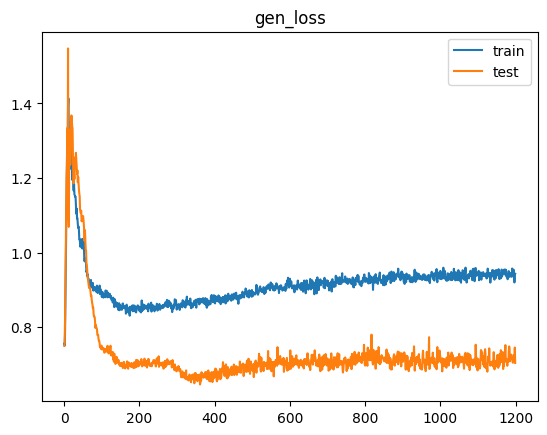

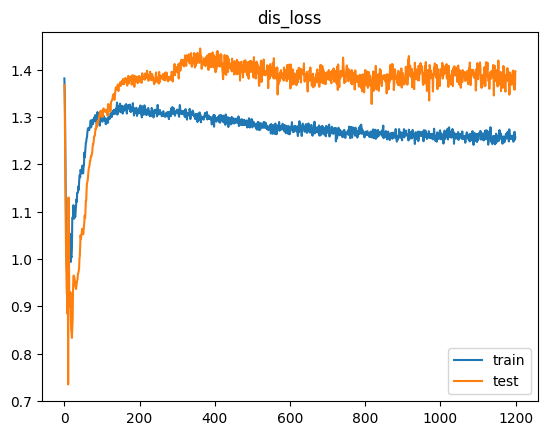

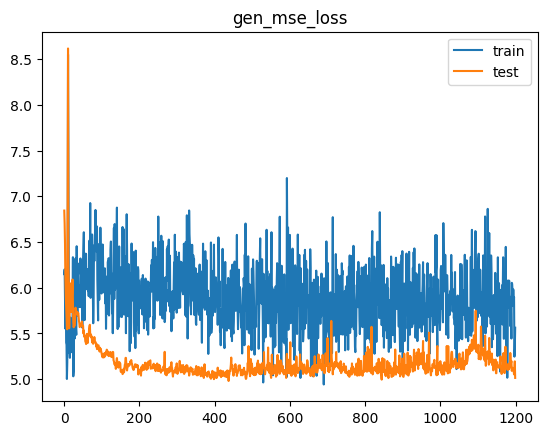

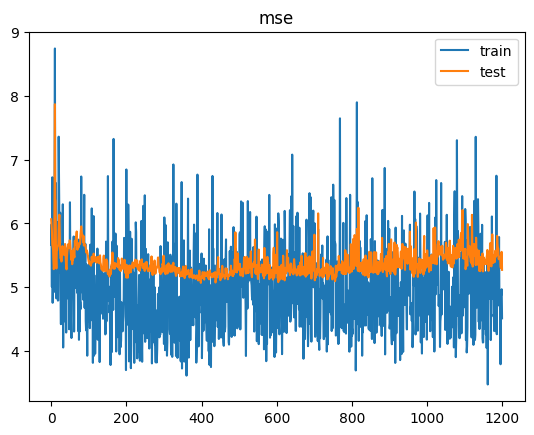

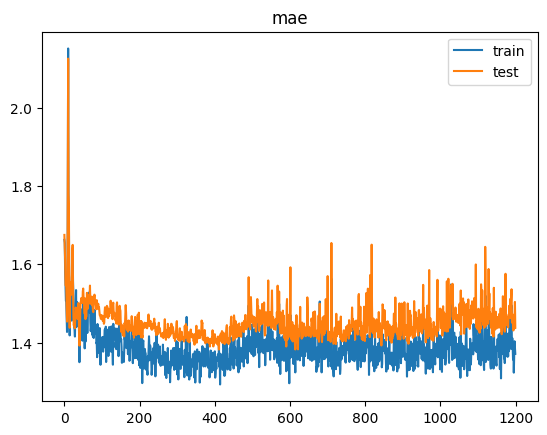

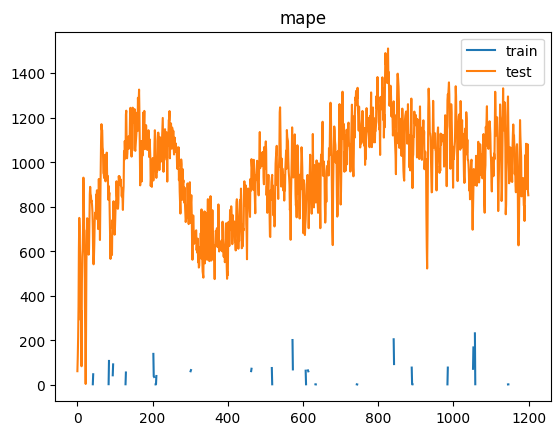

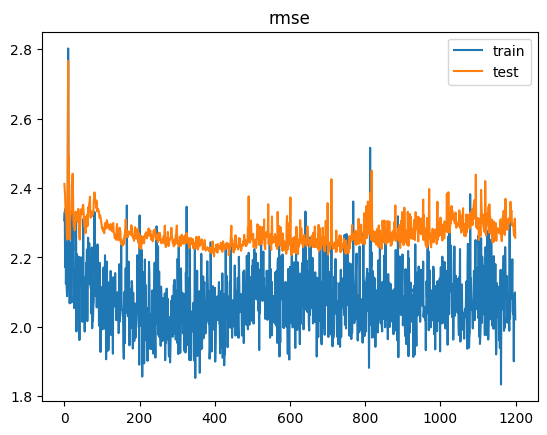

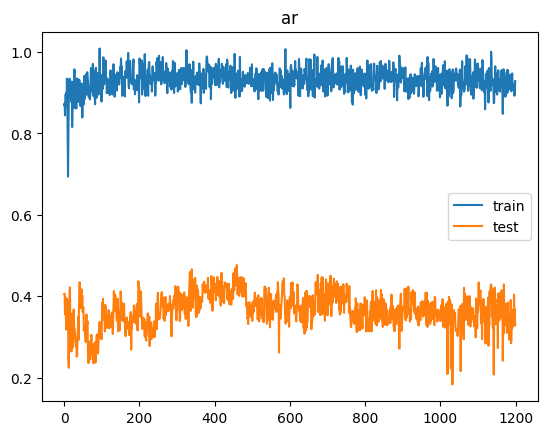

2/2 [==============================] - 0s 6ms/step


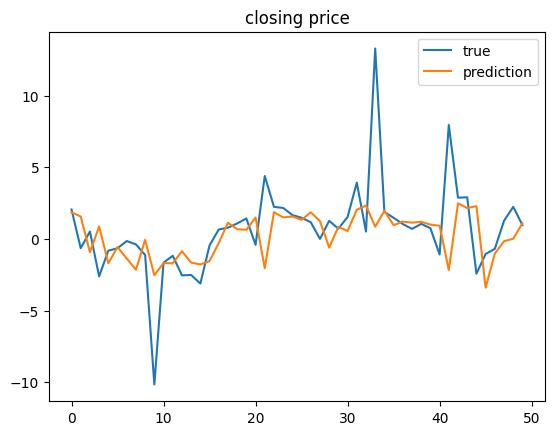

[MSE Baseline] train: 4.286281310798412  test: 4.988566607603537
Delta time with epochs = 1200: 0:26:12.712994
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 5, 7)]            0         
                                                                 
 simple_rnn_22 (SimpleRNN)   (None, 5, 10)             180       
                                                                 
 batch_normalization_22 (Bat  (None, 5, 10)            40        
 chNormalization)                                                
                                                                 
 leaky_re_lu_66 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_55 (Dropout)        (None, 5, 10)             0         
                                                                 
 simple_rnn_2

Time for epoch 53 is 1.209968090057373 sec Generator Loss: 1.0069146156311035,  Discriminator_loss: 1.1962878704071045
Time for epoch 54 is 1.2382910251617432 sec Generator Loss: 0.9922804832458496,  Discriminator_loss: 1.220231056213379
Time for epoch 55 is 1.2156786918640137 sec Generator Loss: 0.9880523681640625,  Discriminator_loss: 1.2076581716537476
Time for epoch 56 is 1.2925634384155273 sec Generator Loss: 0.9834699034690857,  Discriminator_loss: 1.2159225940704346
Time for epoch 57 is 1.2364068031311035 sec Generator Loss: 0.9928028583526611,  Discriminator_loss: 1.226374864578247
Time for epoch 58 is 1.2624216079711914 sec Generator Loss: 0.9730035662651062,  Discriminator_loss: 1.2350355386734009
Time for epoch 59 is 1.224034070968628 sec Generator Loss: 0.9889739155769348,  Discriminator_loss: 1.2199604511260986
Time for epoch 60 is 1.2459971904754639 sec Generator Loss: 0.9733039140701294,  Discriminator_loss: 1.2221392393112183
Time for epoch 61 is 1.2383275032043457 sec 

Time for epoch 122 is 1.206099510192871 sec Generator Loss: 0.8865664601325989,  Discriminator_loss: 1.2818360328674316
Time for epoch 123 is 1.2076411247253418 sec Generator Loss: 0.8956982493400574,  Discriminator_loss: 1.2883867025375366
Time for epoch 124 is 1.2179229259490967 sec Generator Loss: 0.8896169066429138,  Discriminator_loss: 1.2939214706420898
Time for epoch 125 is 1.2252357006072998 sec Generator Loss: 0.8781945705413818,  Discriminator_loss: 1.2890069484710693
Time for epoch 126 is 1.2278058528900146 sec Generator Loss: 0.8788846731185913,  Discriminator_loss: 1.3011064529418945
Time for epoch 127 is 1.348848819732666 sec Generator Loss: 0.8873664140701294,  Discriminator_loss: 1.2815721035003662
Time for epoch 128 is 1.2792949676513672 sec Generator Loss: 0.8846794962882996,  Discriminator_loss: 1.27984619140625
Time for epoch 129 is 1.414621353149414 sec Generator Loss: 0.8737620711326599,  Discriminator_loss: 1.2954238653182983
Time for epoch 130 is 1.3097307682037

Time for epoch 191 is 1.2599396705627441 sec Generator Loss: 0.8627504706382751,  Discriminator_loss: 1.299992322921753
Time for epoch 192 is 1.2130601406097412 sec Generator Loss: 0.8654207587242126,  Discriminator_loss: 1.2904396057128906
Time for epoch 193 is 1.2450358867645264 sec Generator Loss: 0.8589036464691162,  Discriminator_loss: 1.3075343370437622
Time for epoch 194 is 1.2322251796722412 sec Generator Loss: 0.862158477306366,  Discriminator_loss: 1.2927221059799194
Time for epoch 195 is 1.264735460281372 sec Generator Loss: 0.8569411039352417,  Discriminator_loss: 1.3023444414138794
Time for epoch 196 is 1.3512122631072998 sec Generator Loss: 0.8624405264854431,  Discriminator_loss: 1.2976065874099731
Time for epoch 197 is 1.2877464294433594 sec Generator Loss: 0.8620337843894958,  Discriminator_loss: 1.2985769510269165
Time for epoch 198 is 1.3219754695892334 sec Generator Loss: 0.853829562664032,  Discriminator_loss: 1.3110920190811157
Time for epoch 199 is 1.292738676071

Time for epoch 260 is 1.2075622081756592 sec Generator Loss: 0.8455590605735779,  Discriminator_loss: 1.317561388015747
Time for epoch 261 is 1.2034010887145996 sec Generator Loss: 0.8471435308456421,  Discriminator_loss: 1.3116241693496704
Time for epoch 262 is 1.1898772716522217 sec Generator Loss: 0.8490042090415955,  Discriminator_loss: 1.3118706941604614
Time for epoch 263 is 1.1949481964111328 sec Generator Loss: 0.8457409739494324,  Discriminator_loss: 1.3245577812194824
Time for epoch 264 is 1.1896169185638428 sec Generator Loss: 0.8383558988571167,  Discriminator_loss: 1.3225773572921753
Time for epoch 265 is 1.188209056854248 sec Generator Loss: 0.8414514660835266,  Discriminator_loss: 1.3149311542510986
Time for epoch 266 is 1.2337021827697754 sec Generator Loss: 0.8447530269622803,  Discriminator_loss: 1.3158000707626343
Time for epoch 267 is 1.2044098377227783 sec Generator Loss: 0.8456262946128845,  Discriminator_loss: 1.3282071352005005
Time for epoch 268 is 1.1857261657

Time for epoch 329 is 1.3925225734710693 sec Generator Loss: 0.8566341400146484,  Discriminator_loss: 1.3099915981292725
Time for epoch 330 is 1.389822244644165 sec Generator Loss: 0.8459787368774414,  Discriminator_loss: 1.312820315361023
Time for epoch 331 is 1.4195425510406494 sec Generator Loss: 0.858400821685791,  Discriminator_loss: 1.3023430109024048
Time for epoch 332 is 1.4379103183746338 sec Generator Loss: 0.8601107001304626,  Discriminator_loss: 1.307462215423584
Time for epoch 333 is 1.347686767578125 sec Generator Loss: 0.8493335843086243,  Discriminator_loss: 1.305706262588501
Time for epoch 334 is 1.496018886566162 sec Generator Loss: 0.8585883378982544,  Discriminator_loss: 1.3078135251998901
Time for epoch 335 is 1.4928016662597656 sec Generator Loss: 0.8549031615257263,  Discriminator_loss: 1.3086555004119873
Time for epoch 336 is 1.4627618789672852 sec Generator Loss: 0.8589356541633606,  Discriminator_loss: 1.307665467262268
Time for epoch 337 is 1.5722827911376953

Time for epoch 398 is 1.2750141620635986 sec Generator Loss: 0.8590365648269653,  Discriminator_loss: 1.3104221820831299
Time for epoch 399 is 1.377077341079712 sec Generator Loss: 0.8561833500862122,  Discriminator_loss: 1.3061633110046387
Time for epoch 400 is 1.4430809020996094 sec Generator Loss: 0.8719100952148438,  Discriminator_loss: 1.3015588521957397
Time for epoch 401 is 1.2704253196716309 sec Generator Loss: 0.8725395798683167,  Discriminator_loss: 1.294230341911316
Time for epoch 402 is 1.344545841217041 sec Generator Loss: 0.8660593628883362,  Discriminator_loss: 1.3027265071868896
Time for epoch 403 is 1.3722341060638428 sec Generator Loss: 0.8710604310035706,  Discriminator_loss: 1.3026942014694214
Time for epoch 404 is 1.2974395751953125 sec Generator Loss: 0.8639618158340454,  Discriminator_loss: 1.3072354793548584
Time for epoch 405 is 1.2816715240478516 sec Generator Loss: 0.8699220418930054,  Discriminator_loss: 1.2979907989501953
Time for epoch 406 is 1.30931162834

Time for epoch 466 is 1.521658182144165 sec Generator Loss: 0.8783736824989319,  Discriminator_loss: 1.2977190017700195
Time for epoch 467 is 1.4802172183990479 sec Generator Loss: 0.8732657432556152,  Discriminator_loss: 1.2937071323394775
Time for epoch 468 is 1.5208094120025635 sec Generator Loss: 0.8769567608833313,  Discriminator_loss: 1.293944239616394
Time for epoch 469 is 1.3622515201568604 sec Generator Loss: 0.8769968152046204,  Discriminator_loss: 1.283868670463562
Time for epoch 470 is 1.41910719871521 sec Generator Loss: 0.8819431662559509,  Discriminator_loss: 1.2824091911315918
Time for epoch 471 is 1.3963491916656494 sec Generator Loss: 0.8741862177848816,  Discriminator_loss: 1.2991775274276733
Time for epoch 472 is 1.3881781101226807 sec Generator Loss: 0.8686971068382263,  Discriminator_loss: 1.3009670972824097
Time for epoch 473 is 1.3770489692687988 sec Generator Loss: 0.8832527995109558,  Discriminator_loss: 1.2903259992599487
Time for epoch 474 is 1.4083733558654

Time for epoch 535 is 1.330007791519165 sec Generator Loss: 0.8684319853782654,  Discriminator_loss: 1.294177532196045
Time for epoch 536 is 1.3953545093536377 sec Generator Loss: 0.8827551603317261,  Discriminator_loss: 1.2883095741271973
Time for epoch 537 is 1.2935245037078857 sec Generator Loss: 0.8875702023506165,  Discriminator_loss: 1.282704472541809
Time for epoch 538 is 1.4373817443847656 sec Generator Loss: 0.889443576335907,  Discriminator_loss: 1.2932637929916382
Time for epoch 539 is 1.3818280696868896 sec Generator Loss: 0.8714891076087952,  Discriminator_loss: 1.2964551448822021
Time for epoch 540 is 1.3201403617858887 sec Generator Loss: 0.8784753680229187,  Discriminator_loss: 1.2937722206115723
Time for epoch 541 is 1.3746693134307861 sec Generator Loss: 0.8816905617713928,  Discriminator_loss: 1.295968770980835
Time for epoch 542 is 1.524528980255127 sec Generator Loss: 0.8703761696815491,  Discriminator_loss: 1.295857548713684
Time for epoch 543 is 1.566888809204101

Time for epoch 604 is 1.3285155296325684 sec Generator Loss: 0.8818824291229248,  Discriminator_loss: 1.2948341369628906
Time for epoch 605 is 1.4536147117614746 sec Generator Loss: 0.8873618245124817,  Discriminator_loss: 1.2883520126342773
Time for epoch 606 is 1.44333815574646 sec Generator Loss: 0.885080099105835,  Discriminator_loss: 1.2915022373199463
Time for epoch 607 is 1.4423739910125732 sec Generator Loss: 0.8884797096252441,  Discriminator_loss: 1.2861638069152832
Time for epoch 608 is 1.4048810005187988 sec Generator Loss: 0.8920015692710876,  Discriminator_loss: 1.2864394187927246
Time for epoch 609 is 1.4524900913238525 sec Generator Loss: 0.9031704664230347,  Discriminator_loss: 1.2848386764526367
Time for epoch 610 is 1.3119628429412842 sec Generator Loss: 0.8861947059631348,  Discriminator_loss: 1.283739447593689
Time for epoch 611 is 1.359938144683838 sec Generator Loss: 0.8811502456665039,  Discriminator_loss: 1.2876750230789185
Time for epoch 612 is 1.2818331718444

Time for epoch 673 is 1.4302113056182861 sec Generator Loss: 0.8968388438224792,  Discriminator_loss: 1.2853105068206787
Time for epoch 674 is 1.4826464653015137 sec Generator Loss: 0.9022544622421265,  Discriminator_loss: 1.2844195365905762
Time for epoch 675 is 1.5451571941375732 sec Generator Loss: 0.8962571024894714,  Discriminator_loss: 1.2802659273147583
Time for epoch 676 is 1.453503131866455 sec Generator Loss: 0.8995304107666016,  Discriminator_loss: 1.2858256101608276
Time for epoch 677 is 1.3675832748413086 sec Generator Loss: 0.8986496329307556,  Discriminator_loss: 1.277451515197754
Time for epoch 678 is 1.389373779296875 sec Generator Loss: 0.8814713954925537,  Discriminator_loss: 1.293796181678772
Time for epoch 679 is 1.3380932807922363 sec Generator Loss: 0.8905364274978638,  Discriminator_loss: 1.28179931640625
Time for epoch 680 is 1.4417078495025635 sec Generator Loss: 0.8984102010726929,  Discriminator_loss: 1.2836600542068481
Time for epoch 681 is 1.37206387519836

Time for epoch 742 is 1.318011999130249 sec Generator Loss: 0.8843226432800293,  Discriminator_loss: 1.2824592590332031
Time for epoch 743 is 1.263230323791504 sec Generator Loss: 0.8939035534858704,  Discriminator_loss: 1.275254726409912
Time for epoch 744 is 1.3012337684631348 sec Generator Loss: 0.8975927233695984,  Discriminator_loss: 1.2887368202209473
Time for epoch 745 is 1.3470995426177979 sec Generator Loss: 0.8995543122291565,  Discriminator_loss: 1.2805092334747314
Time for epoch 746 is 1.6622257232666016 sec Generator Loss: 0.8962038159370422,  Discriminator_loss: 1.279100775718689
Time for epoch 747 is 1.5544297695159912 sec Generator Loss: 0.918645441532135,  Discriminator_loss: 1.2652496099472046
Time for epoch 748 is 1.4078190326690674 sec Generator Loss: 0.9030072093009949,  Discriminator_loss: 1.2809884548187256
Time for epoch 749 is 1.486947774887085 sec Generator Loss: 0.9074380397796631,  Discriminator_loss: 1.2689155340194702
Time for epoch 750 is 1.44936800003051

Time for epoch 811 is 1.2635838985443115 sec Generator Loss: 0.8955202102661133,  Discriminator_loss: 1.2740765810012817
Time for epoch 812 is 1.2759695053100586 sec Generator Loss: 0.8959429264068604,  Discriminator_loss: 1.2847516536712646
Time for epoch 813 is 1.3206243515014648 sec Generator Loss: 0.9086570739746094,  Discriminator_loss: 1.2715330123901367
Time for epoch 814 is 1.2946810722351074 sec Generator Loss: 0.9040237665176392,  Discriminator_loss: 1.2772209644317627
Time for epoch 815 is 1.379164457321167 sec Generator Loss: 0.900087296962738,  Discriminator_loss: 1.2781779766082764
Time for epoch 816 is 1.5219957828521729 sec Generator Loss: 0.8978156447410583,  Discriminator_loss: 1.276764988899231
Time for epoch 817 is 1.380384922027588 sec Generator Loss: 0.8955554962158203,  Discriminator_loss: 1.2758642435073853
Time for epoch 818 is 1.3603675365447998 sec Generator Loss: 0.9087134003639221,  Discriminator_loss: 1.2696646451950073
Time for epoch 819 is 1.346276521682

Time for epoch 880 is 1.3213002681732178 sec Generator Loss: 0.9081315994262695,  Discriminator_loss: 1.2662596702575684
Time for epoch 881 is 1.3845233917236328 sec Generator Loss: 0.9125316143035889,  Discriminator_loss: 1.2671653032302856
Time for epoch 882 is 1.3185019493103027 sec Generator Loss: 0.9187002182006836,  Discriminator_loss: 1.2687036991119385
Time for epoch 883 is 1.3717968463897705 sec Generator Loss: 0.9075493216514587,  Discriminator_loss: 1.2657082080841064
Time for epoch 884 is 1.3125944137573242 sec Generator Loss: 0.9160951972007751,  Discriminator_loss: 1.2640972137451172
Time for epoch 885 is 1.3718492984771729 sec Generator Loss: 0.9091771841049194,  Discriminator_loss: 1.2761437892913818
Time for epoch 886 is 1.3319246768951416 sec Generator Loss: 0.9209120273590088,  Discriminator_loss: 1.263733148574829
Time for epoch 887 is 1.2850086688995361 sec Generator Loss: 0.9235424995422363,  Discriminator_loss: 1.2749838829040527
Time for epoch 888 is 1.265429735

Time for epoch 948 is 1.2803840637207031 sec Generator Loss: 0.9106446504592896,  Discriminator_loss: 1.2766250371932983
Time for epoch 949 is 1.3068304061889648 sec Generator Loss: 0.8964660167694092,  Discriminator_loss: 1.274155855178833
Time for epoch 950 is 1.3092129230499268 sec Generator Loss: 0.9125691056251526,  Discriminator_loss: 1.262044072151184
Time for epoch 951 is 1.296933889389038 sec Generator Loss: 0.9096571803092957,  Discriminator_loss: 1.2774765491485596
Time for epoch 952 is 1.2934885025024414 sec Generator Loss: 0.9108132719993591,  Discriminator_loss: 1.2689521312713623
Time for epoch 953 is 1.2710490226745605 sec Generator Loss: 0.9176012873649597,  Discriminator_loss: 1.2664495706558228
Time for epoch 954 is 1.305488109588623 sec Generator Loss: 0.9132375121116638,  Discriminator_loss: 1.2778191566467285
Time for epoch 955 is 1.319028615951538 sec Generator Loss: 0.9104362726211548,  Discriminator_loss: 1.270563006401062
Time for epoch 956 is 1.30458164215087

Time for epoch 1016 is 1.401888370513916 sec Generator Loss: 0.9202447533607483,  Discriminator_loss: 1.2695187330245972
Time for epoch 1017 is 1.553558588027954 sec Generator Loss: 0.9065362811088562,  Discriminator_loss: 1.275762677192688
Time for epoch 1018 is 1.3553204536437988 sec Generator Loss: 0.9184578061103821,  Discriminator_loss: 1.2605968713760376
Time for epoch 1019 is 1.4058032035827637 sec Generator Loss: 0.9119879603385925,  Discriminator_loss: 1.2690919637680054
Time for epoch 1020 is 1.3866446018218994 sec Generator Loss: 0.9315265417098999,  Discriminator_loss: 1.2540394067764282
Time for epoch 1021 is 1.3583178520202637 sec Generator Loss: 0.91211998462677,  Discriminator_loss: 1.2722976207733154
Time for epoch 1022 is 1.380129337310791 sec Generator Loss: 0.9187597632408142,  Discriminator_loss: 1.2611019611358643
Time for epoch 1023 is 1.3157691955566406 sec Generator Loss: 0.917978823184967,  Discriminator_loss: 1.2592778205871582
Time for epoch 1024 is 1.301373

Time for epoch 1084 is 1.297502040863037 sec Generator Loss: 0.9242206811904907,  Discriminator_loss: 1.2651748657226562
Time for epoch 1085 is 1.2529997825622559 sec Generator Loss: 0.9186944365501404,  Discriminator_loss: 1.2547798156738281
Time for epoch 1086 is 1.293933629989624 sec Generator Loss: 0.924791693687439,  Discriminator_loss: 1.2620420455932617
Time for epoch 1087 is 1.3747422695159912 sec Generator Loss: 0.9206583499908447,  Discriminator_loss: 1.2613176107406616
Time for epoch 1088 is 1.2574551105499268 sec Generator Loss: 0.931688666343689,  Discriminator_loss: 1.263097882270813
Time for epoch 1089 is 1.2582237720489502 sec Generator Loss: 0.9271288514137268,  Discriminator_loss: 1.2693644762039185
Time for epoch 1090 is 1.3036513328552246 sec Generator Loss: 0.929139256477356,  Discriminator_loss: 1.2616089582443237
Time for epoch 1091 is 1.2818207740783691 sec Generator Loss: 0.9241896271705627,  Discriminator_loss: 1.2583225965499878
Time for epoch 1092 is 1.31067

Time for epoch 1152 is 1.3668785095214844 sec Generator Loss: 0.9200355410575867,  Discriminator_loss: 1.2608036994934082
Time for epoch 1153 is 1.3594131469726562 sec Generator Loss: 0.9378400444984436,  Discriminator_loss: 1.262940764427185
Time for epoch 1154 is 1.5380051136016846 sec Generator Loss: 0.9283424615859985,  Discriminator_loss: 1.2587023973464966
Time for epoch 1155 is 1.4267504215240479 sec Generator Loss: 0.9412725567817688,  Discriminator_loss: 1.2496607303619385
Time for epoch 1156 is 1.3365139961242676 sec Generator Loss: 0.9246542453765869,  Discriminator_loss: 1.2599825859069824
Time for epoch 1157 is 1.2926669120788574 sec Generator Loss: 0.9293950796127319,  Discriminator_loss: 1.267008662223816
Time for epoch 1158 is 1.3101110458374023 sec Generator Loss: 0.9307608604431152,  Discriminator_loss: 1.2651101350784302
Time for epoch 1159 is 1.328866720199585 sec Generator Loss: 0.925662636756897,  Discriminator_loss: 1.24936842918396
Time for epoch 1160 is 1.30804

Time for epoch 1220 is 1.3288884162902832 sec Generator Loss: 0.9228492379188538,  Discriminator_loss: 1.2579522132873535
Time for epoch 1221 is 1.3365309238433838 sec Generator Loss: 0.9289601445198059,  Discriminator_loss: 1.2556108236312866
Time for epoch 1222 is 1.3242533206939697 sec Generator Loss: 0.9359880089759827,  Discriminator_loss: 1.2570940256118774
Time for epoch 1223 is 1.3008897304534912 sec Generator Loss: 0.9302032589912415,  Discriminator_loss: 1.2721610069274902
Time for epoch 1224 is 1.2911808490753174 sec Generator Loss: 0.9160872101783752,  Discriminator_loss: 1.2635276317596436
Time for epoch 1225 is 1.3561575412750244 sec Generator Loss: 0.9168240427970886,  Discriminator_loss: 1.270087718963623
Time for epoch 1226 is 1.3030283451080322 sec Generator Loss: 0.9260892868041992,  Discriminator_loss: 1.2533096075057983
Time for epoch 1227 is 1.3262641429901123 sec Generator Loss: 0.9363706707954407,  Discriminator_loss: 1.2458585500717163
Time for epoch 1228 is 1.

Time for epoch 1288 is 1.3687450885772705 sec Generator Loss: 0.918173611164093,  Discriminator_loss: 1.2694880962371826
Time for epoch 1289 is 1.2811551094055176 sec Generator Loss: 0.9286291599273682,  Discriminator_loss: 1.2597829103469849
Time for epoch 1290 is 1.283827781677246 sec Generator Loss: 0.9420782327651978,  Discriminator_loss: 1.2552411556243896
Time for epoch 1291 is 1.2957711219787598 sec Generator Loss: 0.9402126669883728,  Discriminator_loss: 1.2498340606689453
Time for epoch 1292 is 1.3409903049468994 sec Generator Loss: 0.9304986000061035,  Discriminator_loss: 1.2580212354660034
Time for epoch 1293 is 1.3275995254516602 sec Generator Loss: 0.9449784159660339,  Discriminator_loss: 1.2555118799209595
Time for epoch 1294 is 1.3623197078704834 sec Generator Loss: 0.9321101307868958,  Discriminator_loss: 1.255245327949524
Time for epoch 1295 is 1.3987486362457275 sec Generator Loss: 0.9323759078979492,  Discriminator_loss: 1.2534703016281128
Time for epoch 1296 is 1.36

Time for epoch 1356 is 1.3392438888549805 sec Generator Loss: 0.9471993446350098,  Discriminator_loss: 1.242275595664978
Time for epoch 1357 is 1.303072452545166 sec Generator Loss: 0.9328488111495972,  Discriminator_loss: 1.264418601989746
Time for epoch 1358 is 1.2027816772460938 sec Generator Loss: 0.9238812327384949,  Discriminator_loss: 1.2659968137741089
Time for epoch 1359 is 1.2556743621826172 sec Generator Loss: 0.93366539478302,  Discriminator_loss: 1.2613252401351929
Time for epoch 1360 is 1.286320447921753 sec Generator Loss: 0.9267386198043823,  Discriminator_loss: 1.2599611282348633
Time for epoch 1361 is 1.427701711654663 sec Generator Loss: 0.9432790279388428,  Discriminator_loss: 1.2469382286071777
Time for epoch 1362 is 1.3024325370788574 sec Generator Loss: 0.9430333375930786,  Discriminator_loss: 1.2454214096069336
Time for epoch 1363 is 1.4290990829467773 sec Generator Loss: 0.9295558333396912,  Discriminator_loss: 1.2565598487854004
Time for epoch 1364 is 1.301465

Time for epoch 1424 is 1.4762532711029053 sec Generator Loss: 0.9344485402107239,  Discriminator_loss: 1.251296877861023
Time for epoch 1425 is 1.4933900833129883 sec Generator Loss: 0.9377015829086304,  Discriminator_loss: 1.2421801090240479
Time for epoch 1426 is 1.630021095275879 sec Generator Loss: 0.9303070902824402,  Discriminator_loss: 1.2604575157165527
Time for epoch 1427 is 1.6321091651916504 sec Generator Loss: 0.947659969329834,  Discriminator_loss: 1.248692274093628
Time for epoch 1428 is 1.4655311107635498 sec Generator Loss: 0.931768000125885,  Discriminator_loss: 1.2536357641220093
Time for epoch 1429 is 1.4854815006256104 sec Generator Loss: 0.9412592649459839,  Discriminator_loss: 1.2562127113342285
Time for epoch 1430 is 1.4454829692840576 sec Generator Loss: 0.9318976402282715,  Discriminator_loss: 1.2694464921951294
Time for epoch 1431 is 1.3833930492401123 sec Generator Loss: 0.955461323261261,  Discriminator_loss: 1.2541309595108032
Time for epoch 1432 is 1.50597

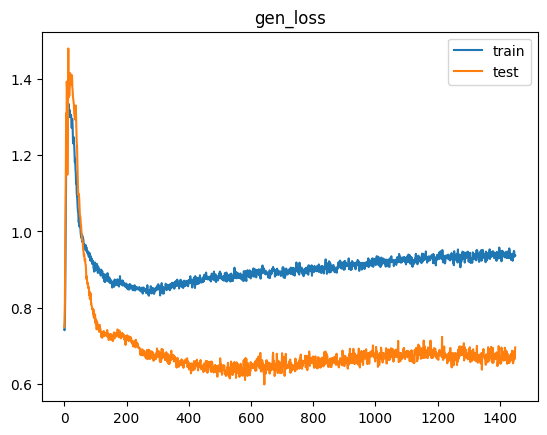

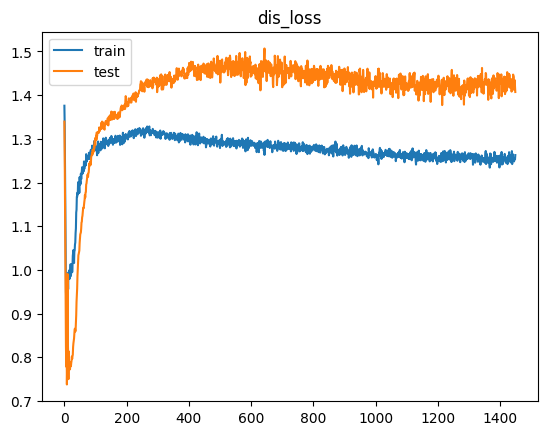

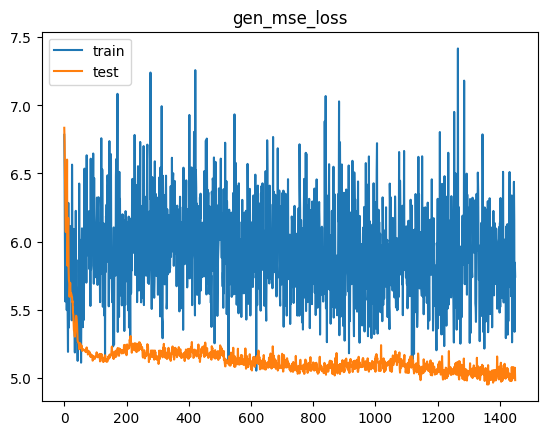

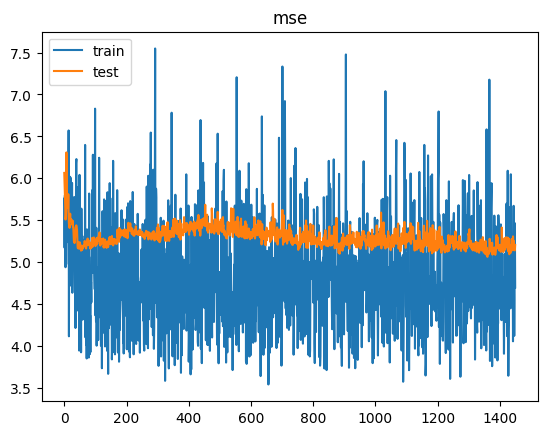

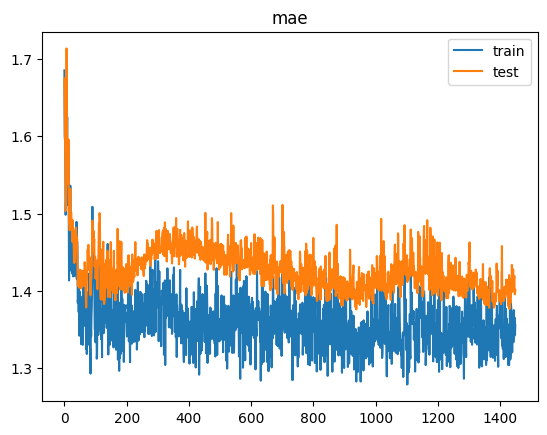

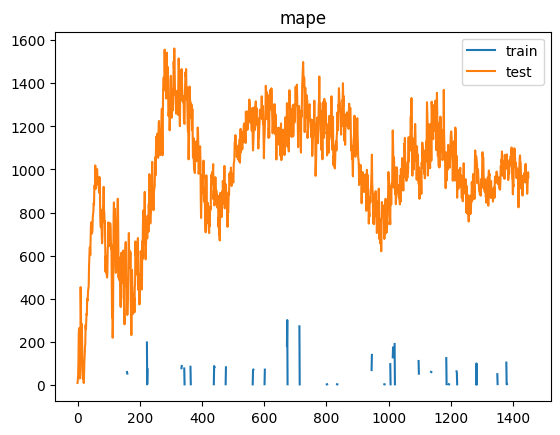

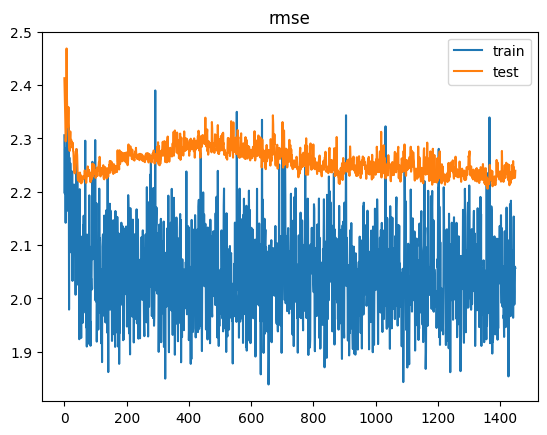

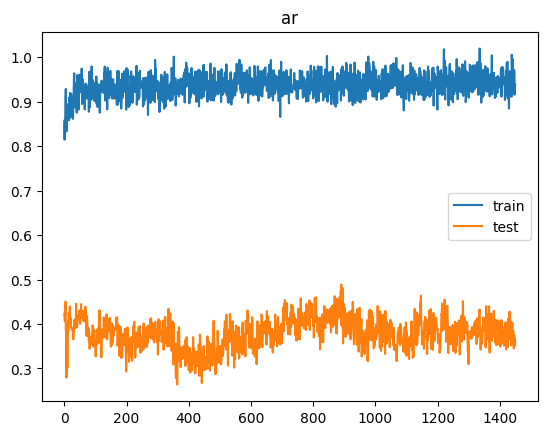

2/2 [==============================] - 0s 7ms/step


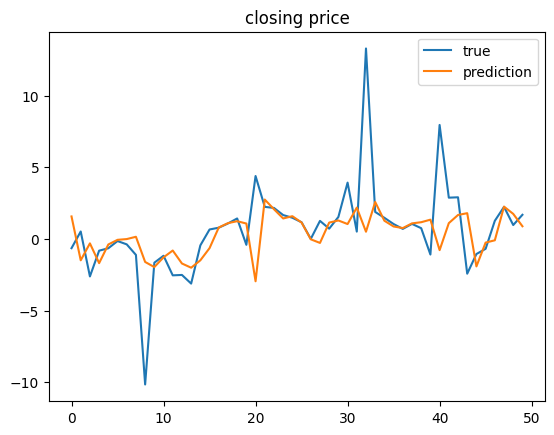

[MSE Baseline] train: 4.678691253575319  test: 5.002352560408067
Delta time with epochs = 1450: 0:33:16.771586
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 5, 7)]            0         
                                                                 
 simple_rnn_24 (SimpleRNN)   (None, 5, 10)             180       
                                                                 
 batch_normalization_24 (Bat  (None, 5, 10)            40        
 chNormalization)                                                
                                                                 
 leaky_re_lu_72 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_60 (Dropout)        (None, 5, 10)             0         
                                                                 
 simple_rnn_2

Time for epoch 53 is 1.5272486209869385 sec Generator Loss: 0.9732288718223572,  Discriminator_loss: 1.2353920936584473
Time for epoch 54 is 1.4250986576080322 sec Generator Loss: 0.977455198764801,  Discriminator_loss: 1.2368018627166748
Time for epoch 55 is 1.5077741146087646 sec Generator Loss: 0.9646703004837036,  Discriminator_loss: 1.2555692195892334
Time for epoch 56 is 1.4645378589630127 sec Generator Loss: 0.9729477167129517,  Discriminator_loss: 1.24024498462677
Time for epoch 57 is 1.374908447265625 sec Generator Loss: 0.9635016322135925,  Discriminator_loss: 1.2456587553024292
Time for epoch 58 is 1.4906752109527588 sec Generator Loss: 0.9648225903511047,  Discriminator_loss: 1.2471479177474976
Time for epoch 59 is 1.278641700744629 sec Generator Loss: 0.961269736289978,  Discriminator_loss: 1.2503700256347656
Time for epoch 60 is 1.5141994953155518 sec Generator Loss: 0.9726786613464355,  Discriminator_loss: 1.2481745481491089
Time for epoch 61 is 1.3540141582489014 sec Ge

Time for epoch 122 is 1.671379566192627 sec Generator Loss: 0.8770864009857178,  Discriminator_loss: 1.2936835289001465
Time for epoch 123 is 1.5758354663848877 sec Generator Loss: 0.884239912033081,  Discriminator_loss: 1.3023654222488403
Time for epoch 124 is 1.5593626499176025 sec Generator Loss: 0.875022828578949,  Discriminator_loss: 1.298185110092163
Time for epoch 125 is 1.5515408515930176 sec Generator Loss: 0.8748111724853516,  Discriminator_loss: 1.3016743659973145
Time for epoch 126 is 1.652918815612793 sec Generator Loss: 0.8726270794868469,  Discriminator_loss: 1.2993680238723755
Time for epoch 127 is 1.6494204998016357 sec Generator Loss: 0.8678426742553711,  Discriminator_loss: 1.3051470518112183
Time for epoch 128 is 1.6306509971618652 sec Generator Loss: 0.8676252365112305,  Discriminator_loss: 1.3068408966064453
Time for epoch 129 is 1.5547254085540771 sec Generator Loss: 0.8680549263954163,  Discriminator_loss: 1.3003358840942383
Time for epoch 130 is 1.5286779403686

Time for epoch 191 is 1.7436368465423584 sec Generator Loss: 0.8880537748336792,  Discriminator_loss: 1.2809033393859863
Time for epoch 192 is 1.740720272064209 sec Generator Loss: 0.8823896050453186,  Discriminator_loss: 1.2811238765716553
Time for epoch 193 is 1.6567180156707764 sec Generator Loss: 0.870477557182312,  Discriminator_loss: 1.2917280197143555
Time for epoch 194 is 1.4856770038604736 sec Generator Loss: 0.8761098384857178,  Discriminator_loss: 1.2922086715698242
Time for epoch 195 is 1.5010201930999756 sec Generator Loss: 0.9012978672981262,  Discriminator_loss: 1.26825749874115
Time for epoch 196 is 1.3837616443634033 sec Generator Loss: 0.8851289749145508,  Discriminator_loss: 1.288394808769226
Time for epoch 197 is 1.441826343536377 sec Generator Loss: 0.8730694055557251,  Discriminator_loss: 1.2921192646026611
Time for epoch 198 is 1.2311747074127197 sec Generator Loss: 0.8747091293334961,  Discriminator_loss: 1.2912570238113403
Time for epoch 199 is 1.33514094352722

Time for epoch 259 is 1.3011233806610107 sec Generator Loss: 0.8978943824768066,  Discriminator_loss: 1.2793482542037964
Time for epoch 260 is 1.3068091869354248 sec Generator Loss: 0.8973413705825806,  Discriminator_loss: 1.2712188959121704
Time for epoch 261 is 1.3933892250061035 sec Generator Loss: 0.8939439058303833,  Discriminator_loss: 1.2707048654556274
Time for epoch 262 is 1.3397619724273682 sec Generator Loss: 0.8850011825561523,  Discriminator_loss: 1.2820262908935547
Time for epoch 263 is 1.3523132801055908 sec Generator Loss: 0.8881077766418457,  Discriminator_loss: 1.277024507522583
Time for epoch 264 is 1.4855632781982422 sec Generator Loss: 0.9122831225395203,  Discriminator_loss: 1.2646560668945312
Time for epoch 265 is 1.5389575958251953 sec Generator Loss: 0.9034340381622314,  Discriminator_loss: 1.2632085084915161
Time for epoch 266 is 1.602719783782959 sec Generator Loss: 0.9024325013160706,  Discriminator_loss: 1.2642099857330322
Time for epoch 267 is 1.5722095966

Time for epoch 328 is 1.784942626953125 sec Generator Loss: 0.8945467472076416,  Discriminator_loss: 1.283543348312378
Time for epoch 329 is 1.7268562316894531 sec Generator Loss: 0.8757139444351196,  Discriminator_loss: 1.2914185523986816
Time for epoch 330 is 1.4914281368255615 sec Generator Loss: 0.8865679502487183,  Discriminator_loss: 1.2870992422103882
Time for epoch 331 is 1.3780617713928223 sec Generator Loss: 0.8879566788673401,  Discriminator_loss: 1.2809243202209473
Time for epoch 332 is 1.3635218143463135 sec Generator Loss: 0.8798085451126099,  Discriminator_loss: 1.2926414012908936
Time for epoch 333 is 1.2943189144134521 sec Generator Loss: 0.8912137746810913,  Discriminator_loss: 1.2898523807525635
Time for epoch 334 is 1.3704543113708496 sec Generator Loss: 0.8734372854232788,  Discriminator_loss: 1.289602518081665
Time for epoch 335 is 1.2833211421966553 sec Generator Loss: 0.8799579739570618,  Discriminator_loss: 1.29595947265625
Time for epoch 336 is 1.3265686035156

Time for epoch 397 is 1.3970379829406738 sec Generator Loss: 0.8804537057876587,  Discriminator_loss: 1.2877616882324219
Time for epoch 398 is 1.4080188274383545 sec Generator Loss: 0.8844183683395386,  Discriminator_loss: 1.2797294855117798
Time for epoch 399 is 1.4052152633666992 sec Generator Loss: 0.8977138996124268,  Discriminator_loss: 1.2907081842422485
Time for epoch 400 is 1.3444037437438965 sec Generator Loss: 0.9015898704528809,  Discriminator_loss: 1.2701661586761475
Time for epoch 401 is 1.4228301048278809 sec Generator Loss: 0.8850066065788269,  Discriminator_loss: 1.2924587726593018
Time for epoch 402 is 1.6342029571533203 sec Generator Loss: 0.8868577480316162,  Discriminator_loss: 1.2913135290145874
Time for epoch 403 is 1.6234326362609863 sec Generator Loss: 0.8840931057929993,  Discriminator_loss: 1.2899208068847656
Time for epoch 404 is 1.4257338047027588 sec Generator Loss: 0.8928064703941345,  Discriminator_loss: 1.280909776687622
Time for epoch 405 is 1.375177860

Time for epoch 465 is 1.3507027626037598 sec Generator Loss: 0.888189435005188,  Discriminator_loss: 1.2838771343231201
Time for epoch 466 is 1.3824238777160645 sec Generator Loss: 0.8795003890991211,  Discriminator_loss: 1.2843438386917114
Time for epoch 467 is 1.3421292304992676 sec Generator Loss: 0.8887456655502319,  Discriminator_loss: 1.2890655994415283
Time for epoch 468 is 1.3494842052459717 sec Generator Loss: 0.8898717761039734,  Discriminator_loss: 1.2883321046829224
Time for epoch 469 is 1.3695459365844727 sec Generator Loss: 0.895433247089386,  Discriminator_loss: 1.273993968963623
Time for epoch 470 is 1.378866195678711 sec Generator Loss: 0.8796883225440979,  Discriminator_loss: 1.2912598848342896
Time for epoch 471 is 1.3555572032928467 sec Generator Loss: 0.8932805061340332,  Discriminator_loss: 1.273730993270874
Time for epoch 472 is 1.3839056491851807 sec Generator Loss: 0.8896464109420776,  Discriminator_loss: 1.2817305326461792
Time for epoch 473 is 1.4153504371643

Time for epoch 534 is 1.724081039428711 sec Generator Loss: 0.891607403755188,  Discriminator_loss: 1.2752861976623535
Time for epoch 535 is 1.666168212890625 sec Generator Loss: 0.9072538018226624,  Discriminator_loss: 1.2780250310897827
Time for epoch 536 is 1.528503179550171 sec Generator Loss: 0.8997756242752075,  Discriminator_loss: 1.2796788215637207
Time for epoch 537 is 1.4004740715026855 sec Generator Loss: 0.8814392685890198,  Discriminator_loss: 1.294882893562317
Time for epoch 538 is 1.393575668334961 sec Generator Loss: 0.8830975294113159,  Discriminator_loss: 1.2835794687271118
Time for epoch 539 is 1.3251011371612549 sec Generator Loss: 0.8865547776222229,  Discriminator_loss: 1.2800376415252686
Time for epoch 540 is 1.3263919353485107 sec Generator Loss: 0.9049282073974609,  Discriminator_loss: 1.2741748094558716
Time for epoch 541 is 1.357304573059082 sec Generator Loss: 0.8925727009773254,  Discriminator_loss: 1.286171793937683
Time for epoch 542 is 1.3438098430633545

Time for epoch 603 is 1.489243507385254 sec Generator Loss: 0.913443386554718,  Discriminator_loss: 1.2716418504714966
Time for epoch 604 is 1.4609301090240479 sec Generator Loss: 0.9106812477111816,  Discriminator_loss: 1.2704638242721558
Time for epoch 605 is 1.449841022491455 sec Generator Loss: 0.9263984560966492,  Discriminator_loss: 1.2720099687576294
Time for epoch 606 is 1.4884374141693115 sec Generator Loss: 0.9203618764877319,  Discriminator_loss: 1.2568985223770142
Time for epoch 607 is 1.4740641117095947 sec Generator Loss: 0.9221052527427673,  Discriminator_loss: 1.265526533126831
Time for epoch 608 is 1.514188528060913 sec Generator Loss: 0.9011516571044922,  Discriminator_loss: 1.2714712619781494
Time for epoch 609 is 1.6007311344146729 sec Generator Loss: 0.9107258915901184,  Discriminator_loss: 1.2669960260391235
Time for epoch 610 is 1.5910065174102783 sec Generator Loss: 0.9053188562393188,  Discriminator_loss: 1.2771867513656616
Time for epoch 611 is 1.5848886966705

Time for epoch 672 is 1.6185495853424072 sec Generator Loss: 0.9146921634674072,  Discriminator_loss: 1.2792960405349731
Time for epoch 673 is 1.7078070640563965 sec Generator Loss: 0.9261620044708252,  Discriminator_loss: 1.256942629814148
Time for epoch 674 is 1.5132203102111816 sec Generator Loss: 0.9127665162086487,  Discriminator_loss: 1.2632213830947876
Time for epoch 675 is 1.727126121520996 sec Generator Loss: 0.9188047051429749,  Discriminator_loss: 1.2671600580215454
Time for epoch 676 is 1.5242648124694824 sec Generator Loss: 0.9253709316253662,  Discriminator_loss: 1.2518781423568726
Time for epoch 677 is 1.504863977432251 sec Generator Loss: 0.9261189103126526,  Discriminator_loss: 1.2653888463974
Time for epoch 678 is 1.5705058574676514 sec Generator Loss: 0.9297105073928833,  Discriminator_loss: 1.2631232738494873
Time for epoch 679 is 1.7054107189178467 sec Generator Loss: 0.9205670356750488,  Discriminator_loss: 1.264233946800232
Time for epoch 680 is 1.620637893676757

Time for epoch 741 is 1.5924444198608398 sec Generator Loss: 0.9206724762916565,  Discriminator_loss: 1.2600231170654297
Time for epoch 742 is 1.5630950927734375 sec Generator Loss: 0.9195160269737244,  Discriminator_loss: 1.2572182416915894
Time for epoch 743 is 1.3978838920593262 sec Generator Loss: 0.9245366454124451,  Discriminator_loss: 1.2631577253341675
Time for epoch 744 is 1.3770771026611328 sec Generator Loss: 0.931721031665802,  Discriminator_loss: 1.2494524717330933
Time for epoch 745 is 1.4252855777740479 sec Generator Loss: 0.940299391746521,  Discriminator_loss: 1.2439457178115845
Time for epoch 746 is 1.4961798191070557 sec Generator Loss: 0.9255315065383911,  Discriminator_loss: 1.2653191089630127
Time for epoch 747 is 1.4762072563171387 sec Generator Loss: 0.9307854175567627,  Discriminator_loss: 1.2619097232818604
Time for epoch 748 is 1.491685390472412 sec Generator Loss: 0.9228612780570984,  Discriminator_loss: 1.2633424997329712
Time for epoch 749 is 1.52347135543

Time for epoch 810 is 1.5303950309753418 sec Generator Loss: 0.9517514109611511,  Discriminator_loss: 1.2492272853851318
Time for epoch 811 is 1.3835625648498535 sec Generator Loss: 0.9391589760780334,  Discriminator_loss: 1.2528947591781616
Time for epoch 812 is 1.3889195919036865 sec Generator Loss: 0.9415996670722961,  Discriminator_loss: 1.2468544244766235
Time for epoch 813 is 1.4142868518829346 sec Generator Loss: 0.928034245967865,  Discriminator_loss: 1.2544580698013306
Time for epoch 814 is 1.3543386459350586 sec Generator Loss: 0.9291142225265503,  Discriminator_loss: 1.2670363187789917
Time for epoch 815 is 1.3137447834014893 sec Generator Loss: 0.9383572936058044,  Discriminator_loss: 1.2524367570877075
Time for epoch 816 is 1.3557775020599365 sec Generator Loss: 0.9372708201408386,  Discriminator_loss: 1.2540034055709839
Time for epoch 817 is 1.4014079570770264 sec Generator Loss: 0.9427065849304199,  Discriminator_loss: 1.2498446702957153
Time for epoch 818 is 1.436906337

Time for epoch 878 is 1.3811218738555908 sec Generator Loss: 0.9466543197631836,  Discriminator_loss: 1.250057339668274
Time for epoch 879 is 1.4187991619110107 sec Generator Loss: 0.9515559673309326,  Discriminator_loss: 1.2529082298278809
Time for epoch 880 is 1.4208147525787354 sec Generator Loss: 0.951185941696167,  Discriminator_loss: 1.2473856210708618
Time for epoch 881 is 1.7470762729644775 sec Generator Loss: 0.9484456181526184,  Discriminator_loss: 1.2533831596374512
Time for epoch 882 is 1.6229653358459473 sec Generator Loss: 0.9434494972229004,  Discriminator_loss: 1.2609413862228394
Time for epoch 883 is 1.7709662914276123 sec Generator Loss: 0.9425457715988159,  Discriminator_loss: 1.2497644424438477
Time for epoch 884 is 1.6608598232269287 sec Generator Loss: 0.9354293942451477,  Discriminator_loss: 1.2577412128448486
Time for epoch 885 is 1.6257872581481934 sec Generator Loss: 0.9445050954818726,  Discriminator_loss: 1.2532649040222168
Time for epoch 886 is 1.6149208545

Time for epoch 947 is 1.3557288646697998 sec Generator Loss: 0.9419902563095093,  Discriminator_loss: 1.2492390871047974
Time for epoch 948 is 1.4160821437835693 sec Generator Loss: 0.9354286193847656,  Discriminator_loss: 1.2505170106887817
Time for epoch 949 is 1.372986078262329 sec Generator Loss: 0.9467862844467163,  Discriminator_loss: 1.2538141012191772
Time for epoch 950 is 1.3643481731414795 sec Generator Loss: 0.9416077733039856,  Discriminator_loss: 1.2577987909317017
Time for epoch 951 is 1.4325017929077148 sec Generator Loss: 0.9344141483306885,  Discriminator_loss: 1.2676830291748047
Time for epoch 952 is 1.3523178100585938 sec Generator Loss: 0.9418110251426697,  Discriminator_loss: 1.2512011528015137
Time for epoch 953 is 1.3194973468780518 sec Generator Loss: 0.9341263771057129,  Discriminator_loss: 1.251794457435608
Time for epoch 954 is 1.3384456634521484 sec Generator Loss: 0.9296190142631531,  Discriminator_loss: 1.2563756704330444
Time for epoch 955 is 1.4206240177

Time for epoch 1015 is 1.5193719863891602 sec Generator Loss: 0.9410571455955505,  Discriminator_loss: 1.2521004676818848
Time for epoch 1016 is 1.6006441116333008 sec Generator Loss: 0.9423425793647766,  Discriminator_loss: 1.255791425704956
Time for epoch 1017 is 1.464287281036377 sec Generator Loss: 0.930587649345398,  Discriminator_loss: 1.2618658542633057
Time for epoch 1018 is 1.5938928127288818 sec Generator Loss: 0.9342178702354431,  Discriminator_loss: 1.2652539014816284
Time for epoch 1019 is 1.4247496128082275 sec Generator Loss: 0.941431999206543,  Discriminator_loss: 1.252834677696228
Time for epoch 1020 is 1.3855328559875488 sec Generator Loss: 0.9274551272392273,  Discriminator_loss: 1.2595411539077759
Time for epoch 1021 is 1.396906852722168 sec Generator Loss: 0.9292423129081726,  Discriminator_loss: 1.2558095455169678
Time for epoch 1022 is 1.4394190311431885 sec Generator Loss: 0.930187463760376,  Discriminator_loss: 1.2499871253967285
Time for epoch 1023 is 1.425142

Time for epoch 1083 is 1.5141665935516357 sec Generator Loss: 0.9322041869163513,  Discriminator_loss: 1.2630435228347778
Time for epoch 1084 is 1.4657411575317383 sec Generator Loss: 0.9478984475135803,  Discriminator_loss: 1.2520020008087158
Time for epoch 1085 is 1.5444252490997314 sec Generator Loss: 0.9448692202568054,  Discriminator_loss: 1.2549118995666504
Time for epoch 1086 is 1.4097411632537842 sec Generator Loss: 0.9454883933067322,  Discriminator_loss: 1.265117883682251
Time for epoch 1087 is 1.4819133281707764 sec Generator Loss: 0.9404654502868652,  Discriminator_loss: 1.2622195482254028
Time for epoch 1088 is 1.50538969039917 sec Generator Loss: 0.955237090587616,  Discriminator_loss: 1.2504634857177734
Time for epoch 1089 is 1.3952133655548096 sec Generator Loss: 0.9535016417503357,  Discriminator_loss: 1.2555019855499268
Time for epoch 1090 is 1.3723042011260986 sec Generator Loss: 0.937450110912323,  Discriminator_loss: 1.2669709920883179
Time for epoch 1091 is 1.3641

Time for epoch 1151 is 1.377986192703247 sec Generator Loss: 0.9502816796302795,  Discriminator_loss: 1.247813105583191
Time for epoch 1152 is 1.309800148010254 sec Generator Loss: 0.9401819109916687,  Discriminator_loss: 1.261326551437378
Time for epoch 1153 is 1.4659843444824219 sec Generator Loss: 0.9508450627326965,  Discriminator_loss: 1.2480958700180054
Time for epoch 1154 is 1.4128649234771729 sec Generator Loss: 0.9328242540359497,  Discriminator_loss: 1.263705849647522
Time for epoch 1155 is 1.2926170825958252 sec Generator Loss: 0.9361741542816162,  Discriminator_loss: 1.2598456144332886
Time for epoch 1156 is 1.4032089710235596 sec Generator Loss: 0.9483360052108765,  Discriminator_loss: 1.2572283744812012
Time for epoch 1157 is 1.4496731758117676 sec Generator Loss: 0.9350792765617371,  Discriminator_loss: 1.254749059677124
Time for epoch 1158 is 1.38633394241333 sec Generator Loss: 0.956534743309021,  Discriminator_loss: 1.2510733604431152
Time for epoch 1159 is 1.27764225

Time for epoch 1219 is 1.3860256671905518 sec Generator Loss: 0.9382262825965881,  Discriminator_loss: 1.2669155597686768
Time for epoch 1220 is 1.4636976718902588 sec Generator Loss: 0.9522817730903625,  Discriminator_loss: 1.2417399883270264
Time for epoch 1221 is 1.2616395950317383 sec Generator Loss: 0.9465263485908508,  Discriminator_loss: 1.2510287761688232
Time for epoch 1222 is 1.3862342834472656 sec Generator Loss: 0.9456523060798645,  Discriminator_loss: 1.2601094245910645
Time for epoch 1223 is 1.494974136352539 sec Generator Loss: 0.943668782711029,  Discriminator_loss: 1.2592880725860596
Time for epoch 1224 is 1.4703888893127441 sec Generator Loss: 0.9406662583351135,  Discriminator_loss: 1.2704812288284302
Time for epoch 1225 is 1.4197895526885986 sec Generator Loss: 0.9492297172546387,  Discriminator_loss: 1.2525781393051147
Time for epoch 1226 is 1.3578517436981201 sec Generator Loss: 0.9341599345207214,  Discriminator_loss: 1.2568020820617676
Time for epoch 1227 is 1.3

Time for epoch 1287 is 1.499187707901001 sec Generator Loss: 0.9529429078102112,  Discriminator_loss: 1.2602232694625854
Time for epoch 1288 is 1.499739170074463 sec Generator Loss: 0.9400778412818909,  Discriminator_loss: 1.2530317306518555
Time for epoch 1289 is 1.471466302871704 sec Generator Loss: 0.9304198026657104,  Discriminator_loss: 1.2639737129211426
Time for epoch 1290 is 1.5114140510559082 sec Generator Loss: 0.9478923678398132,  Discriminator_loss: 1.2538551092147827
Time for epoch 1291 is 1.4251301288604736 sec Generator Loss: 0.9361938238143921,  Discriminator_loss: 1.253739595413208
Time for epoch 1292 is 1.3956973552703857 sec Generator Loss: 0.9447252750396729,  Discriminator_loss: 1.2613831758499146
Time for epoch 1293 is 1.356804370880127 sec Generator Loss: 0.9328653216362,  Discriminator_loss: 1.2617453336715698
Time for epoch 1294 is 1.4016227722167969 sec Generator Loss: 0.9422234296798706,  Discriminator_loss: 1.2522295713424683
Time for epoch 1295 is 1.4130978

Time for epoch 1355 is 1.4126629829406738 sec Generator Loss: 0.9492967128753662,  Discriminator_loss: 1.256494402885437
Time for epoch 1356 is 1.4423718452453613 sec Generator Loss: 0.9359248280525208,  Discriminator_loss: 1.2549680471420288
Time for epoch 1357 is 1.3912022113800049 sec Generator Loss: 0.936450719833374,  Discriminator_loss: 1.2516014575958252
Time for epoch 1358 is 1.5360002517700195 sec Generator Loss: 0.9512507915496826,  Discriminator_loss: 1.2516294717788696
Time for epoch 1359 is 1.8390295505523682 sec Generator Loss: 0.9572679996490479,  Discriminator_loss: 1.2364661693572998
Time for epoch 1360 is 1.7786438465118408 sec Generator Loss: 0.9396474361419678,  Discriminator_loss: 1.2475438117980957
Time for epoch 1361 is 1.8584821224212646 sec Generator Loss: 0.947729229927063,  Discriminator_loss: 1.2640206813812256
Time for epoch 1362 is 1.777817726135254 sec Generator Loss: 0.9597067832946777,  Discriminator_loss: 1.2558650970458984
Time for epoch 1363 is 1.755

Time for epoch 1423 is 1.4449727535247803 sec Generator Loss: 0.9451485276222229,  Discriminator_loss: 1.2608734369277954
Time for epoch 1424 is 1.4452855587005615 sec Generator Loss: 0.9381343722343445,  Discriminator_loss: 1.2583074569702148
Time for epoch 1425 is 1.4169108867645264 sec Generator Loss: 0.950274646282196,  Discriminator_loss: 1.2569330930709839
Time for epoch 1426 is 1.4199957847595215 sec Generator Loss: 0.9595547318458557,  Discriminator_loss: 1.2512282133102417
Time for epoch 1427 is 1.428380012512207 sec Generator Loss: 0.9439870715141296,  Discriminator_loss: 1.2737833261489868
Time for epoch 1428 is 1.402878999710083 sec Generator Loss: 0.9440097212791443,  Discriminator_loss: 1.2539559602737427
Time for epoch 1429 is 1.666930913925171 sec Generator Loss: 0.9437785148620605,  Discriminator_loss: 1.2522794008255005
Time for epoch 1430 is 1.8031690120697021 sec Generator Loss: 0.9608628153800964,  Discriminator_loss: 1.2425583600997925
Time for epoch 1431 is 1.508

Time for epoch 1491 is 1.4191031455993652 sec Generator Loss: 0.9412363171577454,  Discriminator_loss: 1.2553355693817139
Time for epoch 1492 is 1.4089419841766357 sec Generator Loss: 0.9552830457687378,  Discriminator_loss: 1.2513731718063354
Time for epoch 1493 is 1.4560232162475586 sec Generator Loss: 0.9483420252799988,  Discriminator_loss: 1.2560356855392456
Time for epoch 1494 is 1.5041303634643555 sec Generator Loss: 0.9640688896179199,  Discriminator_loss: 1.247148871421814
Time for epoch 1495 is 1.479067087173462 sec Generator Loss: 0.9444236755371094,  Discriminator_loss: 1.261802315711975
Time for epoch 1496 is 1.4351027011871338 sec Generator Loss: 0.9528027176856995,  Discriminator_loss: 1.2585731744766235
Time for epoch 1497 is 1.4736504554748535 sec Generator Loss: 0.9533118009567261,  Discriminator_loss: 1.2586215734481812
Time for epoch 1498 is 1.5239200592041016 sec Generator Loss: 0.953754186630249,  Discriminator_loss: 1.253267765045166
Time for epoch 1499 is 1.3756

Time for epoch 1559 is 1.437279224395752 sec Generator Loss: 0.931984543800354,  Discriminator_loss: 1.261552095413208
Time for epoch 1560 is 1.3996965885162354 sec Generator Loss: 0.9373649954795837,  Discriminator_loss: 1.2578821182250977
Time for epoch 1561 is 1.3749275207519531 sec Generator Loss: 0.9396225214004517,  Discriminator_loss: 1.2639342546463013
Time for epoch 1562 is 1.3737287521362305 sec Generator Loss: 0.9484322667121887,  Discriminator_loss: 1.2530367374420166
Time for epoch 1563 is 1.3386332988739014 sec Generator Loss: 0.9494351744651794,  Discriminator_loss: 1.2540162801742554
Time for epoch 1564 is 1.4089317321777344 sec Generator Loss: 0.9451800584793091,  Discriminator_loss: 1.2547276020050049
Time for epoch 1565 is 1.3236017227172852 sec Generator Loss: 0.9465609192848206,  Discriminator_loss: 1.2586075067520142
Time for epoch 1566 is 1.3002889156341553 sec Generator Loss: 0.9365376830101013,  Discriminator_loss: 1.263810396194458
Time for epoch 1567 is 1.340

Time for epoch 1627 is 1.3423078060150146 sec Generator Loss: 0.9367623329162598,  Discriminator_loss: 1.2654178142547607
Time for epoch 1628 is 1.343571424484253 sec Generator Loss: 0.9409124255180359,  Discriminator_loss: 1.2476736307144165
Time for epoch 1629 is 1.3110136985778809 sec Generator Loss: 0.9329227805137634,  Discriminator_loss: 1.265276312828064
Time for epoch 1630 is 1.4043018817901611 sec Generator Loss: 0.938508927822113,  Discriminator_loss: 1.2512060403823853
Time for epoch 1631 is 1.3220458030700684 sec Generator Loss: 0.9533783793449402,  Discriminator_loss: 1.2461745738983154
Time for epoch 1632 is 1.3197486400604248 sec Generator Loss: 0.9519875645637512,  Discriminator_loss: 1.2512156963348389
Time for epoch 1633 is 1.3489127159118652 sec Generator Loss: 0.9588918089866638,  Discriminator_loss: 1.2563893795013428
Time for epoch 1634 is 1.3879060745239258 sec Generator Loss: 0.9426226615905762,  Discriminator_loss: 1.2522368431091309
Time for epoch 1635 is 1.33

Time for epoch 1695 is 1.371948480606079 sec Generator Loss: 0.9269484281539917,  Discriminator_loss: 1.2563319206237793
Time for epoch 1696 is 1.3953485488891602 sec Generator Loss: 0.9352250099182129,  Discriminator_loss: 1.2660430669784546
Time for epoch 1697 is 1.3645060062408447 sec Generator Loss: 0.9334561824798584,  Discriminator_loss: 1.2673460245132446
Time for epoch 1698 is 1.4527807235717773 sec Generator Loss: 0.944495677947998,  Discriminator_loss: 1.2546736001968384
Time for epoch 1699 is 1.799959659576416 sec Generator Loss: 0.9413138628005981,  Discriminator_loss: 1.2573868036270142
Time for epoch 1700 is 1.5331323146820068 sec Generator Loss: 0.9468204975128174,  Discriminator_loss: 1.2596815824508667


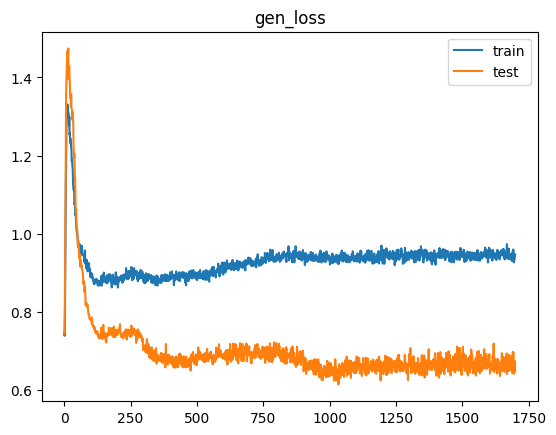

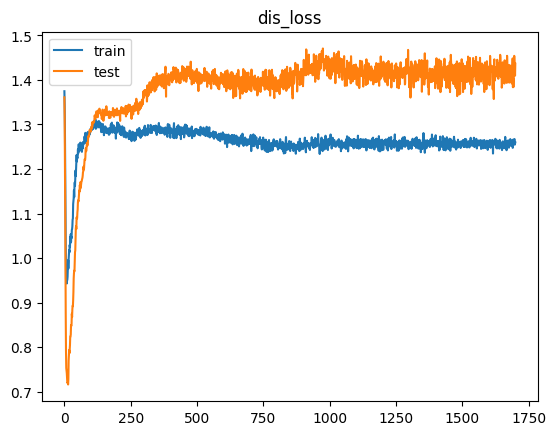

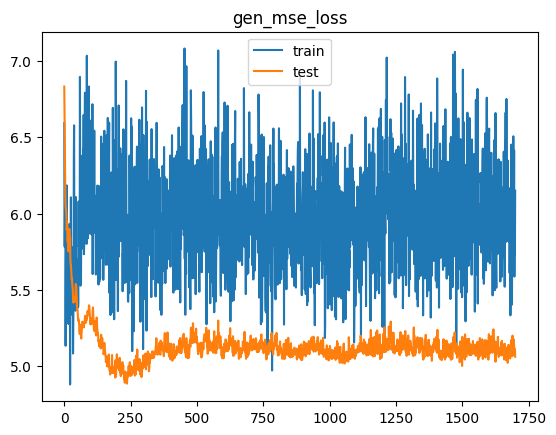

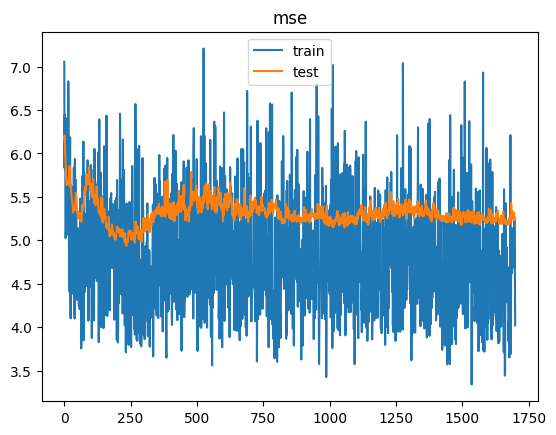

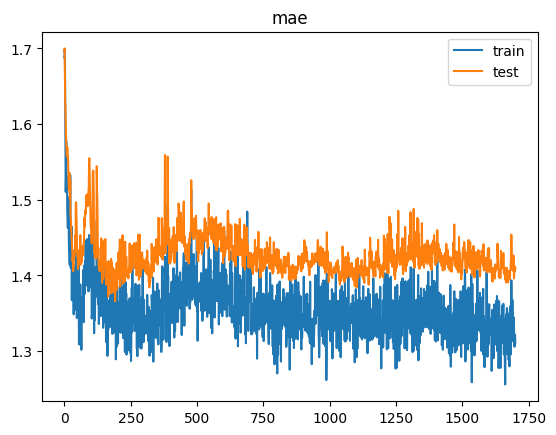

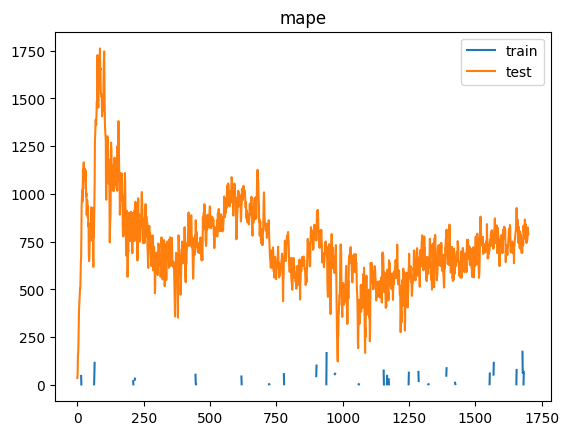

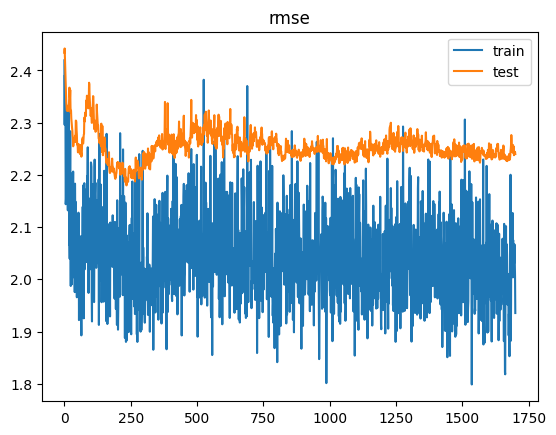

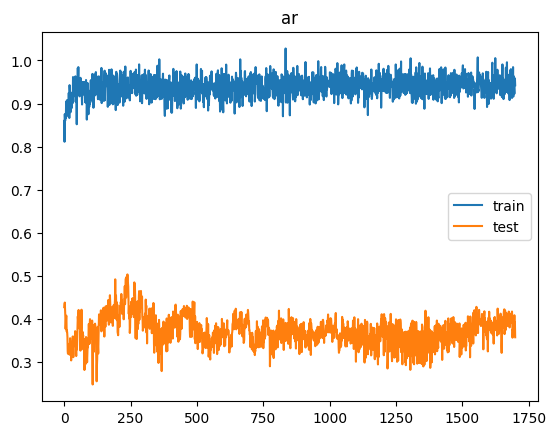

2/2 [==============================] - 0s 7ms/step


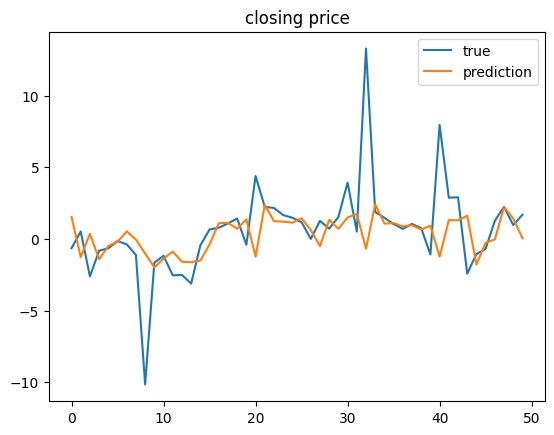

[MSE Baseline] train: 5.169443017764518  test: 5.002352560408067
Delta time with epochs = 1700: 0:42:25.855074
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 5, 7)]            0         
                                                                 
 simple_rnn_26 (SimpleRNN)   (None, 5, 10)             180       
                                                                 
 batch_normalization_26 (Bat  (None, 5, 10)            40        
 chNormalization)                                                
                                                                 
 leaky_re_lu_78 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_65 (Dropout)        (None, 5, 10)             0         
                                                                 
 simple_rnn_2

Time for epoch 53 is 1.5499672889709473 sec Generator Loss: 0.9417502284049988,  Discriminator_loss: 1.2671397924423218
Time for epoch 54 is 1.5751917362213135 sec Generator Loss: 0.9337649941444397,  Discriminator_loss: 1.2673819065093994
Time for epoch 55 is 1.6071882247924805 sec Generator Loss: 0.9347878694534302,  Discriminator_loss: 1.2728668451309204
Time for epoch 56 is 1.5651860237121582 sec Generator Loss: 0.9365106821060181,  Discriminator_loss: 1.2770601511001587
Time for epoch 57 is 1.3909356594085693 sec Generator Loss: 0.9204098582267761,  Discriminator_loss: 1.2769700288772583
Time for epoch 58 is 1.4229257106781006 sec Generator Loss: 0.9200066924095154,  Discriminator_loss: 1.2772263288497925
Time for epoch 59 is 1.3957068920135498 sec Generator Loss: 0.9334254860877991,  Discriminator_loss: 1.2642735242843628
Time for epoch 60 is 1.4919853210449219 sec Generator Loss: 0.9191178679466248,  Discriminator_loss: 1.2677680253982544
Time for epoch 61 is 1.5289726257324219 

Time for epoch 122 is 1.3003919124603271 sec Generator Loss: 0.8704080581665039,  Discriminator_loss: 1.2987473011016846
Time for epoch 123 is 1.3120191097259521 sec Generator Loss: 0.871565043926239,  Discriminator_loss: 1.293965458869934
Time for epoch 124 is 1.3091959953308105 sec Generator Loss: 0.8688108921051025,  Discriminator_loss: 1.298748254776001
Time for epoch 125 is 1.380237102508545 sec Generator Loss: 0.8696170449256897,  Discriminator_loss: 1.2878060340881348
Time for epoch 126 is 1.3863770961761475 sec Generator Loss: 0.8739676475524902,  Discriminator_loss: 1.2934205532073975
Time for epoch 127 is 1.3565411567687988 sec Generator Loss: 0.8720369338989258,  Discriminator_loss: 1.2912977933883667
Time for epoch 128 is 1.3195900917053223 sec Generator Loss: 0.8563345670700073,  Discriminator_loss: 1.3121529817581177
Time for epoch 129 is 1.3979547023773193 sec Generator Loss: 0.8730337619781494,  Discriminator_loss: 1.2994211912155151
Time for epoch 130 is 1.347514152526

Time for epoch 190 is 1.3919646739959717 sec Generator Loss: 0.855513334274292,  Discriminator_loss: 1.3054362535476685
Time for epoch 191 is 1.5621891021728516 sec Generator Loss: 0.8633362054824829,  Discriminator_loss: 1.3159335851669312
Time for epoch 192 is 1.6472713947296143 sec Generator Loss: 0.8567793965339661,  Discriminator_loss: 1.3071924448013306
Time for epoch 193 is 1.80910062789917 sec Generator Loss: 0.8524234294891357,  Discriminator_loss: 1.3038995265960693
Time for epoch 194 is 1.6461777687072754 sec Generator Loss: 0.8522496223449707,  Discriminator_loss: 1.317187786102295
Time for epoch 195 is 1.712095022201538 sec Generator Loss: 0.8498693108558655,  Discriminator_loss: 1.3044813871383667
Time for epoch 196 is 1.6745069026947021 sec Generator Loss: 0.8457601070404053,  Discriminator_loss: 1.3220075368881226
Time for epoch 197 is 1.6582667827606201 sec Generator Loss: 0.849810004234314,  Discriminator_loss: 1.305659294128418
Time for epoch 198 is 1.712813615798950

Time for epoch 259 is 1.5073833465576172 sec Generator Loss: 0.8575713038444519,  Discriminator_loss: 1.3145486116409302
Time for epoch 260 is 1.4236609935760498 sec Generator Loss: 0.8604936599731445,  Discriminator_loss: 1.3132944107055664
Time for epoch 261 is 1.499659538269043 sec Generator Loss: 0.8556468486785889,  Discriminator_loss: 1.31583571434021
Time for epoch 262 is 1.4570422172546387 sec Generator Loss: 0.8658653497695923,  Discriminator_loss: 1.303367018699646
Time for epoch 263 is 1.3028409481048584 sec Generator Loss: 0.8660786151885986,  Discriminator_loss: 1.3039271831512451
Time for epoch 264 is 1.4177584648132324 sec Generator Loss: 0.8543017506599426,  Discriminator_loss: 1.3080006837844849
Time for epoch 265 is 1.3981711864471436 sec Generator Loss: 0.8618252873420715,  Discriminator_loss: 1.3003265857696533
Time for epoch 266 is 1.4297807216644287 sec Generator Loss: 0.8563656210899353,  Discriminator_loss: 1.316269874572754
Time for epoch 267 is 1.3826644420623

Time for epoch 328 is 1.6036248207092285 sec Generator Loss: 0.8670046925544739,  Discriminator_loss: 1.3082404136657715
Time for epoch 329 is 1.5621752738952637 sec Generator Loss: 0.8738333582878113,  Discriminator_loss: 1.3086291551589966
Time for epoch 330 is 1.706796407699585 sec Generator Loss: 0.8729764223098755,  Discriminator_loss: 1.2936960458755493
Time for epoch 331 is 1.7280747890472412 sec Generator Loss: 0.8739506006240845,  Discriminator_loss: 1.293988823890686
Time for epoch 332 is 1.760385513305664 sec Generator Loss: 0.8793877363204956,  Discriminator_loss: 1.3017069101333618
Time for epoch 333 is 1.569725513458252 sec Generator Loss: 0.8695290088653564,  Discriminator_loss: 1.3015977144241333
Time for epoch 334 is 1.7360315322875977 sec Generator Loss: 0.8740831613540649,  Discriminator_loss: 1.2923424243927002
Time for epoch 335 is 1.6000080108642578 sec Generator Loss: 0.8748182654380798,  Discriminator_loss: 1.2924941778182983
Time for epoch 336 is 1.513931274414

Time for epoch 397 is 1.416140079498291 sec Generator Loss: 0.8776726126670837,  Discriminator_loss: 1.2945239543914795
Time for epoch 398 is 1.3837440013885498 sec Generator Loss: 0.886176586151123,  Discriminator_loss: 1.28298020362854
Time for epoch 399 is 1.3824801445007324 sec Generator Loss: 0.8899412751197815,  Discriminator_loss: 1.281647801399231
Time for epoch 400 is 1.4066498279571533 sec Generator Loss: 0.8813742399215698,  Discriminator_loss: 1.299027681350708
Time for epoch 401 is 1.4263548851013184 sec Generator Loss: 0.872247040271759,  Discriminator_loss: 1.2914847135543823
Time for epoch 402 is 1.4484529495239258 sec Generator Loss: 0.874626874923706,  Discriminator_loss: 1.2947920560836792
Time for epoch 403 is 1.4606397151947021 sec Generator Loss: 0.8940416574478149,  Discriminator_loss: 1.2894749641418457
Time for epoch 404 is 1.3914649486541748 sec Generator Loss: 0.8860334753990173,  Discriminator_loss: 1.3009250164031982
Time for epoch 405 is 1.3836286067962646

Time for epoch 466 is 1.7690446376800537 sec Generator Loss: 0.8944540619850159,  Discriminator_loss: 1.2896515130996704
Time for epoch 467 is 1.7746906280517578 sec Generator Loss: 0.8864390254020691,  Discriminator_loss: 1.2925843000411987
Time for epoch 468 is 1.5657587051391602 sec Generator Loss: 0.8895689249038696,  Discriminator_loss: 1.2801923751831055
Time for epoch 469 is 1.5744893550872803 sec Generator Loss: 0.892490565776825,  Discriminator_loss: 1.2803298234939575
Time for epoch 470 is 1.6653549671173096 sec Generator Loss: 0.878865122795105,  Discriminator_loss: 1.2996699810028076
Time for epoch 471 is 1.731705904006958 sec Generator Loss: 0.8918541073799133,  Discriminator_loss: 1.2824249267578125
Time for epoch 472 is 1.4962306022644043 sec Generator Loss: 0.8857391476631165,  Discriminator_loss: 1.295538067817688
Time for epoch 473 is 1.5406510829925537 sec Generator Loss: 0.8868582844734192,  Discriminator_loss: 1.2726812362670898
Time for epoch 474 is 1.525138139724

Time for epoch 535 is 1.4431090354919434 sec Generator Loss: 0.9096802473068237,  Discriminator_loss: 1.292895793914795
Time for epoch 536 is 1.4541583061218262 sec Generator Loss: 0.893261194229126,  Discriminator_loss: 1.2884190082550049
Time for epoch 537 is 1.5042088031768799 sec Generator Loss: 0.8912532329559326,  Discriminator_loss: 1.289443850517273
Time for epoch 538 is 1.460038661956787 sec Generator Loss: 0.8905013203620911,  Discriminator_loss: 1.2853888273239136
Time for epoch 539 is 1.48152756690979 sec Generator Loss: 0.8998724222183228,  Discriminator_loss: 1.2776620388031006
Time for epoch 540 is 1.5921192169189453 sec Generator Loss: 0.8952518105506897,  Discriminator_loss: 1.2875239849090576
Time for epoch 541 is 1.5612452030181885 sec Generator Loss: 0.8834760189056396,  Discriminator_loss: 1.2894209623336792
Time for epoch 542 is 1.490576982498169 sec Generator Loss: 0.8943043351173401,  Discriminator_loss: 1.2819758653640747
Time for epoch 543 is 1.572581529617309

Time for epoch 604 is 1.436659336090088 sec Generator Loss: 0.9052687883377075,  Discriminator_loss: 1.2703924179077148
Time for epoch 605 is 1.4338808059692383 sec Generator Loss: 0.8989466428756714,  Discriminator_loss: 1.2720762491226196
Time for epoch 606 is 1.3667097091674805 sec Generator Loss: 0.9109557271003723,  Discriminator_loss: 1.2748466730117798
Time for epoch 607 is 1.463350534439087 sec Generator Loss: 0.9040824174880981,  Discriminator_loss: 1.2787011861801147
Time for epoch 608 is 1.337402582168579 sec Generator Loss: 0.904297947883606,  Discriminator_loss: 1.2766553163528442
Time for epoch 609 is 1.40842604637146 sec Generator Loss: 0.8993300795555115,  Discriminator_loss: 1.2818821668624878
Time for epoch 610 is 1.4170055389404297 sec Generator Loss: 0.9035595059394836,  Discriminator_loss: 1.2693215608596802
Time for epoch 611 is 1.3482666015625 sec Generator Loss: 0.8999457359313965,  Discriminator_loss: 1.2849197387695312
Time for epoch 612 is 1.408174753189087 s

Time for epoch 673 is 1.5638847351074219 sec Generator Loss: 0.8951399326324463,  Discriminator_loss: 1.2888034582138062
Time for epoch 674 is 1.4756889343261719 sec Generator Loss: 0.9179599285125732,  Discriminator_loss: 1.2738252878189087
Time for epoch 675 is 1.5153963565826416 sec Generator Loss: 0.9021744132041931,  Discriminator_loss: 1.2680667638778687
Time for epoch 676 is 1.421034574508667 sec Generator Loss: 0.9143458604812622,  Discriminator_loss: 1.2738841772079468
Time for epoch 677 is 1.4581968784332275 sec Generator Loss: 0.9227173328399658,  Discriminator_loss: 1.2743202447891235
Time for epoch 678 is 1.4726097583770752 sec Generator Loss: 0.9051597118377686,  Discriminator_loss: 1.2863446474075317
Time for epoch 679 is 1.5337345600128174 sec Generator Loss: 0.9035049676895142,  Discriminator_loss: 1.282798171043396
Time for epoch 680 is 1.4765691757202148 sec Generator Loss: 0.9160209894180298,  Discriminator_loss: 1.271649956703186
Time for epoch 681 is 1.58740997314

Time for epoch 742 is 1.5215742588043213 sec Generator Loss: 0.9122974872589111,  Discriminator_loss: 1.2677797079086304
Time for epoch 743 is 1.5879440307617188 sec Generator Loss: 0.9058175683021545,  Discriminator_loss: 1.2706865072250366
Time for epoch 744 is 1.5405373573303223 sec Generator Loss: 0.9185643792152405,  Discriminator_loss: 1.2744462490081787
Time for epoch 745 is 1.5717673301696777 sec Generator Loss: 0.920592188835144,  Discriminator_loss: 1.280282974243164
Time for epoch 746 is 1.5260815620422363 sec Generator Loss: 0.9163796901702881,  Discriminator_loss: 1.2711491584777832
Time for epoch 747 is 1.4778666496276855 sec Generator Loss: 0.9179307222366333,  Discriminator_loss: 1.2704896926879883
Time for epoch 748 is 1.4281625747680664 sec Generator Loss: 0.9135894775390625,  Discriminator_loss: 1.2741668224334717
Time for epoch 749 is 1.4363088607788086 sec Generator Loss: 0.9203793406486511,  Discriminator_loss: 1.273395299911499
Time for epoch 750 is 1.42132830619

Time for epoch 811 is 1.6805627346038818 sec Generator Loss: 0.9236657023429871,  Discriminator_loss: 1.2685797214508057
Time for epoch 812 is 1.6166949272155762 sec Generator Loss: 0.9039644598960876,  Discriminator_loss: 1.2703386545181274
Time for epoch 813 is 1.5885553359985352 sec Generator Loss: 0.9160152673721313,  Discriminator_loss: 1.2688674926757812
Time for epoch 814 is 2.066953659057617 sec Generator Loss: 0.914482831954956,  Discriminator_loss: 1.2667843103408813
Time for epoch 815 is 1.7850675582885742 sec Generator Loss: 0.9201026558876038,  Discriminator_loss: 1.2633627653121948
Time for epoch 816 is 1.741445541381836 sec Generator Loss: 0.9190815091133118,  Discriminator_loss: 1.2766715288162231
Time for epoch 817 is 1.8333299160003662 sec Generator Loss: 0.917530357837677,  Discriminator_loss: 1.2719556093215942
Time for epoch 818 is 1.6840331554412842 sec Generator Loss: 0.9156471490859985,  Discriminator_loss: 1.2706340551376343
Time for epoch 819 is 1.520872116088

Time for epoch 879 is 1.72833251953125 sec Generator Loss: 0.9218540787696838,  Discriminator_loss: 1.2660627365112305
Time for epoch 880 is 1.6488101482391357 sec Generator Loss: 0.9239084720611572,  Discriminator_loss: 1.2579180002212524
Time for epoch 881 is 1.7477993965148926 sec Generator Loss: 0.92264324426651,  Discriminator_loss: 1.2651954889297485
Time for epoch 882 is 1.647078037261963 sec Generator Loss: 0.9117663502693176,  Discriminator_loss: 1.2672843933105469
Time for epoch 883 is 1.42948579788208 sec Generator Loss: 0.918707013130188,  Discriminator_loss: 1.2752903699874878
Time for epoch 884 is 1.4752273559570312 sec Generator Loss: 0.9178264141082764,  Discriminator_loss: 1.266239881515503
Time for epoch 885 is 1.4623301029205322 sec Generator Loss: 0.9233486652374268,  Discriminator_loss: 1.2636950016021729
Time for epoch 886 is 1.489403247833252 sec Generator Loss: 0.9131430983543396,  Discriminator_loss: 1.2756712436676025
Time for epoch 887 is 1.438004493713379 se

Time for epoch 948 is 1.4100840091705322 sec Generator Loss: 0.9127751588821411,  Discriminator_loss: 1.2803713083267212
Time for epoch 949 is 1.4133963584899902 sec Generator Loss: 0.9210954308509827,  Discriminator_loss: 1.2723804712295532
Time for epoch 950 is 1.3628768920898438 sec Generator Loss: 0.9218331575393677,  Discriminator_loss: 1.2709652185440063
Time for epoch 951 is 1.323462963104248 sec Generator Loss: 0.9158110022544861,  Discriminator_loss: 1.2735928297042847
Time for epoch 952 is 1.3967602252960205 sec Generator Loss: 0.9147189855575562,  Discriminator_loss: 1.2678248882293701
Time for epoch 953 is 1.3832917213439941 sec Generator Loss: 0.907265305519104,  Discriminator_loss: 1.284352421760559
Time for epoch 954 is 1.3887887001037598 sec Generator Loss: 0.9149946570396423,  Discriminator_loss: 1.2623929977416992
Time for epoch 955 is 1.500121831893921 sec Generator Loss: 0.917820155620575,  Discriminator_loss: 1.2741743326187134
Time for epoch 956 is 1.4272091388702

Time for epoch 1016 is 1.6581923961639404 sec Generator Loss: 0.9240595698356628,  Discriminator_loss: 1.2760833501815796
Time for epoch 1017 is 1.7138164043426514 sec Generator Loss: 0.9346503615379333,  Discriminator_loss: 1.2586275339126587
Time for epoch 1018 is 1.7074856758117676 sec Generator Loss: 0.9136765003204346,  Discriminator_loss: 1.2794792652130127
Time for epoch 1019 is 1.616706371307373 sec Generator Loss: 0.9116611480712891,  Discriminator_loss: 1.2706122398376465
Time for epoch 1020 is 1.7628202438354492 sec Generator Loss: 0.9192880988121033,  Discriminator_loss: 1.2635071277618408
Time for epoch 1021 is 1.7582619190216064 sec Generator Loss: 0.9257096648216248,  Discriminator_loss: 1.2719539403915405
Time for epoch 1022 is 1.491471767425537 sec Generator Loss: 0.9318726062774658,  Discriminator_loss: 1.2691680192947388
Time for epoch 1023 is 1.5708117485046387 sec Generator Loss: 0.9334096908569336,  Discriminator_loss: 1.2661973237991333
Time for epoch 1024 is 1.4

Time for epoch 1084 is 1.5494682788848877 sec Generator Loss: 0.9104209542274475,  Discriminator_loss: 1.2797863483428955
Time for epoch 1085 is 1.42769455909729 sec Generator Loss: 0.9199841022491455,  Discriminator_loss: 1.273200511932373
Time for epoch 1086 is 1.52701997756958 sec Generator Loss: 0.9001676440238953,  Discriminator_loss: 1.2812834978103638
Time for epoch 1087 is 1.5627031326293945 sec Generator Loss: 0.901691734790802,  Discriminator_loss: 1.2860627174377441
Time for epoch 1088 is 1.6098127365112305 sec Generator Loss: 0.9144291281700134,  Discriminator_loss: 1.270619511604309
Time for epoch 1089 is 1.7682969570159912 sec Generator Loss: 0.9245812296867371,  Discriminator_loss: 1.2646609544754028
Time for epoch 1090 is 1.7523746490478516 sec Generator Loss: 0.9119424819946289,  Discriminator_loss: 1.2801296710968018
Time for epoch 1091 is 1.5857300758361816 sec Generator Loss: 0.9313716292381287,  Discriminator_loss: 1.2648166418075562
Time for epoch 1092 is 1.904767

Time for epoch 1152 is 1.6301817893981934 sec Generator Loss: 0.9266908168792725,  Discriminator_loss: 1.270207405090332
Time for epoch 1153 is 1.632300853729248 sec Generator Loss: 0.9185254573822021,  Discriminator_loss: 1.2729440927505493
Time for epoch 1154 is 1.565237045288086 sec Generator Loss: 0.9163858890533447,  Discriminator_loss: 1.2871702909469604
Time for epoch 1155 is 1.4890425205230713 sec Generator Loss: 0.9128406047821045,  Discriminator_loss: 1.2749354839324951
Time for epoch 1156 is 1.4947423934936523 sec Generator Loss: 0.9261766076087952,  Discriminator_loss: 1.265676736831665
Time for epoch 1157 is 1.4218273162841797 sec Generator Loss: 0.9177170395851135,  Discriminator_loss: 1.2735868692398071
Time for epoch 1158 is 1.5515165328979492 sec Generator Loss: 0.9194571375846863,  Discriminator_loss: 1.2809830904006958
Time for epoch 1159 is 1.5544941425323486 sec Generator Loss: 0.918719470500946,  Discriminator_loss: 1.2751107215881348
Time for epoch 1160 is 1.4648

Time for epoch 1220 is 1.6534125804901123 sec Generator Loss: 0.9152832627296448,  Discriminator_loss: 1.274213433265686
Time for epoch 1221 is 1.599078893661499 sec Generator Loss: 0.9249372482299805,  Discriminator_loss: 1.2636886835098267
Time for epoch 1222 is 1.7982385158538818 sec Generator Loss: 0.9185853600502014,  Discriminator_loss: 1.2662776708602905
Time for epoch 1223 is 1.902141809463501 sec Generator Loss: 0.9208790063858032,  Discriminator_loss: 1.271324634552002
Time for epoch 1224 is 1.8044626712799072 sec Generator Loss: 0.9171677231788635,  Discriminator_loss: 1.279736042022705
Time for epoch 1225 is 1.8366279602050781 sec Generator Loss: 0.9121944904327393,  Discriminator_loss: 1.2835192680358887
Time for epoch 1226 is 1.7054965496063232 sec Generator Loss: 0.9163408279418945,  Discriminator_loss: 1.278298258781433
Time for epoch 1227 is 1.6593399047851562 sec Generator Loss: 0.9207636713981628,  Discriminator_loss: 1.26619291305542
Time for epoch 1228 is 1.7462756

Time for epoch 1288 is 1.6016056537628174 sec Generator Loss: 0.9160096645355225,  Discriminator_loss: 1.2637465000152588
Time for epoch 1289 is 1.6489803791046143 sec Generator Loss: 0.9148865342140198,  Discriminator_loss: 1.2771042585372925
Time for epoch 1290 is 1.6972475051879883 sec Generator Loss: 0.9163364768028259,  Discriminator_loss: 1.2677370309829712
Time for epoch 1291 is 1.5850958824157715 sec Generator Loss: 0.9270049333572388,  Discriminator_loss: 1.259379506111145
Time for epoch 1292 is 1.5260846614837646 sec Generator Loss: 0.917029619216919,  Discriminator_loss: 1.2774043083190918
Time for epoch 1293 is 1.6409637928009033 sec Generator Loss: 0.9334257245063782,  Discriminator_loss: 1.2694215774536133
Time for epoch 1294 is 1.6932570934295654 sec Generator Loss: 0.9324035048484802,  Discriminator_loss: 1.2712754011154175
Time for epoch 1295 is 1.744250774383545 sec Generator Loss: 0.9265074133872986,  Discriminator_loss: 1.2656581401824951
Time for epoch 1296 is 1.64

Time for epoch 1356 is 1.4830372333526611 sec Generator Loss: 0.9274596571922302,  Discriminator_loss: 1.2768687009811401
Time for epoch 1357 is 1.5514988899230957 sec Generator Loss: 0.9295592308044434,  Discriminator_loss: 1.2715483903884888
Time for epoch 1358 is 1.4249029159545898 sec Generator Loss: 0.9236921072006226,  Discriminator_loss: 1.2738109827041626
Time for epoch 1359 is 1.425363540649414 sec Generator Loss: 0.9258928894996643,  Discriminator_loss: 1.2773255109786987
Time for epoch 1360 is 1.4433329105377197 sec Generator Loss: 0.9195760488510132,  Discriminator_loss: 1.2785069942474365
Time for epoch 1361 is 1.4393956661224365 sec Generator Loss: 0.9100804924964905,  Discriminator_loss: 1.270533561706543
Time for epoch 1362 is 1.4665753841400146 sec Generator Loss: 0.91078120470047,  Discriminator_loss: 1.2703957557678223
Time for epoch 1363 is 1.43678617477417 sec Generator Loss: 0.9191133379936218,  Discriminator_loss: 1.2719292640686035
Time for epoch 1364 is 1.45856

Time for epoch 1424 is 1.5857386589050293 sec Generator Loss: 0.9358355402946472,  Discriminator_loss: 1.2621604204177856
Time for epoch 1425 is 1.674410343170166 sec Generator Loss: 0.9177122712135315,  Discriminator_loss: 1.2713041305541992
Time for epoch 1426 is 1.4404098987579346 sec Generator Loss: 0.9247308373451233,  Discriminator_loss: 1.2708094120025635
Time for epoch 1427 is 1.449446439743042 sec Generator Loss: 0.923080563545227,  Discriminator_loss: 1.2674980163574219
Time for epoch 1428 is 1.5482902526855469 sec Generator Loss: 0.9237260818481445,  Discriminator_loss: 1.269621729850769
Time for epoch 1429 is 1.4426538944244385 sec Generator Loss: 0.9249802231788635,  Discriminator_loss: 1.2730998992919922
Time for epoch 1430 is 1.5395781993865967 sec Generator Loss: 0.9218701124191284,  Discriminator_loss: 1.2646397352218628
Time for epoch 1431 is 1.446153163909912 sec Generator Loss: 0.9353134036064148,  Discriminator_loss: 1.270347237586975
Time for epoch 1432 is 1.38841

Time for epoch 1492 is 1.4931881427764893 sec Generator Loss: 0.9203751087188721,  Discriminator_loss: 1.2737458944320679
Time for epoch 1493 is 1.5303471088409424 sec Generator Loss: 0.9347774982452393,  Discriminator_loss: 1.2664037942886353
Time for epoch 1494 is 1.429844617843628 sec Generator Loss: 0.9218119978904724,  Discriminator_loss: 1.269902229309082
Time for epoch 1495 is 1.5284175872802734 sec Generator Loss: 0.9304743409156799,  Discriminator_loss: 1.2687911987304688
Time for epoch 1496 is 1.5314099788665771 sec Generator Loss: 0.9302803874015808,  Discriminator_loss: 1.2589317560195923
Time for epoch 1497 is 1.5679795742034912 sec Generator Loss: 0.9259116649627686,  Discriminator_loss: 1.2676030397415161
Time for epoch 1498 is 1.5447468757629395 sec Generator Loss: 0.925229012966156,  Discriminator_loss: 1.2692605257034302
Time for epoch 1499 is 1.660658836364746 sec Generator Loss: 0.9308674335479736,  Discriminator_loss: 1.2708282470703125
Time for epoch 1500 is 1.612

Time for epoch 1560 is 1.539508581161499 sec Generator Loss: 0.9367252588272095,  Discriminator_loss: 1.2719502449035645
Time for epoch 1561 is 1.479748249053955 sec Generator Loss: 0.9249716997146606,  Discriminator_loss: 1.2685048580169678
Time for epoch 1562 is 1.6408791542053223 sec Generator Loss: 0.9170322418212891,  Discriminator_loss: 1.2875210046768188
Time for epoch 1563 is 1.4950194358825684 sec Generator Loss: 0.9139875173568726,  Discriminator_loss: 1.2831498384475708
Time for epoch 1564 is 1.450850248336792 sec Generator Loss: 0.9251685738563538,  Discriminator_loss: 1.2776329517364502
Time for epoch 1565 is 1.4526221752166748 sec Generator Loss: 0.9237763285636902,  Discriminator_loss: 1.274356722831726
Time for epoch 1566 is 1.4746222496032715 sec Generator Loss: 0.9241860508918762,  Discriminator_loss: 1.278512954711914
Time for epoch 1567 is 1.5107841491699219 sec Generator Loss: 0.9173476696014404,  Discriminator_loss: 1.2809247970581055
Time for epoch 1568 is 1.6138

Time for epoch 1628 is 1.534834623336792 sec Generator Loss: 0.9342092871665955,  Discriminator_loss: 1.270674467086792
Time for epoch 1629 is 1.4131522178649902 sec Generator Loss: 0.9264886975288391,  Discriminator_loss: 1.2765345573425293
Time for epoch 1630 is 1.4818475246429443 sec Generator Loss: 0.9229317903518677,  Discriminator_loss: 1.2714890241622925
Time for epoch 1631 is 1.4584155082702637 sec Generator Loss: 0.9201765060424805,  Discriminator_loss: 1.2746520042419434
Time for epoch 1632 is 1.4574966430664062 sec Generator Loss: 0.9171628952026367,  Discriminator_loss: 1.2644845247268677
Time for epoch 1633 is 1.5258283615112305 sec Generator Loss: 0.9224317669868469,  Discriminator_loss: 1.2737942934036255
Time for epoch 1634 is 1.4798109531402588 sec Generator Loss: 0.9227907061576843,  Discriminator_loss: 1.2737541198730469
Time for epoch 1635 is 1.5338101387023926 sec Generator Loss: 0.9183460474014282,  Discriminator_loss: 1.276336669921875
Time for epoch 1636 is 1.44

Time for epoch 1696 is 1.6241159439086914 sec Generator Loss: 0.9205832481384277,  Discriminator_loss: 1.2936280965805054
Time for epoch 1697 is 1.6400434970855713 sec Generator Loss: 0.918015718460083,  Discriminator_loss: 1.2814359664916992
Time for epoch 1698 is 1.6118316650390625 sec Generator Loss: 0.9255797266960144,  Discriminator_loss: 1.272786021232605
Time for epoch 1699 is 1.6454555988311768 sec Generator Loss: 0.9151172637939453,  Discriminator_loss: 1.2881793975830078
Time for epoch 1700 is 1.6492924690246582 sec Generator Loss: 0.9156445264816284,  Discriminator_loss: 1.2929456233978271
Time for epoch 1701 is 1.5647344589233398 sec Generator Loss: 0.9102912545204163,  Discriminator_loss: 1.2858483791351318
Time for epoch 1702 is 1.6338815689086914 sec Generator Loss: 0.9132160544395447,  Discriminator_loss: 1.2823715209960938
Time for epoch 1703 is 1.6329996585845947 sec Generator Loss: 0.925002932548523,  Discriminator_loss: 1.2768388986587524
Time for epoch 1704 is 1.81

Time for epoch 1764 is 1.626878023147583 sec Generator Loss: 0.9305415153503418,  Discriminator_loss: 1.2597755193710327
Time for epoch 1765 is 2.066983461380005 sec Generator Loss: 0.9369716048240662,  Discriminator_loss: 1.2674171924591064
Time for epoch 1766 is 1.6814911365509033 sec Generator Loss: 0.9276036620140076,  Discriminator_loss: 1.2709063291549683
Time for epoch 1767 is 1.6494388580322266 sec Generator Loss: 0.932257354259491,  Discriminator_loss: 1.2675511837005615
Time for epoch 1768 is 1.5601942539215088 sec Generator Loss: 0.9281910061836243,  Discriminator_loss: 1.2727577686309814
Time for epoch 1769 is 1.8343026638031006 sec Generator Loss: 0.9275190234184265,  Discriminator_loss: 1.2701575756072998
Time for epoch 1770 is 1.637573003768921 sec Generator Loss: 0.9362284541130066,  Discriminator_loss: 1.2690184116363525
Time for epoch 1771 is 1.6123874187469482 sec Generator Loss: 0.9255395531654358,  Discriminator_loss: 1.2696928977966309
Time for epoch 1772 is 1.558

Time for epoch 1832 is 1.4893534183502197 sec Generator Loss: 0.9333990812301636,  Discriminator_loss: 1.264610767364502
Time for epoch 1833 is 1.6305482387542725 sec Generator Loss: 0.9209427237510681,  Discriminator_loss: 1.2727123498916626
Time for epoch 1834 is 1.4653215408325195 sec Generator Loss: 0.9360736608505249,  Discriminator_loss: 1.274977684020996
Time for epoch 1835 is 1.5554499626159668 sec Generator Loss: 0.9196522235870361,  Discriminator_loss: 1.274537444114685
Time for epoch 1836 is 1.5001919269561768 sec Generator Loss: 0.9108766913414001,  Discriminator_loss: 1.2732865810394287
Time for epoch 1837 is 1.5921344757080078 sec Generator Loss: 0.9322763681411743,  Discriminator_loss: 1.26619291305542
Time for epoch 1838 is 1.5984995365142822 sec Generator Loss: 0.9143189191818237,  Discriminator_loss: 1.2771096229553223
Time for epoch 1839 is 1.6109857559204102 sec Generator Loss: 0.9337114691734314,  Discriminator_loss: 1.277775526046753
Time for epoch 1840 is 1.66510

Time for epoch 1900 is 1.4989068508148193 sec Generator Loss: 0.9216125011444092,  Discriminator_loss: 1.2787716388702393
Time for epoch 1901 is 1.5806407928466797 sec Generator Loss: 0.9166713356971741,  Discriminator_loss: 1.2720143795013428
Time for epoch 1902 is 1.511239767074585 sec Generator Loss: 0.9277855157852173,  Discriminator_loss: 1.271772027015686
Time for epoch 1903 is 1.4607975482940674 sec Generator Loss: 0.91566002368927,  Discriminator_loss: 1.2813401222229004
Time for epoch 1904 is 1.4876601696014404 sec Generator Loss: 0.9269384741783142,  Discriminator_loss: 1.2689169645309448
Time for epoch 1905 is 1.3403420448303223 sec Generator Loss: 0.9195742607116699,  Discriminator_loss: 1.2694101333618164
Time for epoch 1906 is 1.4369487762451172 sec Generator Loss: 0.9337014555931091,  Discriminator_loss: 1.271649718284607
Time for epoch 1907 is 1.4830105304718018 sec Generator Loss: 0.9363213777542114,  Discriminator_loss: 1.2535450458526611
Time for epoch 1908 is 1.5450

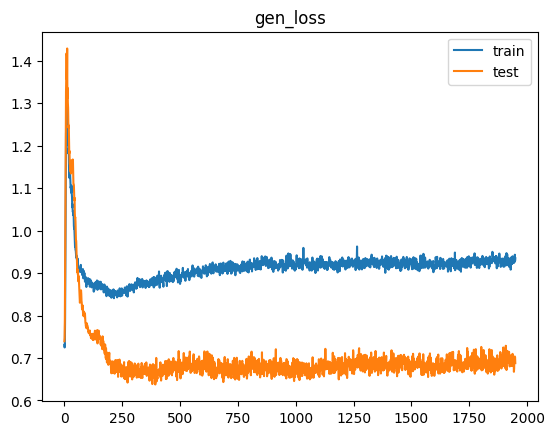

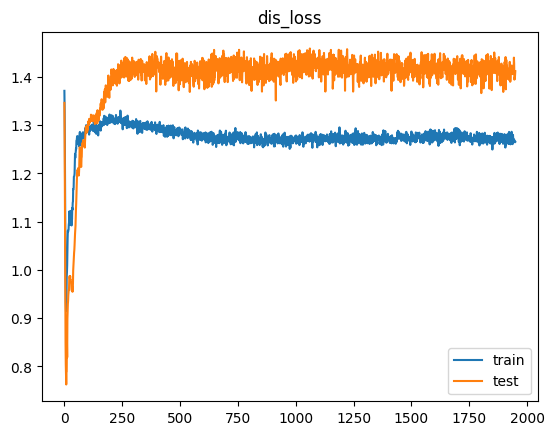

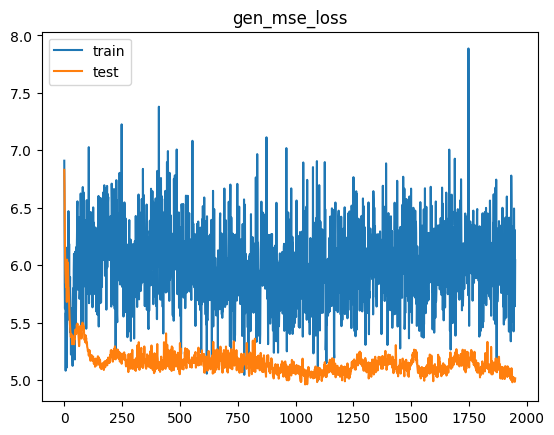

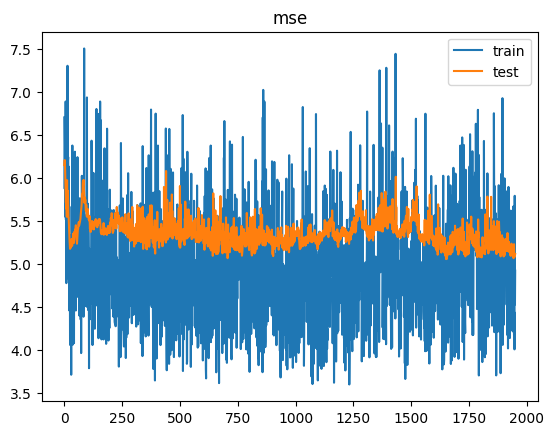

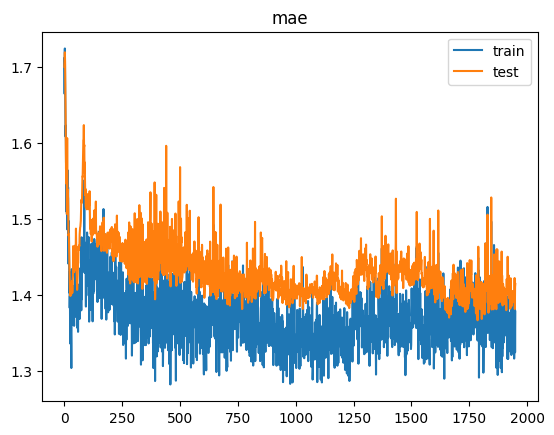

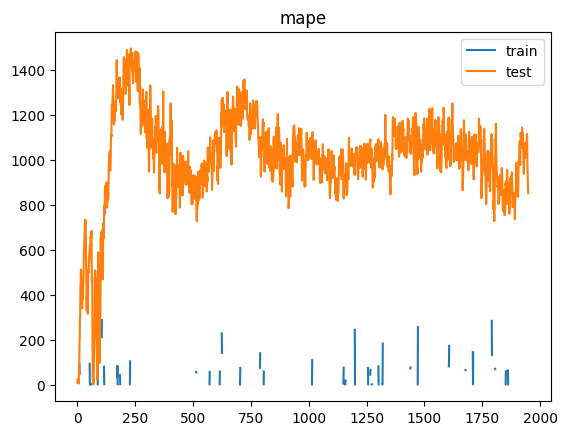

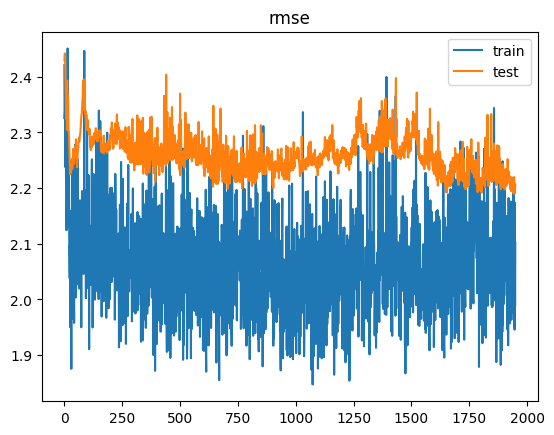

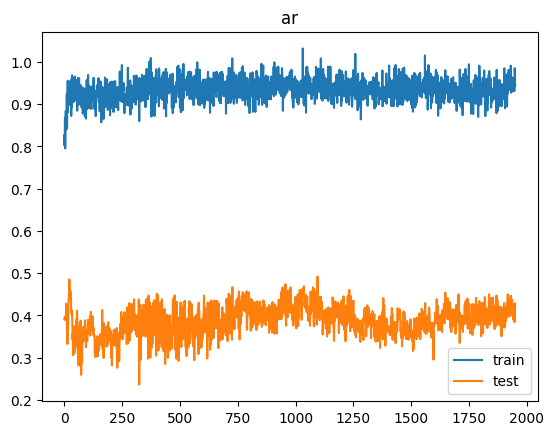

2/2 [==============================] - 0s 7ms/step


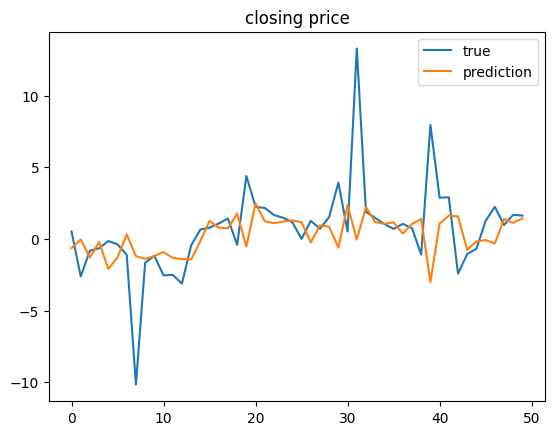

[MSE Baseline] train: 5.108500950657999  test: 5.010967196008289
Delta time with epochs = 1950: 0:50:31.343853


In [60]:
for epochs in [1200, 1450, 1700, 1950]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("rnn_ffnn_epochs_{0}.h5".format(epochs))